In [67]:
import os, re, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes import BetaGeoFitter, GammaGammaFitter
from utils_refactored import (
    standardize_columns, trim_strings, find_datetime_cols, coerce_datetimes_inplace,
    detect_columns, first_match, pick_first, numericize, finish_fig
)
OUT_DIR='out'

os.makedirs(OUT_DIR, exist_ok=True)
SHOW_PLOTS = True
SAVE_PLOTS = True

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)

paths={
  "users": "DE_DS_PracticeFiles/USERS.csv",
  "products": "DE_DS_PracticeFiles/PRODUCTS.csv",
  "orders": "DE_DS_PracticeFiles/ORDERS.csv",
  "order_items": "DE_DS_PracticeFiles/ORDER_ITEMS.csv"
}


In [68]:
# Import Users.csv
raw_users = pd.read_csv(paths["users"], dtype=str, keep_default_na=False, na_values=[])

# If the file has exactly one column (e.g., 'user_data'), find it:
users_json_col = raw_users.columns[0] if raw_users.shape[1] == 1 else "user_data"
if users_json_col not in raw_users.columns:
    # Fallback: assume the first column holds the JSONish data
    users_json_col = raw_users.columns[0]

def parse_users_row(s: str) -> dict:
    """
    Robust parser for rows like:
      {"id":93483,"":"/firstname/Brad","":"/lastname/Pitt", ...}
    Extracts:
      - id (int)
      - all '/key/value' pairs → key:value
    """
    out = {}
    text = (s or "").strip()

    # 1) Try to grab "id": <number> directly
    m = re.search(r'"id"\s*:\s*(\d+)', text)
    if m:
        out["id"] = int(m.group(1))

    # 2) Extract all '/key/value' style tokens, e.g. /firstname/Brad
    #    Allow letters, digits, underscore, hyphen in keys; values: stop at comma/quote/brace/bracket
    pairs = re.findall(r'/([\w\-]+)/([^,}"\]]+)', text)
    for k, v in pairs:
        out[k.lower()] = v.strip()

    # 3) If the row is actually valid JSON with usable keys, merge them
    try:
        obj = json.loads(text)
        if isinstance(obj, dict):
            for k, v in obj.items():
                if k and k.strip():  # ignore "" keys
                    out[k.strip().lower()] = v
    except Exception:
        pass

    return out

parsed_users = [parse_users_row(s) for s in raw_users[users_json_col]]
users = pd.DataFrame(parsed_users)

# Optional: rename common fields to conventional names
rename_map = {
    "firstname": "first_name",
    "lastname": "last_name",
    "e_mail": "email",
}
users.rename(columns=rename_map, inplace=True)

# Standard cleanup
users = standardize_columns(users)
users = trim_strings(users)

# Parse any datetime-like columns
dt_cols = find_datetime_cols(users)
coerce_datetimes_inplace(users, dt_cols)
users.attrs["datetime_cols"] = dt_cols

print("Users parsed shape:", users.shape)
users.head()


Users parsed shape: (100000, 11)


,id,first_name,last_name,email,age,gender,state,street,postalcode,country,city
0,93483,Brad,Ferguson,bradferguson@example.net,16,M,Acre,8427 Rachel Drive Suite 095,69980-000,Brasil,NaN
1,685,Erica,Levine,ericalevine@example.com,37,F,Acre,3160 Lisa Springs Suite 593,69980-000,Brasil,NaN
2,99142,Austin,Simmons,austinsimmons@example.org,21,M,Acre,62944 Miles Avenue,69980-000,Brasil,NaN
3,38974,Linda,King,lindaking@example.com,20,F,Acre,26711 George Centers Suite 634,69980-000,Brasil,NaN
4,46889,Larry,Howard,larryhoward@example.net,39,M,Acre,438 Richard Roads,69980-000,Brasil,NaN


In [69]:
# Strategy:
#  - If file text starts with '[' → parse whole file as a JSON array
#  - Else read as CSV and parse the first cell as a JSON array

with open(paths["products"], "r", encoding="utf-8") as f:
    txt = f.read().strip()

products = None
if txt.startswith("["):
    try:
        products = pd.DataFrame(json.loads(txt))
    except Exception:
        products = None

if products is None:
    # Try as one-cell CSV
    tmp = pd.read_csv(paths["products"], dtype=str, keep_default_na=False, na_values=[])
    first_cell = tmp.iloc[0, 0]
    products = pd.DataFrame(json.loads(first_cell))

# Standard cleanup
products = standardize_columns(products)
products = trim_strings(products)
dt_cols = find_datetime_cols(products)
coerce_datetimes_inplace(products, dt_cols)
products.attrs["datetime_cols"] = dt_cols

print("Products parsed shape:", products.shape)
products.head()


Products parsed shape: (29120, 9)


,id,cost,category,name,brand,retail_price,department,sku,distribution_center_id
0,13842,2.51875,Accessories,Low Profile Dyed Cotton Twill Cap - Navy W39S55D,MG,6.25,Women,EBD58B8A3F1D72F4206201DA62FB1204,1
1,13928,2.33835,Accessories,Low Profile Dyed Cotton Twill Cap - Putty W39S55D,MG,5.95,Women,2EAC42424D12436BDD6A5B8A88480CC3,1
2,14115,4.87956,Accessories,Enzyme Regular Solid Army Caps-Black W35S45D,MG,10.99,Women,EE364229B2791D1EF9355708EFF0BA34,1
3,14157,4.64877,Accessories,Enzyme Regular Solid Army Caps-Olive W35S45D (...,MG,10.99,Women,00BD13095D06C20B11A2993CA419D16B,1
4,14273,6.50793,Accessories,Washed Canvas Ivy Cap - Black W11S64C,MG,15.99,Women,F531DC20FDE20B7ADF3A73F52B71D0AF,1


In [70]:
orders      = pd.read_csv(paths["orders"], low_memory=False)
order_items = pd.read_csv(paths["order_items"], low_memory=False)

orders      = standardize_columns(orders)
order_items = standardize_columns(order_items)

orders      = trim_strings(orders)
order_items = trim_strings(order_items)

coerce_datetimes_inplace(orders, find_datetime_cols(orders))
coerce_datetimes_inplace(order_items, find_datetime_cols(order_items))

orders.attrs["datetime_cols"] = find_datetime_cols(orders)
order_items.attrs["datetime_cols"] = find_datetime_cols(order_items)

print("Orders shape:", orders.shape, "| Order items shape:", order_items.shape)
orders.head(), order_items.head()


Orders shape: (82480, 9) | Order items shape: (63987, 11)


(   order_id  user_id     status gender          created_at returned_at shipped_at delivered_at  num_of_item
 0         1        1  Cancelled      F 2020-03-20 11:43:00         NaT        NaT          NaT            2
 1        17       11  Cancelled      F 2024-04-16 14:15:00         NaT        NaT          NaT            1
 2        78       52  Cancelled      F 2025-04-07 15:12:00         NaT        NaT          NaT            1
 3       101       74  Cancelled      F 2025-08-12 14:56:00         NaT        NaT          NaT            2
 4       106       78  Cancelled      F 2025-06-06 07:09:00         NaT        NaT          NaT            1,
        id  order_id  user_id  product_id  inventory_item_id      status          created_at shipped_at delivered_at returned_at  \
 0  102433     70865    56891       14235             276182  Processing 2024-06-06 04:30:37        NaT          NaT         NaT   
 1  172184    118909    95392       14235             464193  Processing 2023-01-

In [76]:
order_items.head()

,id,order_id,user_id,product_id,inventory_item_id,status,created_at,shipped_at,delivered_at,returned_at,sale_price
0,102433,70865,56891,14235,276182,Processing,2024-06-06 04:30:37,NaT,NaT,NaT,0.02
1,172184,118909,95392,14235,464193,Processing,2023-01-13 12:19:51,NaT,NaT,NaT,0.02
2,29962,20664,16594,14159,80716,Cancelled,2024-05-14 21:54:31,NaT,NaT,NaT,0.49
3,39421,27184,21869,14159,106192,Cancelled,2022-04-19 09:09:24,NaT,NaT,NaT,0.49
4,72384,50056,40169,14159,195132,Cancelled,2025-06-14 09:23:23,NaT,NaT,NaT,0.49


/var/folders/8s/kmd281414_3_sk09mpml3zvh0000gn/T/ipykernel_7707/1543487886.py:31: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  months_covered = nonnull.dt.to_period("M").nunique()


,event,column,coverage_%,min_utc,max_utc,span_days
0,created_at,created_at,100.00,2019-01-10 00:24:00+00:00,2025-08-27 19:24:57.272875+00:00,2422
1,shipped_at,shipped_at,61.76,2019-01-12 02:55:00+00:00,2025-08-30 16:11:39.414889+00:00,2423
2,delivered_at,delivered_at,39.31,2019-01-16 02:47:00+00:00,2025-09-04 06:33:47.096178+00:00,2424
3,returned_at,returned_at,7.51,2019-02-05 02:47:00+00:00,2025-09-04 21:54:10.567408+00:00,2404


,metric,value
0,primary_date_key,created_at
1,primary_date_column,created_at
2,data_start_utc,2019-01-10 00:24:00+00:00
3,data_end_utc,2025-08-27 19:24:57.272875+00:00
4,window_days,2422
5,window_months,79.57
6,window_years,6.63
7,distinct_months_with_orders,80


,created_at,orders_per_month
0,2019-01-01 00:00:00+00:00,8
1,2019-02-01 00:00:00+00:00,17
2,2019-03-01 00:00:00+00:00,37
3,2019-04-01 00:00:00+00:00,57
4,2019-05-01 00:00:00+00:00,67


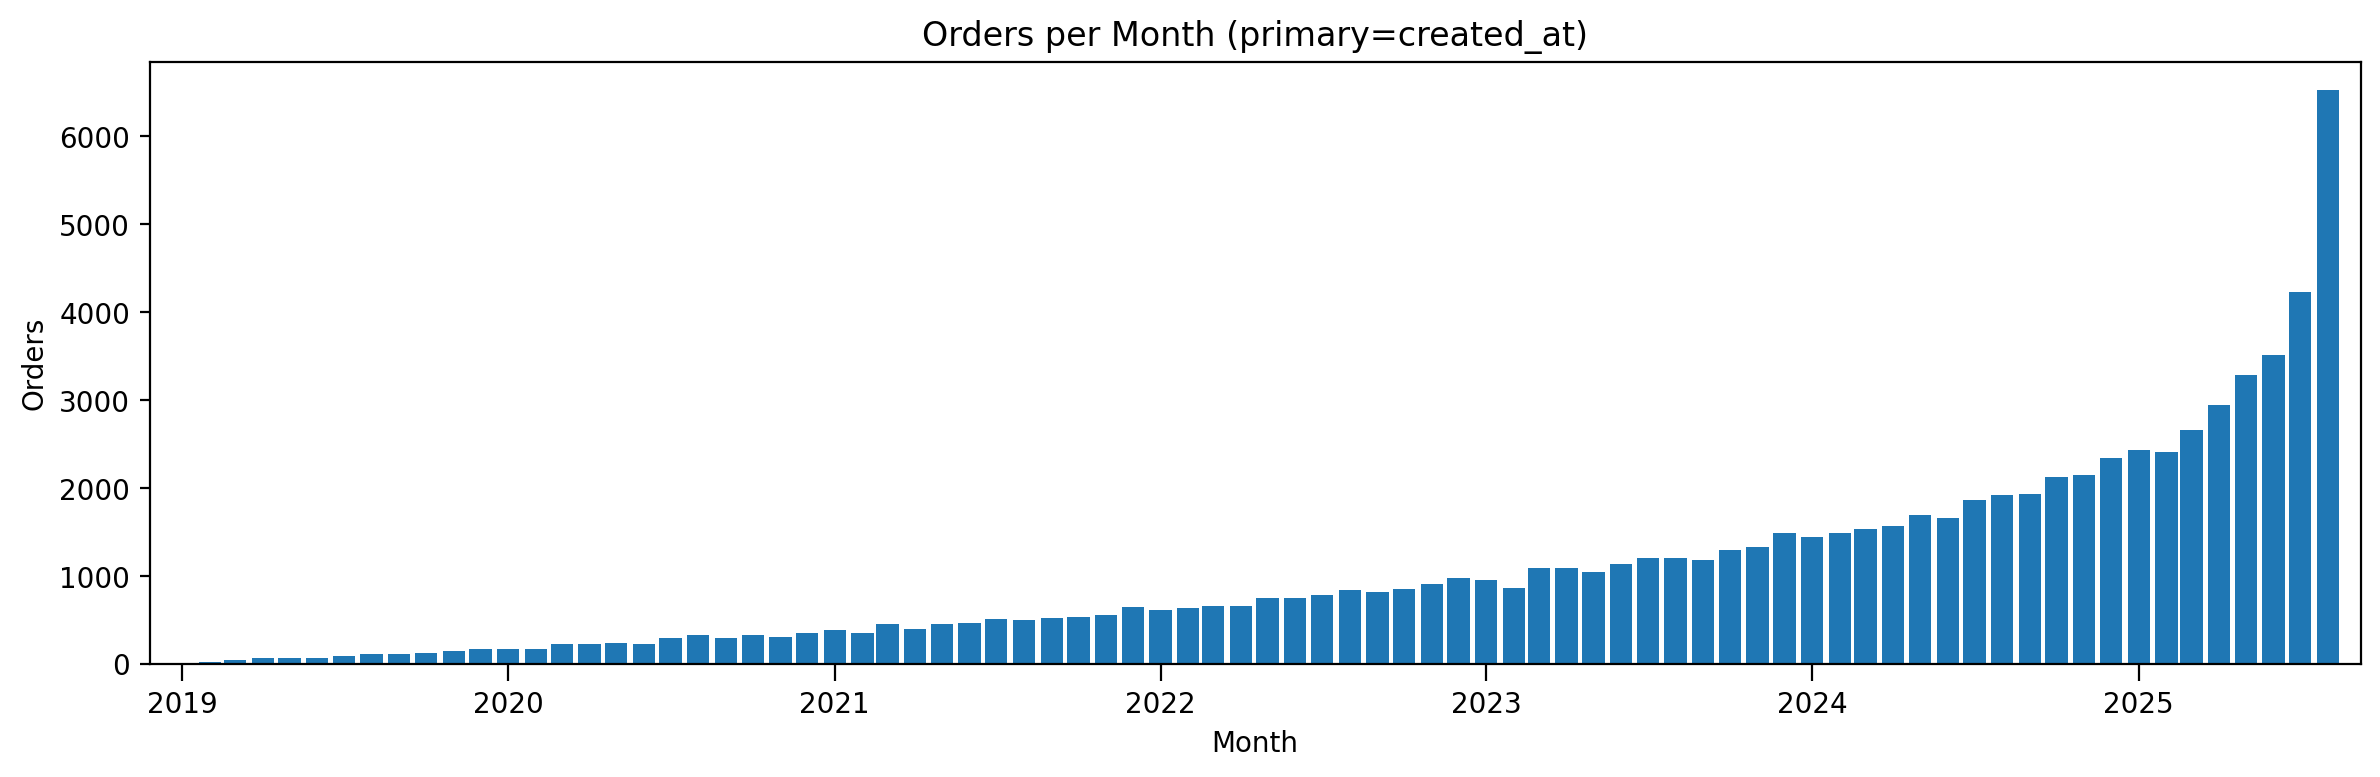

In [74]:

# --- normalize all detected events to UTC (tz-aware) ---
orders_dt = orders.copy()
for k, col in event_cols.items():
    if col:
        orders_dt[col] = to_dt_utc(orders_dt[col])

# --- choose a primary date column ---
# preference order if present; else pick the event with the highest coverage; else any datetime col
pref_order = ["created_at","paid_at","shipped_at","delivered_at"]
primary_key = next((k for k in pref_order if event_cols.get(k)), None)

if not primary_key:
    cover = {k: orders_dt[c].notna().mean() if c else 0 for k, c in event_cols.items()}
    primary_key = max(cover, key=cover.get) if any(cover.values()) else None

primary_col = event_cols.get(primary_key) if primary_key else None
if not primary_col:
    # fallback: any datetime-like column
    dt_cols = orders_dt.select_dtypes(include=["datetime64[ns, UTC]","datetime64[ns]"]).columns.tolist()
    primary_col = dt_cols[0] if dt_cols else None
    primary_key = primary_col or "n/a"

# --- compute overall window on primary ---
if primary_col:
    nonnull = orders_dt[primary_col].dropna()
    data_start_utc = nonnull.min()
    data_end_utc   = nonnull.max()
    window_days    = int((data_end_utc - data_start_utc).days) + 1 if pd.notna(data_start_utc) and pd.notna(data_end_utc) else np.nan
    window_months  = round(window_days/30.44, 2) if window_days == window_days else np.nan
    window_years   = round(window_days/365.25, 2) if window_days == window_days else np.nan
    months_covered = nonnull.dt.to_period("M").nunique()
else:
    data_start_utc = data_end_utc = pd.NaT
    window_days = window_months = window_years = months_covered = np.nan

# --- per-event min/max & coverage ---
event_summary = []
for k, col in event_cols.items():
    if col:
        s = orders_dt[col].dropna()
        event_summary.append({
            "event": k,
            "column": col,
            "coverage_%": round(orders_dt[col].notna().mean()*100, 2),
            "min_utc": s.min() if not s.empty else pd.NaT,
            "max_utc": s.max() if not s.empty else pd.NaT,
            "span_days": (s.max() - s.min()).days + 1 if len(s) else np.nan
        })
event_summary_df = pd.DataFrame(event_summary).sort_values("coverage_%", ascending=False)
display(event_summary_df)

# --- overall date stats table ---
date_stats = pd.DataFrame([
    {"metric":"primary_date_key", "value": primary_key},
    {"metric":"primary_date_column", "value": primary_col},
    {"metric":"data_start_utc", "value": data_start_utc},
    {"metric":"data_end_utc", "value": data_end_utc},
    {"metric":"window_days", "value": window_days},
    {"metric":"window_months", "value": window_months},
    {"metric":"window_years", "value": window_years},
    {"metric":"distinct_months_with_orders", "value": int(months_covered) if months_covered==months_covered else np.nan},
])
display(date_stats)

# --- save CSVs ---
event_summary_df.to_csv(os.path.join(OUT_DIR, "date_event_summary.csv"), index=False)
date_stats.to_csv(os.path.join(OUT_DIR, "dataset_date_stats.csv"), index=False)

# --- monthly orders plot on the primary date ---
if primary_col:
    monthly = (orders_dt.set_index(primary_col)[order_id]
               .resample("MS").count().rename("orders_per_month").reset_index())
    display(monthly.head())

    fig, ax = plt.subplots(figsize=(12, 4))

    # Plot with real datetimes on the x-axis (no strftime here)
    ax.bar(
        monthly[primary_col],
        monthly["orders_per_month"],
        width=25,                 # ~25-day bar width looks good on a monthly series
        align="center"
    )
    
    # A little polish
    ax.tick_params(axis="x", which="major", length=6)
    ax.tick_params(axis="x", which="minor", length=3, labelsize=8)
    ax.set_title(f"Orders per Month (primary={primary_key})")
    ax.set_xlabel("Month"); ax.set_ylabel("Orders")
    ax.margins(x=0.01)
    fig.tight_layout()
    fig.savefig(os.path.join(OUT_DIR, "orders_per_month.png"), bbox_inches="tight", dpi=150)
    plt.show()
else:
    print("No usable datetime column found to plot monthly orders.")


In [79]:
# ==== Dataset overview / basic statistics ====
import os, numpy as np, pandas as pd

OUT_DIR = "./out"; os.makedirs(OUT_DIR, exist_ok=True)

def _to_dt(df, cols=("created_at","shipped_at","delivered_at","returned_at")):
    df = df.copy()
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_datetime(df[c], errors="coerce", utc=True)
    return df

def _num(s): return pd.to_numeric(s, errors="coerce")

# 0) Coerce datetimes for safe time math
orders_dt      = _to_dt(orders)
order_items_dt = _to_dt(order_items)

# 1) Build line-level revenue (exclude returns/cancels if detectable)
oi = order_items_dt.copy()

if "sale_price" in oi.columns:
    oi["line_revenue"] = _num(oi["sale_price"]).fillna(0.0)
else:
    oi["line_revenue"] = 0.0  # fallback

# returns/cancels detection
bad = pd.Series(False, index=oi.index)
if "status" in oi.columns:
    bad = bad | oi["status"].astype(str).str.lower().str.contains("return|cancel|refund|chargeback")
if "returned_at" in oi.columns:
    bad = bad | oi["returned_at"].notna()

oi_good = oi.loc[~bad].copy()

# 2) Revenue per order and orders_enriched
rev_per_order = oi_good.groupby("order_id")["line_revenue"].sum()
orders_enriched = orders_dt.copy()
orders_enriched["order_revenue"] = orders_enriched["order_id"].map(rev_per_order).fillna(0.0)

# 3) Coverage (what % of orders have each milestone)
coverage = {}
for c in ["created_at","shipped_at","delivered_at","returned_at"]:
    if c in orders_enriched.columns:
        coverage[c] = round(orders_enriched[c].notna().mean()*100, 2)

# 4) Time window on primary clock (prefer created_at, else first datetime col)
primary_col = "created_at" if "created_at" in orders_enriched.columns else (
    next((c for c in ["delivered_at","shipped_at"] if c in orders_enriched.columns), None)
)
if primary_col:
    start_utc = orders_enriched[primary_col].min()
    end_utc   = orders_enriched[primary_col].max()
    months_covered = orders_enriched.set_index(primary_col)["order_id"].resample("MS").count().shape[0]
else:
    start_utc = end_utc = pd.NaT
    months_covered = np.nan

# 5) Core counts
n_users   = users["id"].nunique()
n_items   = products["id"].nunique()
n_orders  = orders_enriched["order_id"].nunique()
n_lines   = oi.shape[0]

# 6) Revenue, AOV, orders per user
total_revenue = orders_enriched["order_revenue"].sum()
aov = total_revenue / max(n_orders, 1)

orders_per_user = (orders_enriched.groupby("user_id")["order_id"]
                   .nunique()
                   .rename("orders_per_user"))
rev_per_user = (orders_enriched.groupby("user_id")["order_revenue"]
                .sum()
                .rename("revenue_per_user"))

orders_per_user_stats = {
    "mean": float(orders_per_user.mean() if len(orders_per_user) else 0),
    "median": float(orders_per_user.median() if len(orders_per_user) else 0),
    "p90": float(orders_per_user.quantile(0.90) if len(orders_per_user) else 0),
}

# 7) Return rate (at order level if possible)
if "returned_at" in orders_enriched.columns:
    returned_orders = orders_enriched["returned_at"].notna().sum()
else:
    returned_orders = oi.loc[oi["returned_at"].notna(), "order_id"].nunique() if "returned_at" in oi.columns else np.nan
return_rate = (returned_orders / n_orders) if n_orders else np.nan

# 8) Top categories / brands by revenue
top_categories = pd.DataFrame()
top_brands = pd.DataFrame()
if {"product_id","line_revenue"} <= set(oi_good.columns):
    oi_prod = oi_good.merge(products[["id","category","brand"]], left_on="product_id", right_on="id", how="left")
    top_categories = (oi_prod.groupby("category", dropna=False)["line_revenue"]
                      .sum().sort_values(ascending=False).head(10)).reset_index(name="revenue")
    top_brands = (oi_prod.groupby("brand", dropna=False)["line_revenue"]
                  .sum().sort_values(ascending=False).head(10)).reset_index(name="revenue")

# 9) Users by country / gender
top_countries = users["country"].value_counts(dropna=False).head(10).rename_axis("country").reset_index(name="users") if "country" in users.columns else pd.DataFrame()
gender_split  = users["gender"].value_counts(dropna=False).rename_axis("gender").reset_index(name="users") if "gender" in users.columns else pd.DataFrame()

# --- build compact profile table (fixed syntax) ---
profile_rows = [
    ("unique_users", int(n_users)),
    ("unique_products", int(n_items)),
    ("unique_orders", int(n_orders)),
    ("line_items", int(n_lines)),
    ("total_revenue", float(round(total_revenue, 2))),
    ("aov", float(round(aov, 2))),
    ("orders_per_user_mean", float(round(orders_per_user_stats["mean"], 3))),
    ("orders_per_user_median", float(round(orders_per_user_stats["median"], 3))),
    ("orders_per_user_p90", float(round(orders_per_user_stats["p90"], 3))),
    ("return_rate_orders", float(round(return_rate, 4)) if pd.notna(return_rate) else np.nan),
    ("window_start_utc", start_utc),
    ("window_end_utc", end_utc),
    ("months_covered", int(months_covered) if pd.notna(months_covered) else np.nan),
]

profile = pd.DataFrame(profile_rows, columns=["metric", "value"])

coverage_df = pd.DataFrame({
    "metric": [f"coverage_{k}" for k in sorted(coverage.keys())],
    "value":  [f"{coverage[k]}%" for k in sorted(coverage.keys())],
})

# --- display & save ---
display(profile)
display(coverage_df)
if not top_countries.empty: display(top_countries)
if not gender_split.empty:  display(gender_split)
if not top_categories.empty: display(top_categories)
if not top_brands.empty:     display(top_brands)

profile.to_csv(os.path.join(OUT_DIR, "dataset_profile.csv"), index=False)
coverage_df.to_csv(os.path.join(OUT_DIR, "dataset_coverage.csv"), index=False)
orders_per_user.to_frame().to_csv(os.path.join(OUT_DIR, "orders_per_user.csv"))
rev_per_user.to_frame().to_csv(os.path.join(OUT_DIR, "revenue_per_user.csv"))
if not top_countries.empty: top_countries.to_csv(os.path.join(OUT_DIR, "top_countries.csv"), index=False)
if not gender_split.empty:  gender_split.to_csv(os.path.join(OUT_DIR, "gender_split.csv"), index=False)
if not top_categories.empty: top_categories.to_csv(os.path.join(OUT_DIR, "top_categories_by_revenue.csv"), index=False)
if not top_brands.empty:     top_brands.to_csv(os.path.join(OUT_DIR, "top_brands_by_revenue.csv"), index=False)

print("Saved basics to:", OUT_DIR)


,metric,value
0,unique_users,100000
1,unique_products,29120
2,unique_orders,82480
3,line_items,63987
4,total_revenue,572955.67
5,aov,6.95
6,orders_per_user_mean,1.457
7,orders_per_user_median,1.0
8,orders_per_user_p90,2.0
9,return_rate_orders,0.0751


,metric,value
0,coverage_created_at,100.0%
1,coverage_delivered_at,39.31%
2,coverage_returned_at,7.51%
3,coverage_shipped_at,61.76%


,country,users
0,China,34005
1,United States,22343
2,Brasil,14582
3,South Korea,5338
4,France,4774
5,United Kingdom,4669
6,Germany,4145
7,Spain,4045
8,Japan,2424
9,Australia,2227


,gender,users
0,M,50022
1,F,49978


,category,revenue
0,Intimates,95024.359863
1,Underwear,89059.589956
2,Tops & Tees,81710.990051
3,Accessories,71493.639745
4,Socks,64886.459913
5,Sleep & Lounge,63177.959730
6,Active,56819.429904
7,Shorts,54335.489898
8,Socks & Hosiery,38252.889889
9,Swim,33065.709837


,brand,revenue
0,Allegra K,62619.520008
1,Hanes,22074.089976
2,Calvin Klein,14173.950024
3,Nautica,11696.700002
4,Fruit of the Loom,10262.899984
5,Champion,9594.559975
6,Jockey,9264.790001
7,FineBrandShop,8837.899951
8,Dockers,8509.210005
9,SmartWool,8507.350170


Saved basics to: ./out


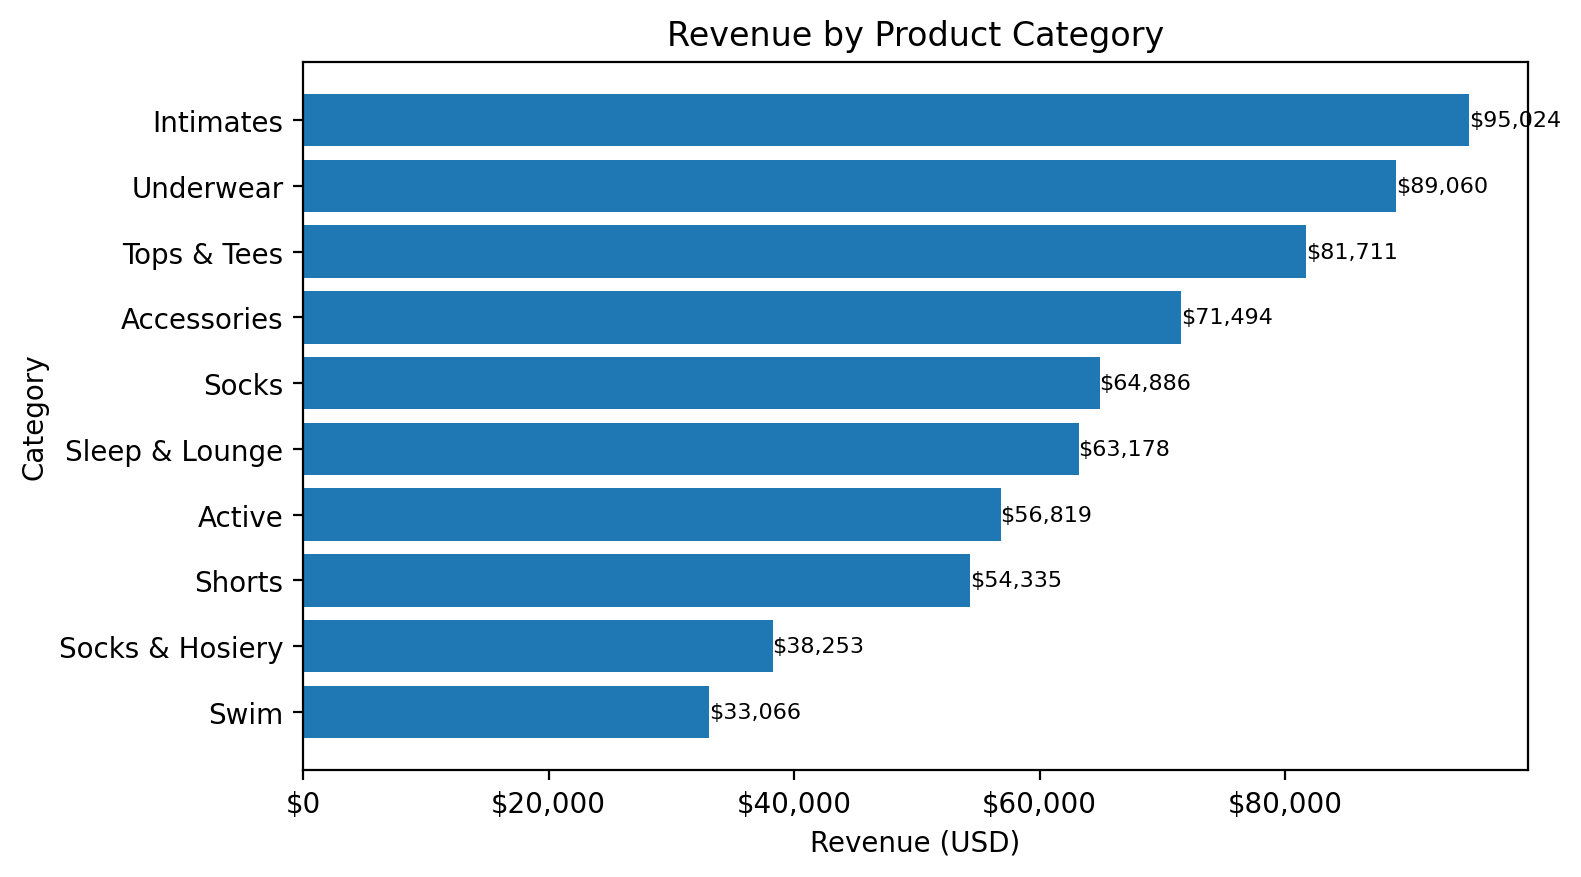

In [153]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

cat_rev = pd.DataFrame({
    "category": [
        "Intimates", "Underwear", "Tops & Tees", "Accessories", "Socks",
        "Sleep & Lounge", "Active", "Shorts", "Socks & Hosiery", "Swim"
    ],
    "revenue": [
        95024.359863, 89059.589956, 81710.990051, 71493.639745, 64886.459913,
        63177.959730, 56819.429904, 54335.489898, 38252.889889, 33065.709837
    ]
})

# Sort for a nicer barh
cat_rev_sorted = cat_rev.sort_values("revenue", ascending=True)

fig, ax = plt.subplots(figsize=(8, 4.5))

ax.barh(cat_rev_sorted["category"], cat_rev_sorted["revenue"])

ax.set_xlabel("Revenue (USD)")
ax.set_ylabel("Category")
ax.set_title("Revenue by Product Category")

# Format x-axis as dollars
ax.xaxis.set_major_formatter(
    FuncFormatter(lambda x, pos: f"${x:,.0f}")
)

# Add dollar labels at the end of each bar
for i, v in enumerate(cat_rev_sorted["revenue"]):
    ax.text(v, i,
            f"${v:,.0f}",
            va="center", ha="left", fontsize=8)

plt.tight_layout()
plt.savefig("out/category_revenue_barh_usd.png", dpi=150)
plt.show()


,label,total_quantity
0,Calvin Klein Men's Flexible Fit Trunk,16.0
1,Red Kap Men's Work Jeans 100% Cotton 13.75oz H...,14.0
2,Calvin Klein Men Bamboo Blend Flat Knit Dress ...,14.0
3,Nautica Men's Sold Swimsuit Trunk,14.0
4,Leather Cover Passport Holder Travel Wallet wi...,14.0
5,Thorlo Combat Boot Socks - Coyote Brown MCB,13.0
6,Basketball Socks Half Cushioned Crew Socks - B...,13.0
7,Lucky Brand Women's Riley Frayed Printed Short,13.0
8,180s Men's Soft Shell Ear Warmer,13.0
9,Footprint Ski and Snowboard Unisex Bamboo Socks,13.0


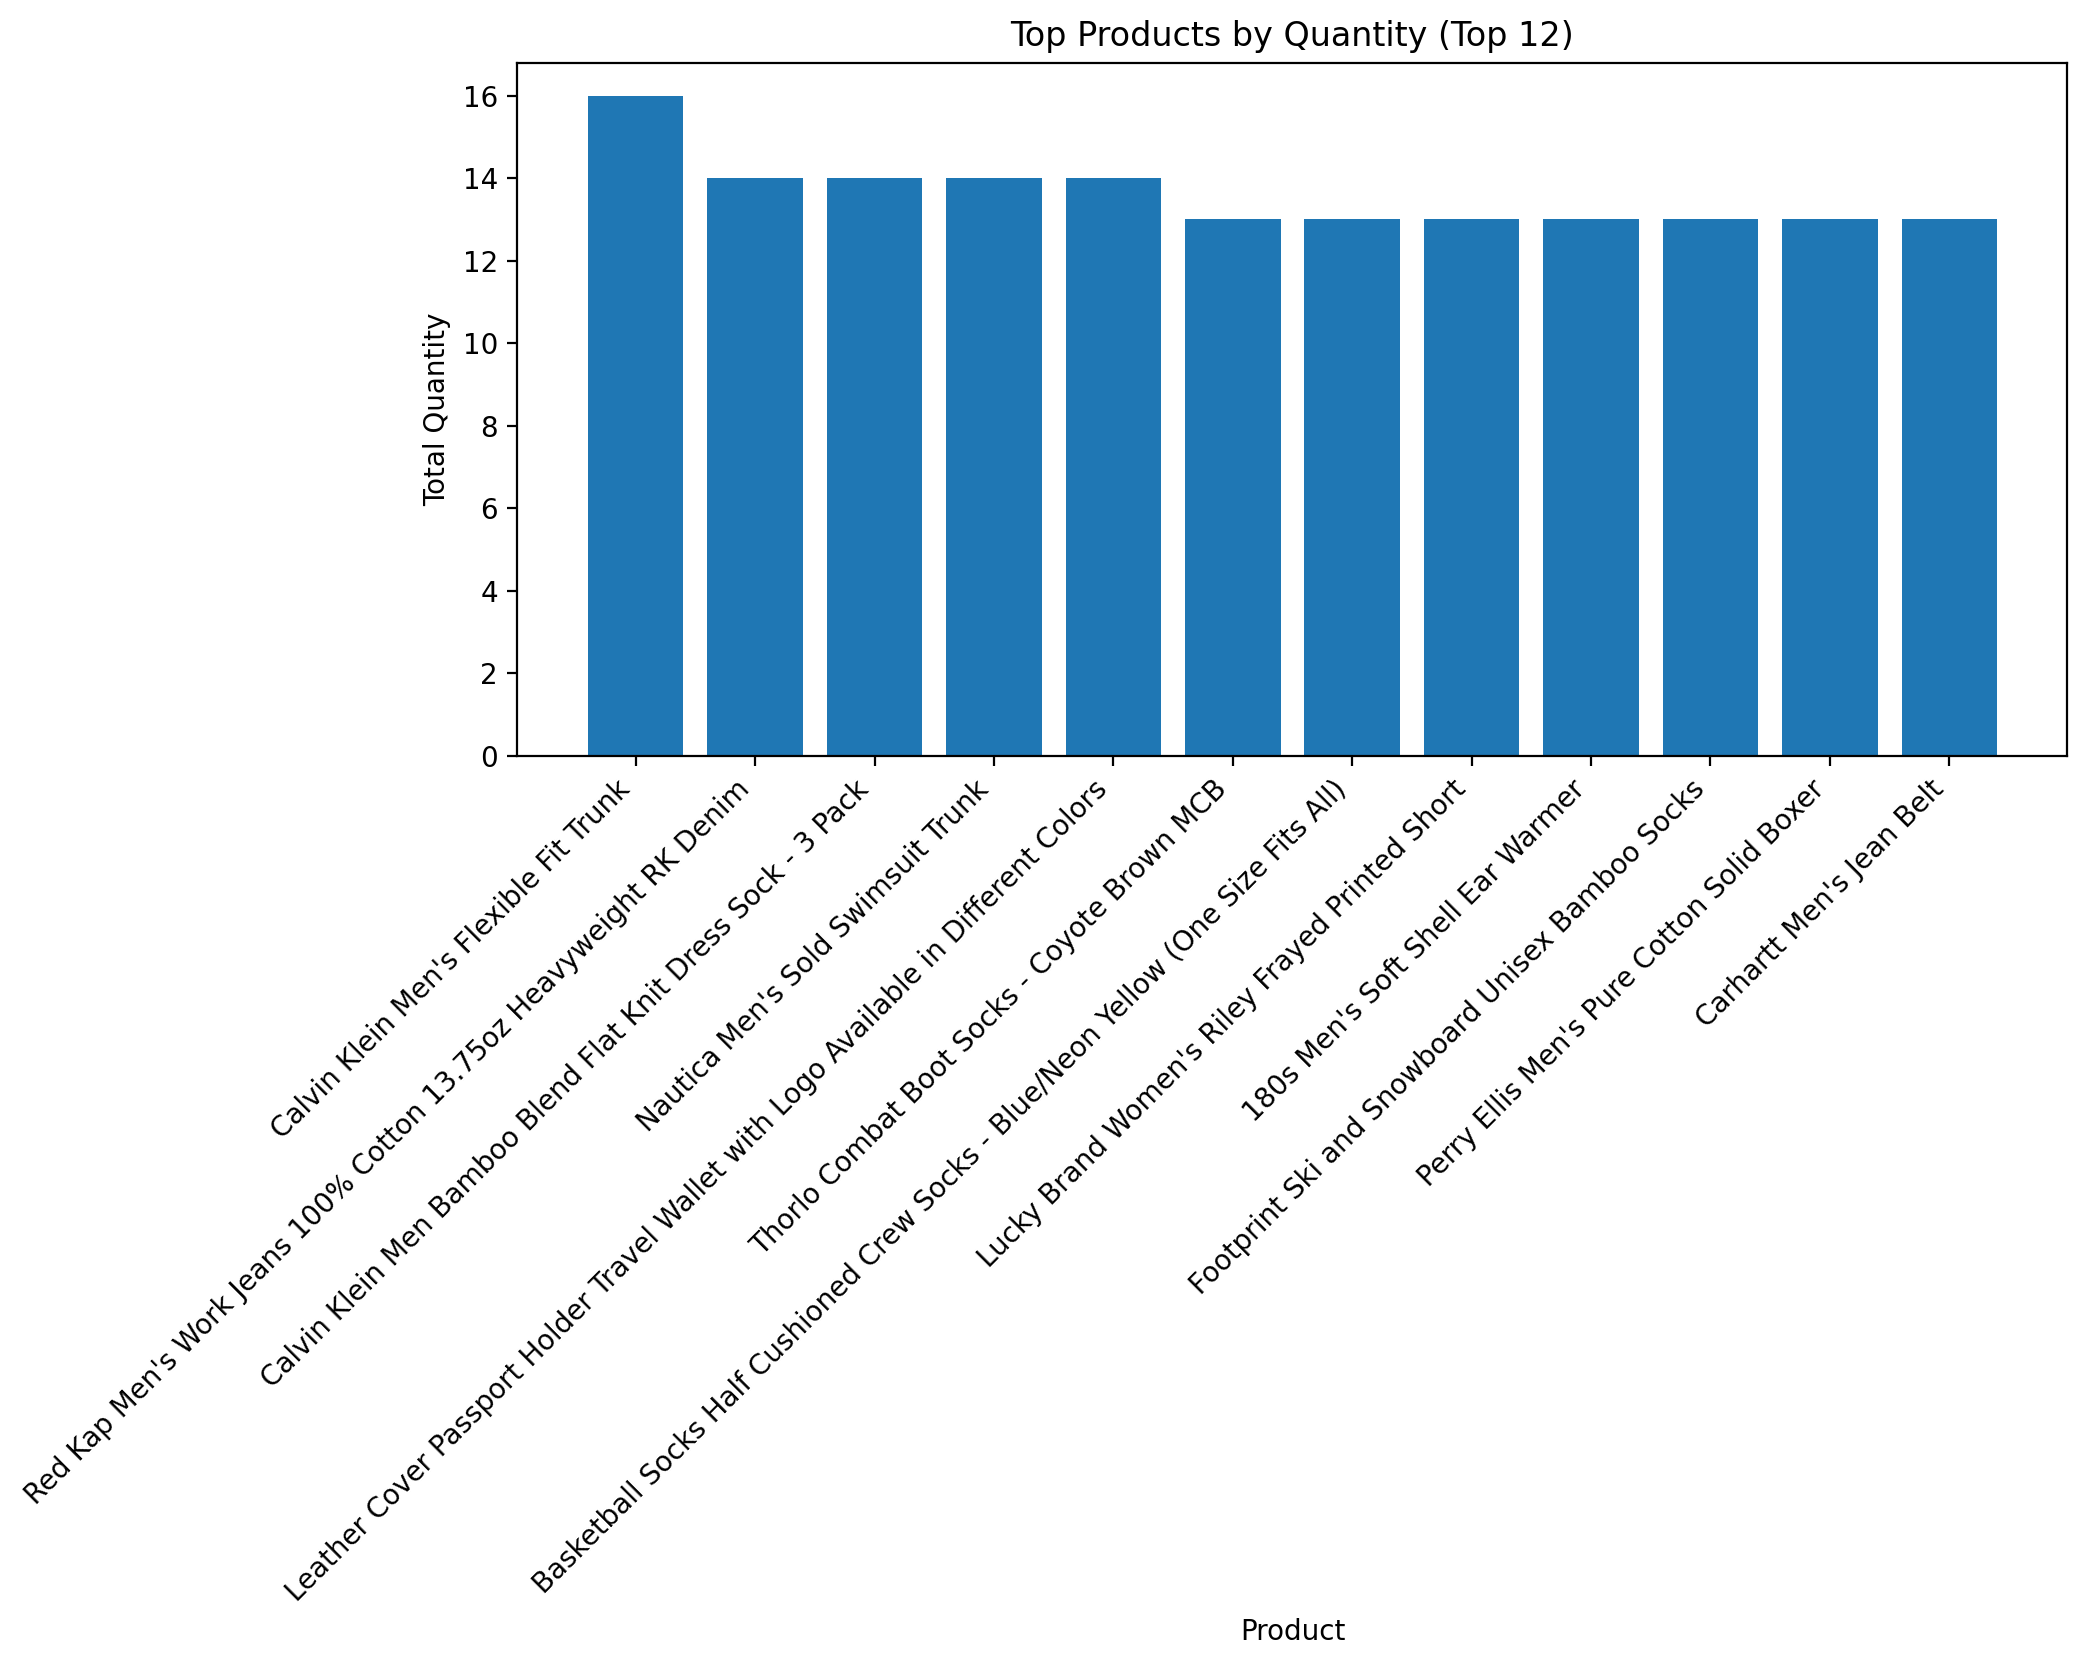

In [151]:
# ==== Top 20 most-ordered items (by quantity) — robust, no oi_enriched needed ====
import os
import pandas as pd
import matplotlib.pyplot as plt

# Fallback for finish_fig if you don't have it defined already
if 'finish_fig' not in globals():
    def finish_fig(fig, filename=None):
        if 'OUT_DIR' in globals() and filename:
            os.makedirs(OUT_DIR, exist_ok=True)
            fig.savefig(os.path.join(OUT_DIR, filename), bbox_inches="tight", dpi=150)
        plt.show()
        plt.close(fig)

def _first(*names, df=None):
    """Return the first column name that exists in df (or None)."""
    for n in names:
        if n in df.columns:
            return n
    return None

# Work from raw order_items
oi = order_items.copy()

# 1) Quantity: use a quantity-like column if present, else treat each row as 1 unit
qty_col = _first("quantity", "qty", "num_of_item", "num_of_items", "count", "units", "item_count", df=oi)
if qty_col is None:
    oi["__qty"] = 1.0
    qty_col = "__qty"
else:
    oi[qty_col] = pd.to_numeric(oi[qty_col], errors="coerce").fillna(1.0)

# 2) Filter returns/cancels when detectable
bad = pd.Series(False, index=oi.index)
if "status" in oi.columns:
    bad = bad | oi["status"].astype(str).str.lower().str.contains(r"return|cancel|refund|chargeback")
if "returned_at" in oi.columns:
    bad = bad | pd.to_datetime(oi["returned_at"], errors="coerce").notna()
oi_good = oi.loc[~bad].copy()

# 3) Product FK
prod_fk = _first("product_id", "sku", "asin", "item_sku", "product", df=oi_good)
assert prod_fk is not None, "No product id/sku column found in order_items."

# 4) Aggregate quantity per product
qty_by_prod = (
    oi_good.groupby(prod_fk, dropna=False)[qty_col]
    .sum(min_count=1)
    .reset_index(name="total_quantity")
    .sort_values("total_quantity", ascending=False)
)

# 5) Attach a human-readable label from products
prod_label = _first("name", "title", "product_name", "sku", "id", df=products)
if "id" in products.columns:
    lookup = products[["id", prod_label]].drop_duplicates()
    qty_with_label = qty_by_prod.merge(lookup, left_on=prod_fk, right_on="id", how="left")
else:
    # Fallback if products has no 'id' column
    lookup = products[[prod_label]].drop_duplicates()
    qty_with_label = qty_by_prod.merge(lookup, left_on=prod_fk, right_on=prod_label, how="left")

qty_with_label["label"] = qty_with_label[prod_label].fillna(qty_with_label[prod_fk].astype(str))

# 6) Output & plot
top20_items = qty_with_label[["label", "total_quantity"]].head(20)
display(top20_items)

if "OUT_DIR" in globals():
    top20_items.to_csv(os.path.join(OUT_DIR, "top20_items_by_quantity.csv"), index=False)

if not top20_items.empty:
    head = top20_items.head(12)
    fig = plt.figure(figsize=(10, 4.5))
    plt.bar(head["label"].astype(str), head["total_quantity"])
    plt.xticks(rotation=45, ha="right")
    plt.title("Top Products by Quantity (Top 12)")
    plt.xlabel("Product"); plt.ylabel("Total Quantity")
    finish_fig(fig, "top_products_by_quantity.png")



Customers by age bucket:


,age_bucket,customers
6,<18,10006
4,18-24,11783
3,25-34,16925
2,35-44,16967
0,45-54,17044
1,55-64,17001
5,65+,10274


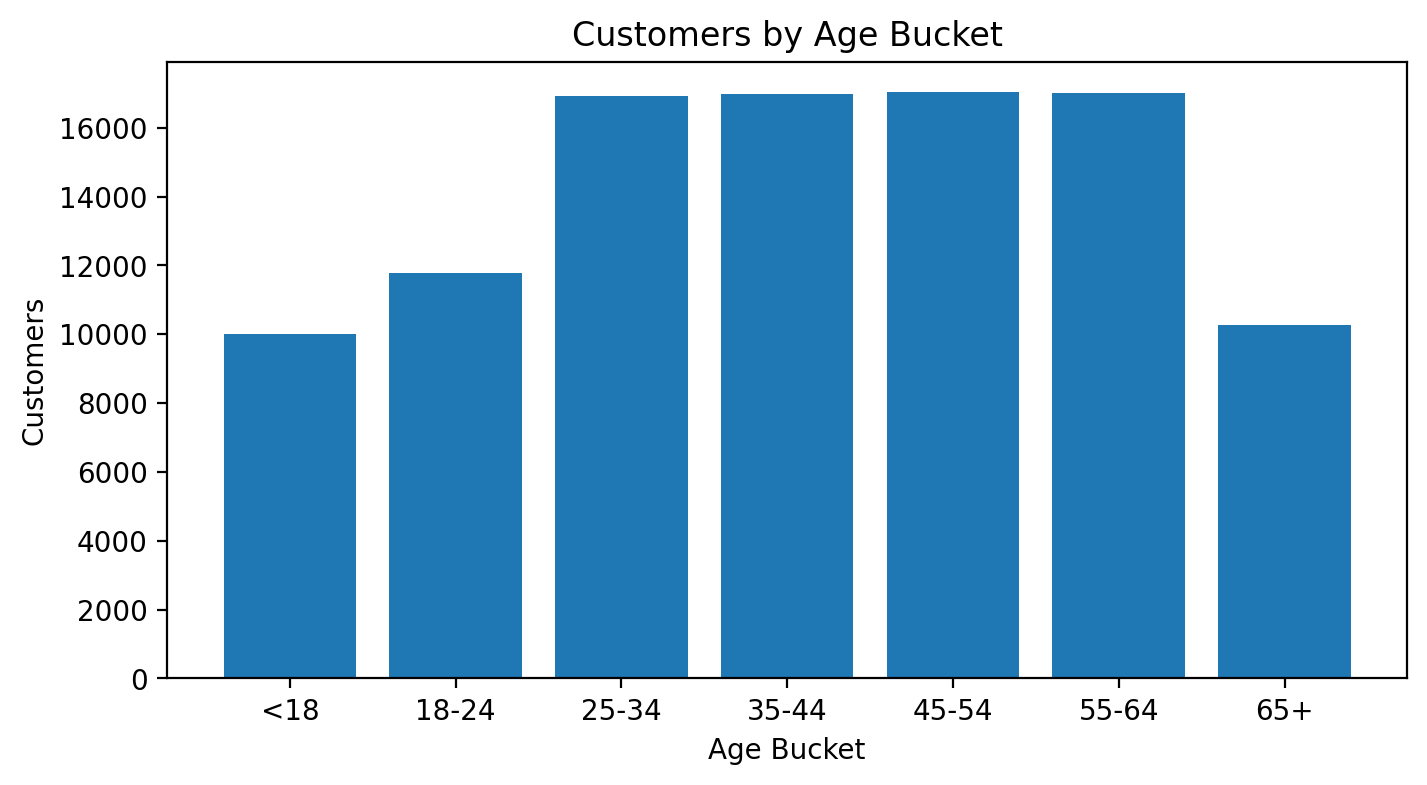

In [85]:
# ========= 2) Age buckets — robust DOB parsing (and plot) =========
def build_age_years(df):
    df = df.copy()
    # direct DOB-like columns
    dob_col = pick_first(detect_columns(df, ["dob","birth","birthday","date_of_birth"]))
    if dob_col:
        df[dob_col] = pd.to_datetime(df[dob_col], errors="coerce")
        age_years = ((pd.Timestamp.today() - df[dob_col]).dt.days/365.25)
        df["age_years"] = age_years
    
    # explicit age fields (if present)
    if "age_years" not in df.columns:
        age_col = pick_first(detect_columns(df, ["age_years","age"]))
        if age_col:
            df["age_years"] = pd.to_numeric(df[age_col], errors="coerce")
    
    # year/month/day split fields (birth_year, birth_month, birth_day)
    if "age_years" not in df.columns or df["age_years"].isna().all():
        y = pick_first(detect_columns(df, ["birth_year","yob","year_of_birth"]))
        m = pick_first(detect_columns(df, ["birth_month","mob","month_of_birth"]))
        d = pick_first(detect_columns(df, ["birth_day","dob_day","day_of_birth"]))
        if y:
            # approximate date (use 6/30 if month/day missing)
            yr = pd.to_numeric(df[y], errors="coerce")
            mo = pd.to_numeric(df[m], errors="coerce") if m else 6
            dy = pd.to_numeric(df[d], errors="coerce") if d else 15
            dob = pd.to_datetime(dict(year=yr, month=mo, day=dy), errors="coerce")
            df["age_years"] = ((pd.Timestamp.today() - dob).dt.days/365.25)
    return df

users = build_age_years(users)

if "age_years" in users.columns and users["age_years"].notna().any():
    bins = [0,18,25,35,45,55,65,120]
    labels = ["<18","18-24","25-34","35-44","45-54","55-64","65+"]
    users["age_bucket"] = pd.cut(users["age_years"], bins=bins, labels=labels, right=False, include_lowest=True)
    age_buckets = (users["age_bucket"]
                   .value_counts(dropna=False)
                   .rename_axis("age_bucket")
                   .reset_index(name="customers")
                   .sort_values("age_bucket"))
    print("\nCustomers by age bucket:")
    display(age_buckets)
    age_buckets.to_csv(os.path.join(OUT_DIR, "customers_by_age_bucket.csv"), index=False)

    fig = plt.figure(figsize=(8,4))
    plt.bar(age_buckets["age_bucket"].astype(str), age_buckets["customers"])
    plt.title("Customers by Age Bucket"); plt.xlabel("Age Bucket"); plt.ylabel("Customers")
    finish_fig(fig, "customers_by_age_bucket.png")
else:
    print("\nNo usable DOB/age fields detected to build age buckets.")


Order milestone coverage (% non-null):


,milestone,percent
0,created_at,100.00
1,paid_at,NaN
2,shipped_at,61.76
3,delivered_at,39.31
4,returned_at,7.51
5,canceled_at,NaN


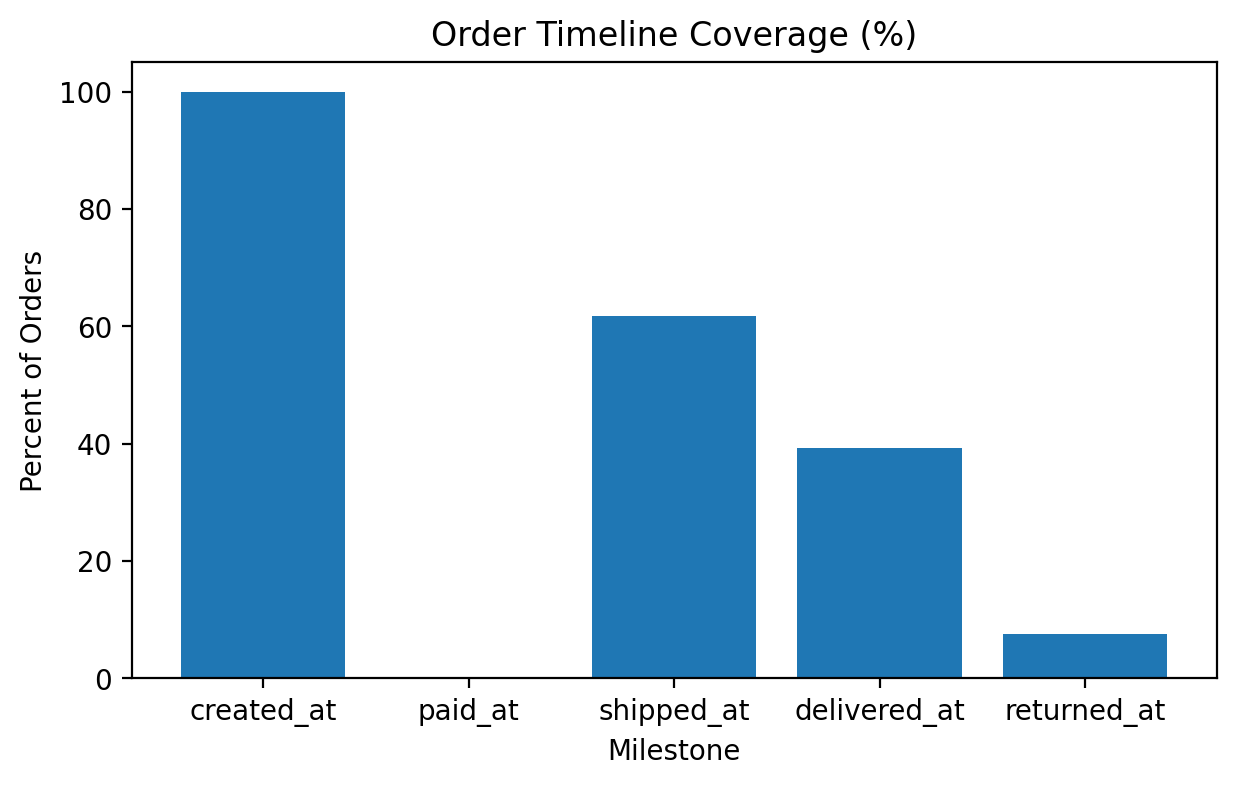


Latency summary (days):


,count,mean,std,min,50%,90%,95%,max
created_to_shipped_days,50937.0,1.50,0.87,0.0,1.50,2.70,2.85,3.0
shipped_to_delivered_days,32426.0,2.49,1.44,0.0,2.48,4.50,4.75,5.0
delivered_to_returned_days,6193.0,1.48,0.88,0.0,1.47,2.71,2.85,3.0


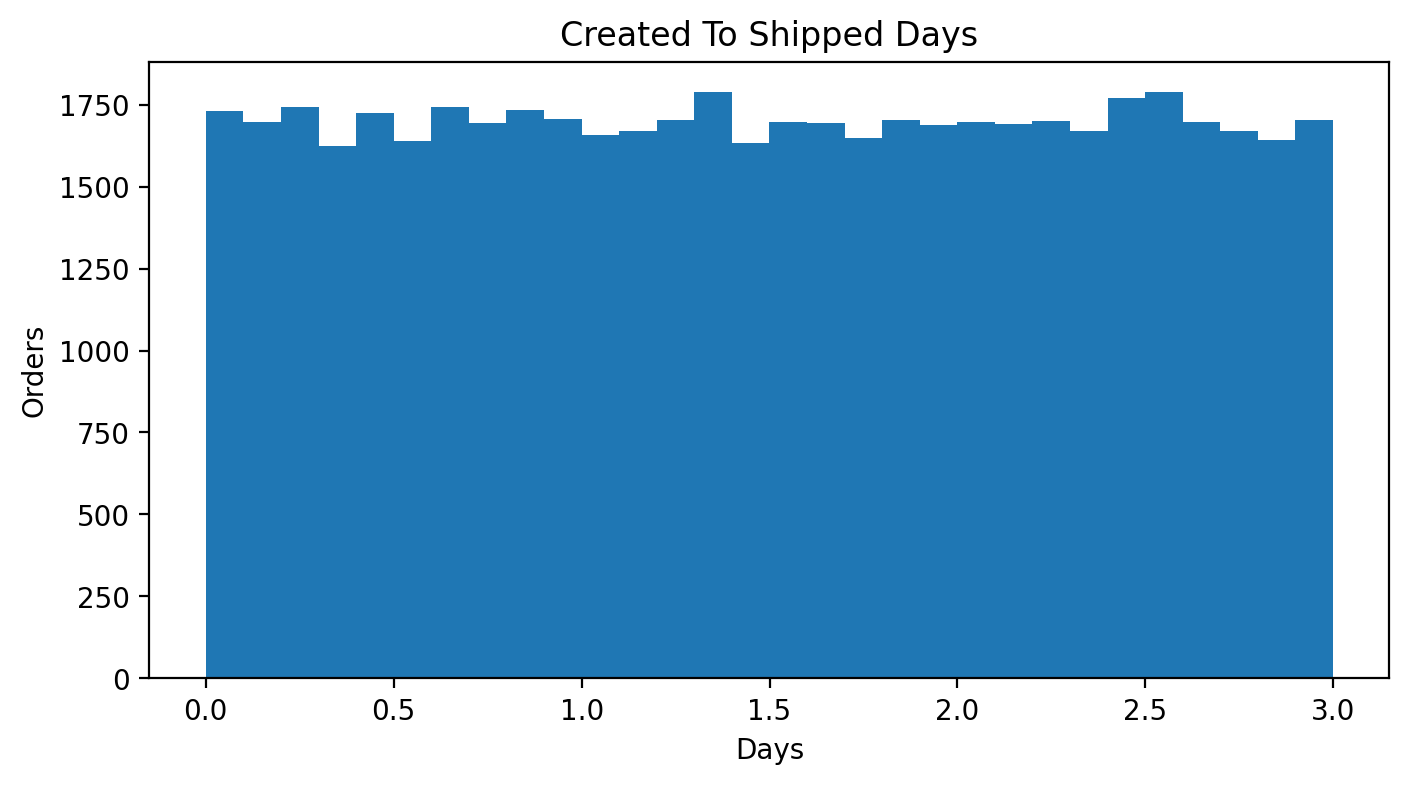

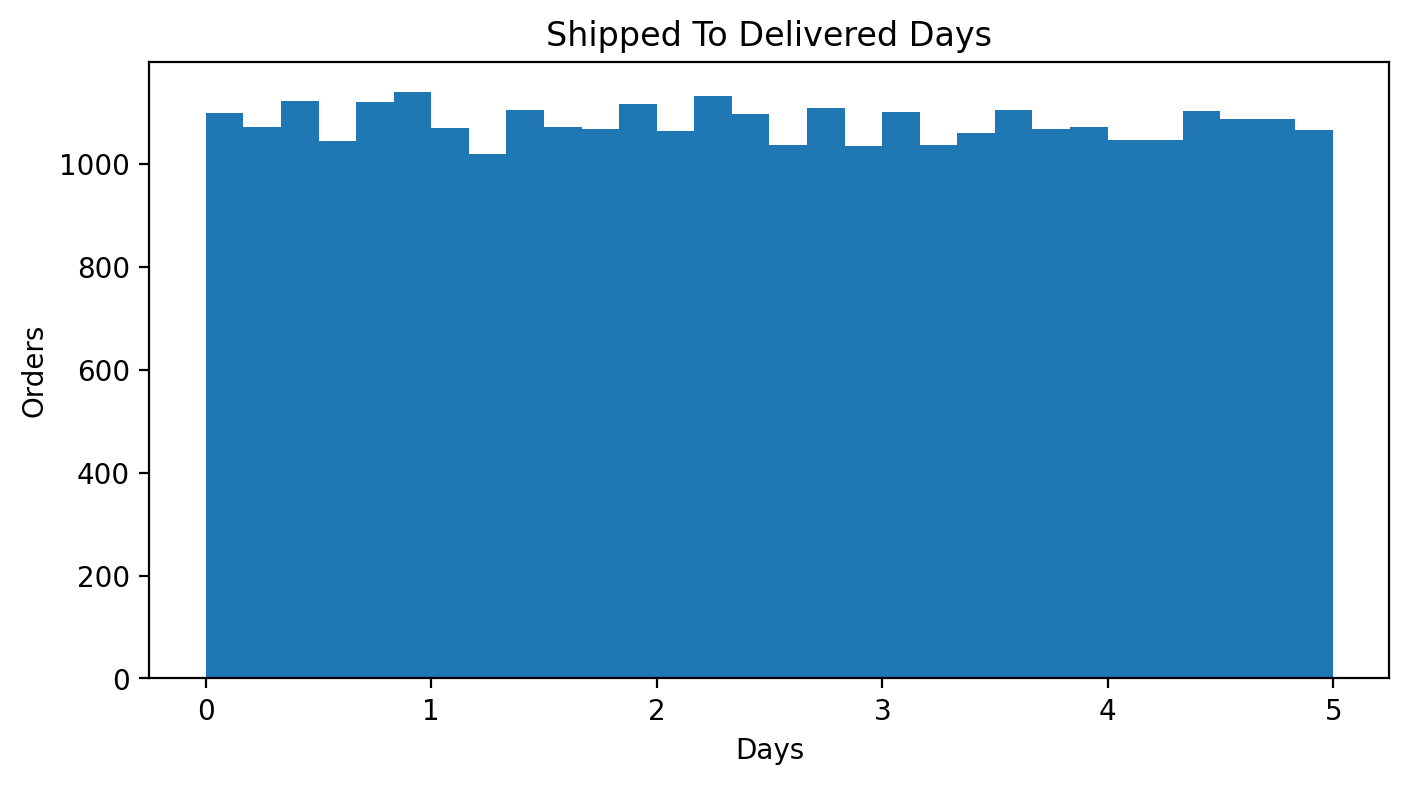

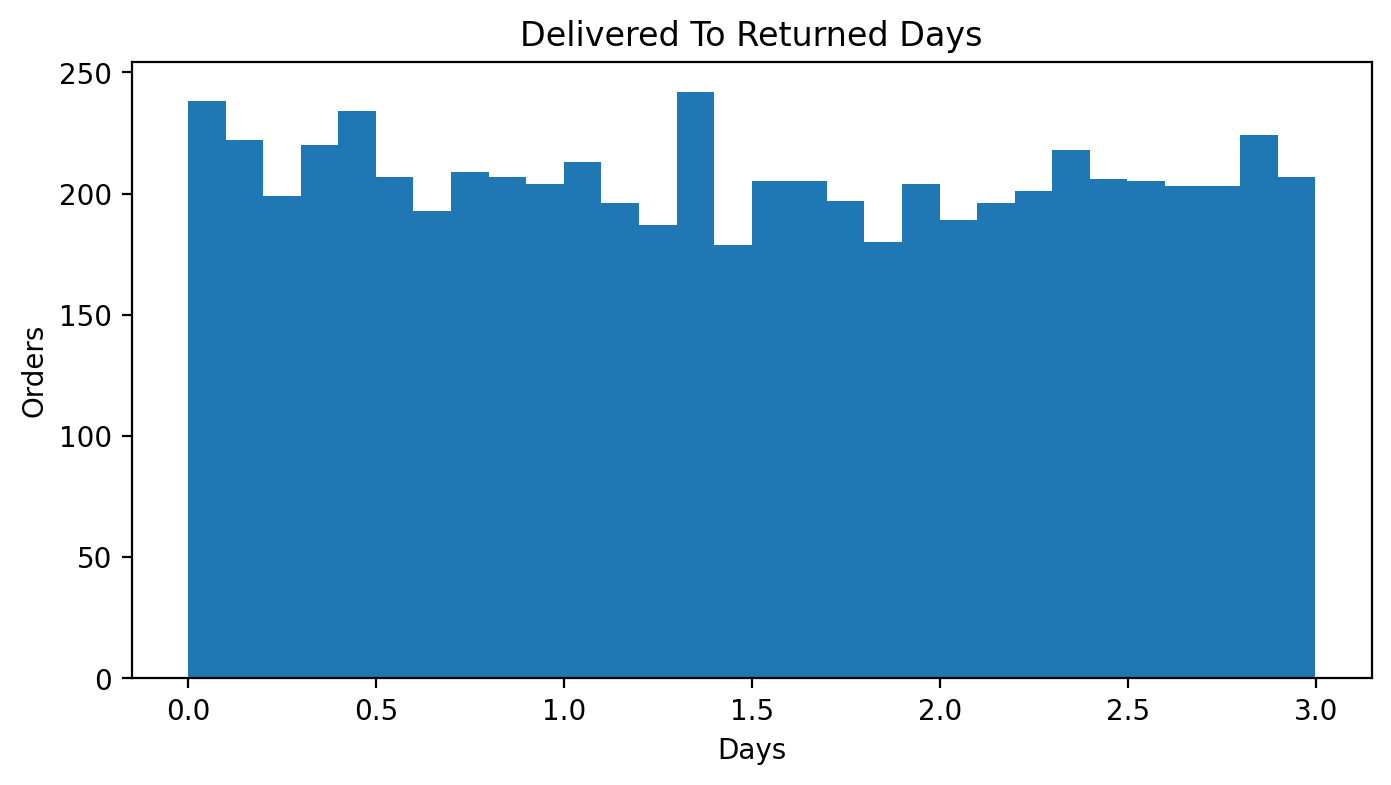


Order funnel:


,stage,count,pct_of_all_orders,seq_conversion_%
0,created,82480,100.00,NaN
1,shipped,50937,61.76,61.76
2,delivered,32426,39.31,63.66
3,returned,6193,7.51,19.10
4,canceled,0,0.00,0.00


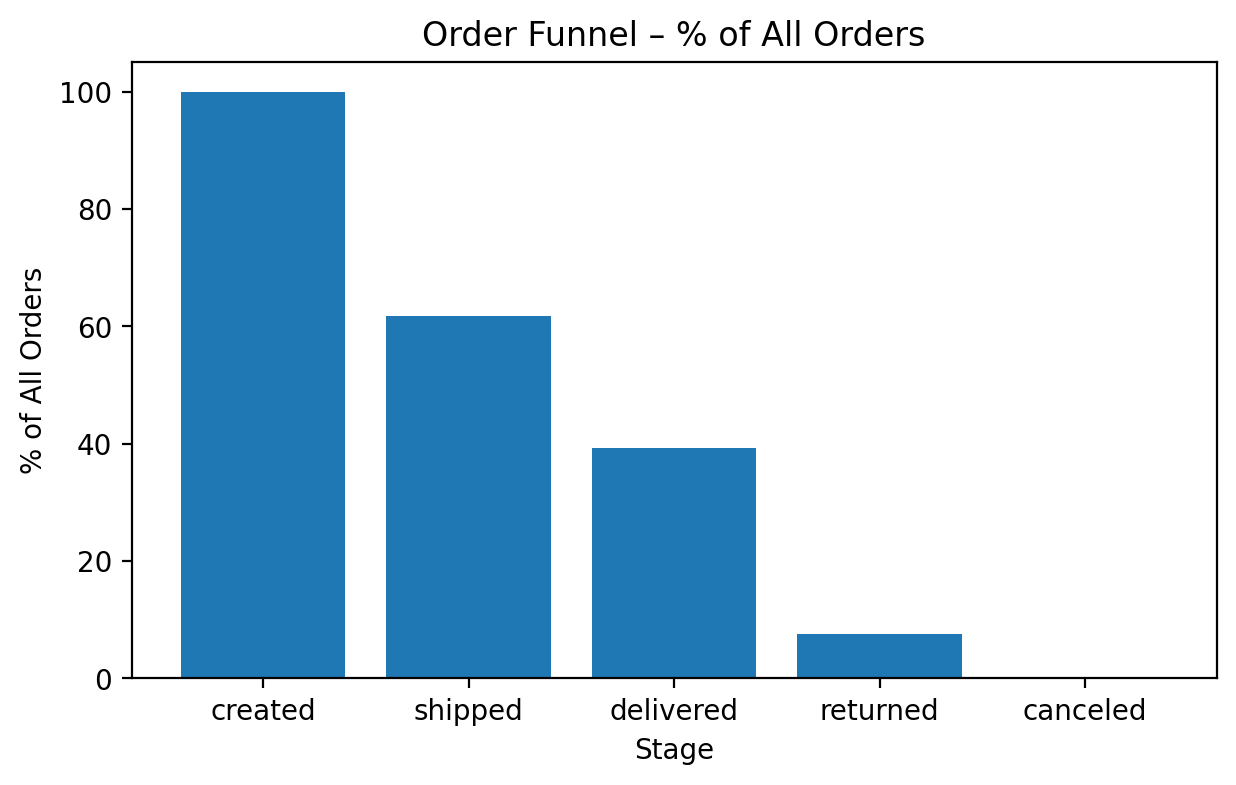

In [86]:
# detect time columns
event_map = {
    "created_at":   ["created_at","created","order_created","placed","ordered","order_date"],
    "paid_at":      ["paid_at","paid","payment_date"],
    "shipped_at":   ["shipped_at","shipped","ship_date","shipment_date"],
    "delivered_at": ["delivered_at","delivered","delivery_date"],
    "returned_at":  ["returned_at","returned","return_date","rma_date"],
    "canceled_at":  ["canceled_at","cancelled_at","cancelled","canceled","cancel_date"],
}
event_cols = {k: first_match(orders, v) for k,v in event_map.items()}

# ---- TZ normalization: parse EVERYTHING as UTC (tz-aware) so subtraction is safe ----
def to_dt_utc(s):
    return pd.to_datetime(s, errors="coerce", utc=True)

for k, col in event_cols.items():
    if col:
        orders[col] = to_dt_utc(orders[col])

# ---- Coverage table ----
def pct_non_null(df, col):
    return round(df[col].notna().mean()*100, 2) if col and col in df.columns else np.nan

coverage = pd.DataFrame({
    "milestone": list(event_cols.keys()),
    "percent":   [pct_non_null(orders, c) for c in event_cols.values()]
})
print("\nOrder milestone coverage (% non-null):")
display(coverage)
coverage.to_csv(os.path.join(OUT_DIR, "order_timeline_coverage_full.csv"), index=False)

fig = plt.figure(figsize=(7,4))
plt.bar(coverage["milestone"].astype(str), coverage["percent"])
plt.title("Order Timeline Coverage (%)"); plt.xlabel("Milestone"); plt.ylabel("Percent of Orders")
finish_fig(fig, "order_timeline_coverage_full.png")

# ---- Latencies (days) between key pairs (non-negative only) ----
pairs = [
    ("created_at","paid_at","created_to_paid_days"),
    ("created_at","shipped_at","created_to_shipped_days"),
    ("shipped_at","delivered_at","shipped_to_delivered_days"),
    ("delivered_at","returned_at","delivered_to_returned_days"),
    ("created_at","canceled_at","created_to_canceled_days"),
]

lat_cols = []
for a,b,name in pairs:
    A = event_cols.get(a); B = event_cols.get(b)
    if A and B:
        # Both series are tz-aware (UTC) now, subtraction is safe
        lat = (orders[B] - orders[A]) / pd.Timedelta(days=1)
        orders[name] = lat.where(lat >= 0)  # keep non-negative intervals
        lat_cols.append(name)

if lat_cols:
    lat_summary = orders[lat_cols].describe(percentiles=[0.5,0.9,0.95]).T.round(2)
    print("\nLatency summary (days):")
    display(lat_summary)
    lat_summary.to_csv(os.path.join(OUT_DIR, "order_latency_summary_full.csv"))

    # histogram for each latency
    for c in lat_cols:
        s = orders[c].dropna()
        if not s.empty:
            fig = plt.figure(figsize=(8,4))
            plt.hist(s, bins=30)
            plt.title(c.replace("_"," ").title())
            plt.xlabel("Days"); plt.ylabel("Orders")
            finish_fig(fig, f"hist_{c}.png")
else:
    print("\nNo usable timestamp pairs to compute latencies.")

# ---- Simple order funnel (created -> shipped -> delivered, plus returned/canceled) ----
created_col   = event_cols.get("created_at")
shipped_col   = event_cols.get("shipped_at")
delivered_col = event_cols.get("delivered_at")
returned_col  = event_cols.get("returned_at")
canceled_col  = event_cols.get("canceled_at")

N = len(orders)
n_created   = int(orders[created_col].notna().sum())   if created_col   else 0
n_shipped   = int(orders[shipped_col].notna().sum())   if shipped_col   else 0
n_delivered = int(orders[delivered_col].notna().sum()) if delivered_col else 0
n_returned  = int(orders[returned_col].notna().sum())  if returned_col  else 0
n_canceled  = int(orders[canceled_col].notna().sum())  if canceled_col  else 0

funnel = pd.DataFrame({
    "stage": ["created","shipped","delivered","returned","canceled"],
    "count": [n_created, n_shipped, n_delivered, n_returned, n_canceled],
})
funnel["pct_of_all_orders"] = (funnel["count"]/N*100).round(2)
# sequential conversion rates
funnel["seq_conversion_%"] = [
    np.nan,
    round((n_shipped / n_created * 100), 2) if n_created else np.nan,
    round((n_delivered / n_shipped * 100), 2) if n_shipped else np.nan,
    round((n_returned / n_delivered * 100), 2) if n_delivered else np.nan,
    round((n_canceled / n_created * 100), 2) if n_created else np.nan,
]
print("\nOrder funnel:")
display(funnel)
funnel.to_csv(os.path.join(OUT_DIR, "order_funnel.csv"), index=False)

# quick bar for pct_of_all_orders
fig = plt.figure(figsize=(7,4))
plt.bar(funnel["stage"], funnel["pct_of_all_orders"])
plt.title("Order Funnel – % of All Orders")
plt.xlabel("Stage"); plt.ylabel("% of All Orders")
finish_fig(fig, "order_funnel_pct_of_all.png")

,country,customers
0,China,34005
1,United States,22343
2,Brasil,14582
3,South Korea,5338
4,France,4774
5,United Kingdom,4669
6,Germany,4145
7,Spain,4045
8,Japan,2424
9,Australia,2227


,country,revenue
3,China,277027.169338
13,United States,181994.589525
2,Brasil,120064.839712
10,South Korea,44942.639891
6,France,39523.749901
12,United Kingdom,36888.449899
11,Spain,34069.949890
7,Germany,33978.139893
8,Japan,19612.479958
0,Australia,17912.309955


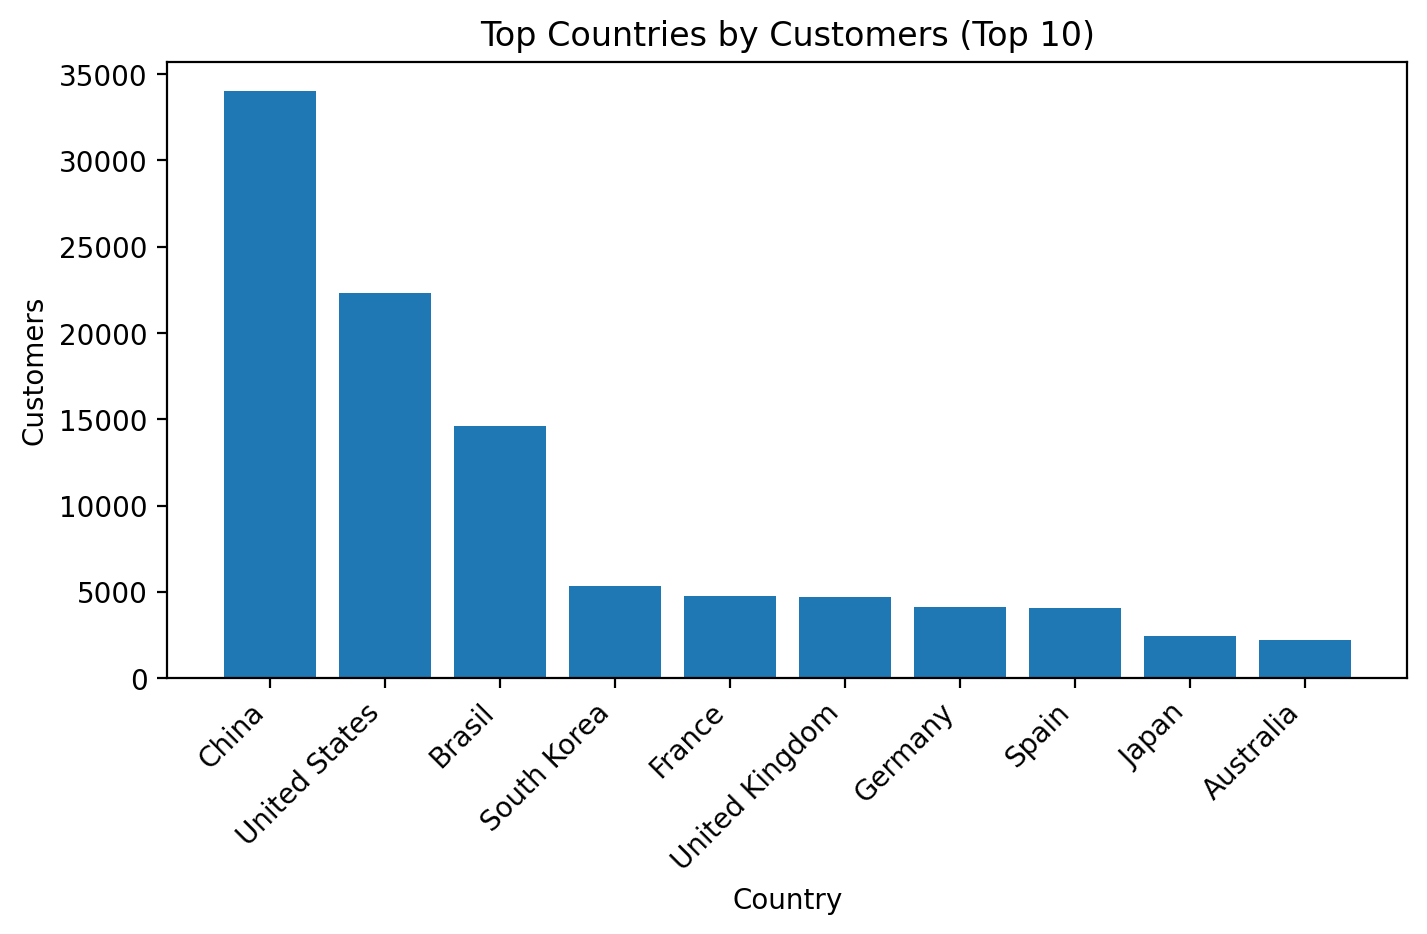

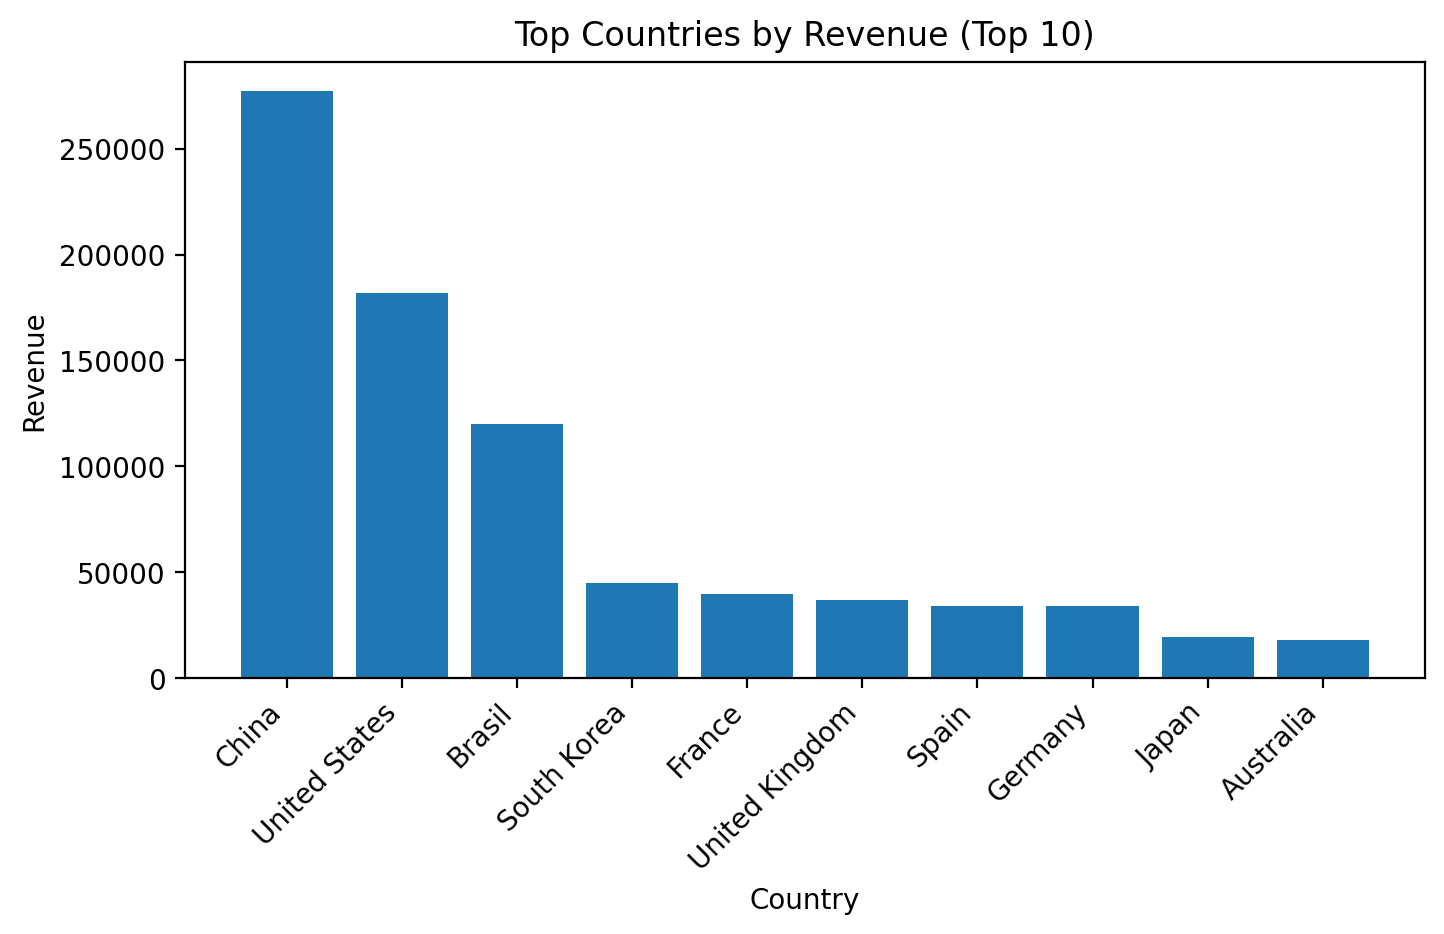

In [87]:
# ==================================================================================
# 4) Country: most customers & most sales (+ charts)
# ==================================================================================
country_col = pick_first(detect_columns(users, ["country","country_code","nation","geo_country"]))
if country_col:
    cust_by_country = users[country_col].value_counts(dropna=False).rename_axis(country_col).reset_index(name="customers")
    display(cust_by_country.head(20))
    cust_by_country.to_csv(os.path.join(OUT_DIR, "customers_by_country.csv"), index=False)

    if order_user_fk and user_id and user_id in users.columns:
        ou_geo = orders_users.merge(users[[user_id, country_col]], left_on=order_user_fk, right_on=user_id, how="left")
        ou_geo["order_revenue"] = pd.to_numeric(ou_geo["order_revenue"], errors="coerce").fillna(0)
        sales_by_country = ou_geo.groupby(country_col)["order_revenue"].sum().reset_index(name="revenue").sort_values("revenue", ascending=False)
        display(sales_by_country.head(20))
        sales_by_country.to_csv(os.path.join(OUT_DIR, "revenue_by_country.csv"), index=False)
    else:
        sales_by_country = pd.DataFrame(columns=[country_col,"revenue"])

    if not cust_by_country.empty:
        fig = plt.figure(figsize=(8,4))
        head = cust_by_country.head(10)
        plt.bar(head[country_col].astype(str), head["customers"])
        plt.xticks(rotation=45, ha="right")
        plt.title("Top Countries by Customers (Top 10)")
        plt.xlabel("Country"); plt.ylabel("Customers")
        finish_fig(fig, "top_countries_customers.png")

    if not sales_by_country.empty:
        fig = plt.figure(figsize=(8,4))
        head = sales_by_country.head(10)
        plt.bar(head[country_col].astype(str), head["revenue"])
        plt.xticks(rotation=45, ha="right")
        plt.title("Top Countries by Revenue (Top 10)")
        plt.xlabel("Country"); plt.ylabel("Revenue")
        finish_fig(fig, "top_countries_revenue.png")

,age_bucket,customers
6,<18,10006
4,18-24,11783
3,25-34,16925
2,35-44,16967
0,45-54,17044
1,55-64,17001
5,65+,10274


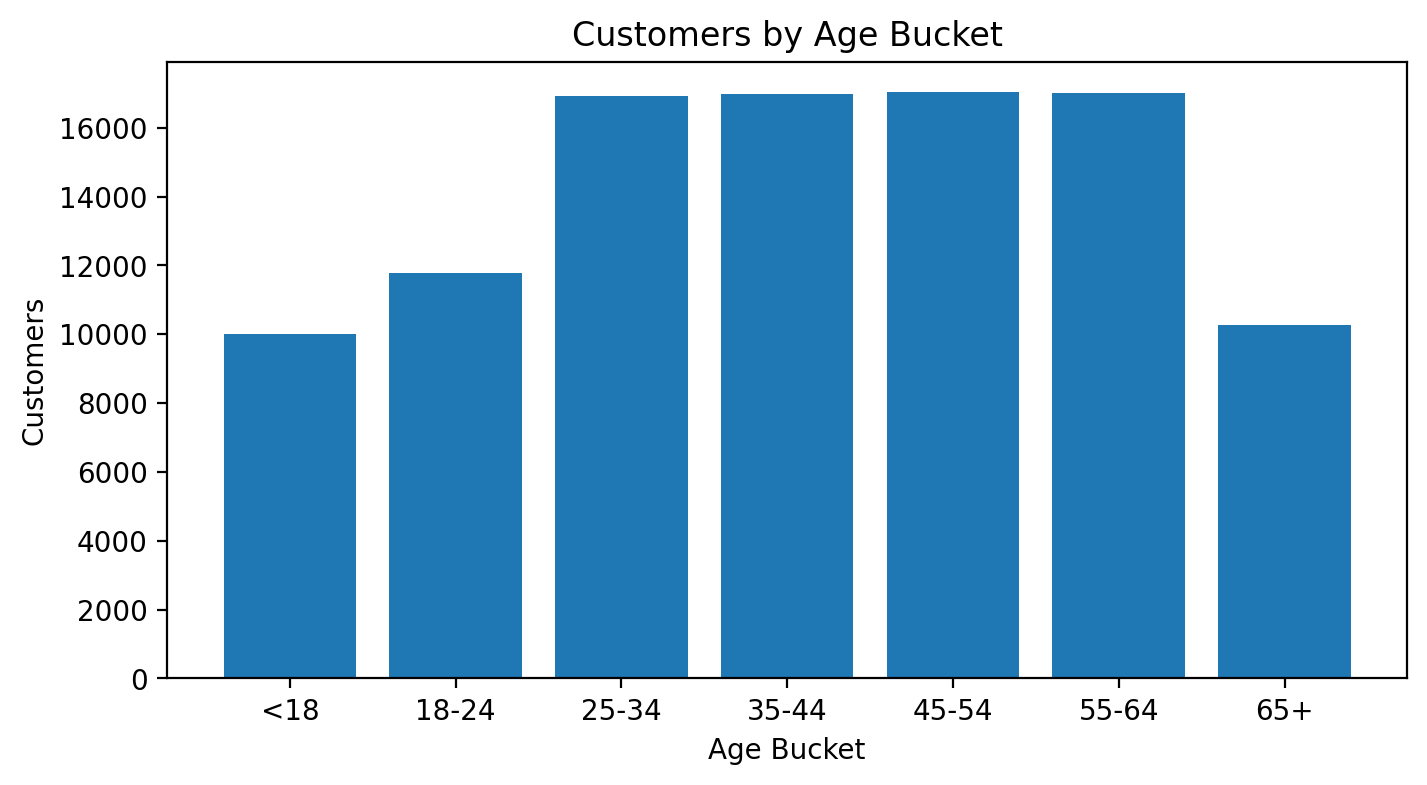

In [88]:
# ==================================================================================
# 5) Gender split & age buckets (+ charts)
# ==================================================================================
# gender_col = pick_first(detect_columns(users, ["gender","sex"]))
# if gender_col:
#     gender_counts = users[gender_col].value_counts(dropna=False).rename_axis(gender_col).reset_index(name="customers")
#     display(gender_counts)
#     gender_counts.to_csv(os.path.join(OUT_DIR, "customers_by_gender.csv"), index=False)

#     fig = plt.figure(figsize=(6,4))
#     plt.bar(gender_counts[gender_col].astype(str), gender_counts["customers"])
#     plt.title("Customers by Gender"); plt.xlabel("Gender"); plt.ylabel("Customers")
#     finish_fig(fig, "customers_by_gender.png")

# Age buckets (if DOB present)
dob_col = pick_first(detect_columns(users, ["dob","birth","birthday","date_of_birth"]))
if dob_col:
    users[dob_col] = pd.to_datetime(users[dob_col], errors="coerce")
    ref = pd.Timestamp.today()
    users["age_years"] = ((ref - users[dob_col]).dt.days/365.25)

if "age_years" in users.columns and users["age_years"].notna().any():
    bins = [0,18,25,35,45,55,65,120]
    labels = ["<18","18-24","25-34","35-44","45-54","55-64","65+"]
    users["age_bucket"] = pd.cut(users["age_years"], bins=bins, labels=labels, right=False, include_lowest=True)
    age_buckets = (users["age_bucket"].value_counts(dropna=False)
                   .rename_axis("age_bucket").reset_index(name="customers")
                   .sort_values("age_bucket"))
    display(age_buckets)
    age_buckets.to_csv(os.path.join(OUT_DIR, "customers_by_age_bucket.csv"), index=False)

    fig = plt.figure(figsize=(8,4))
    plt.bar(age_buckets["age_bucket"].astype(str), age_buckets["customers"])
    plt.title("Customers by Age Bucket"); plt.xlabel("Age Bucket"); plt.ylabel("Customers")
    finish_fig(fig, "customers_by_age_bucket.png")


,category,revenue
6,Intimates,95024.359863
25,Underwear,89059.589956
24,Tops & Tees,81710.990051
0,Accessories,71493.639745
18,Socks,64886.459913
17,Sleep & Lounge,63177.959730
1,Active,56819.429904
15,Shorts,54335.489898
19,Socks & Hosiery,38252.889889
23,Swim,33065.709837


,category,quantity
6,Intimates,5400.0
0,Accessories,4551.0
18,Socks,4144.0
25,Underwear,4104.0
24,Tops & Tees,3944.0
17,Sleep & Lounge,2952.0
1,Active,2884.0
15,Shorts,2657.0
19,Socks & Hosiery,2636.0
14,Plus,1879.0


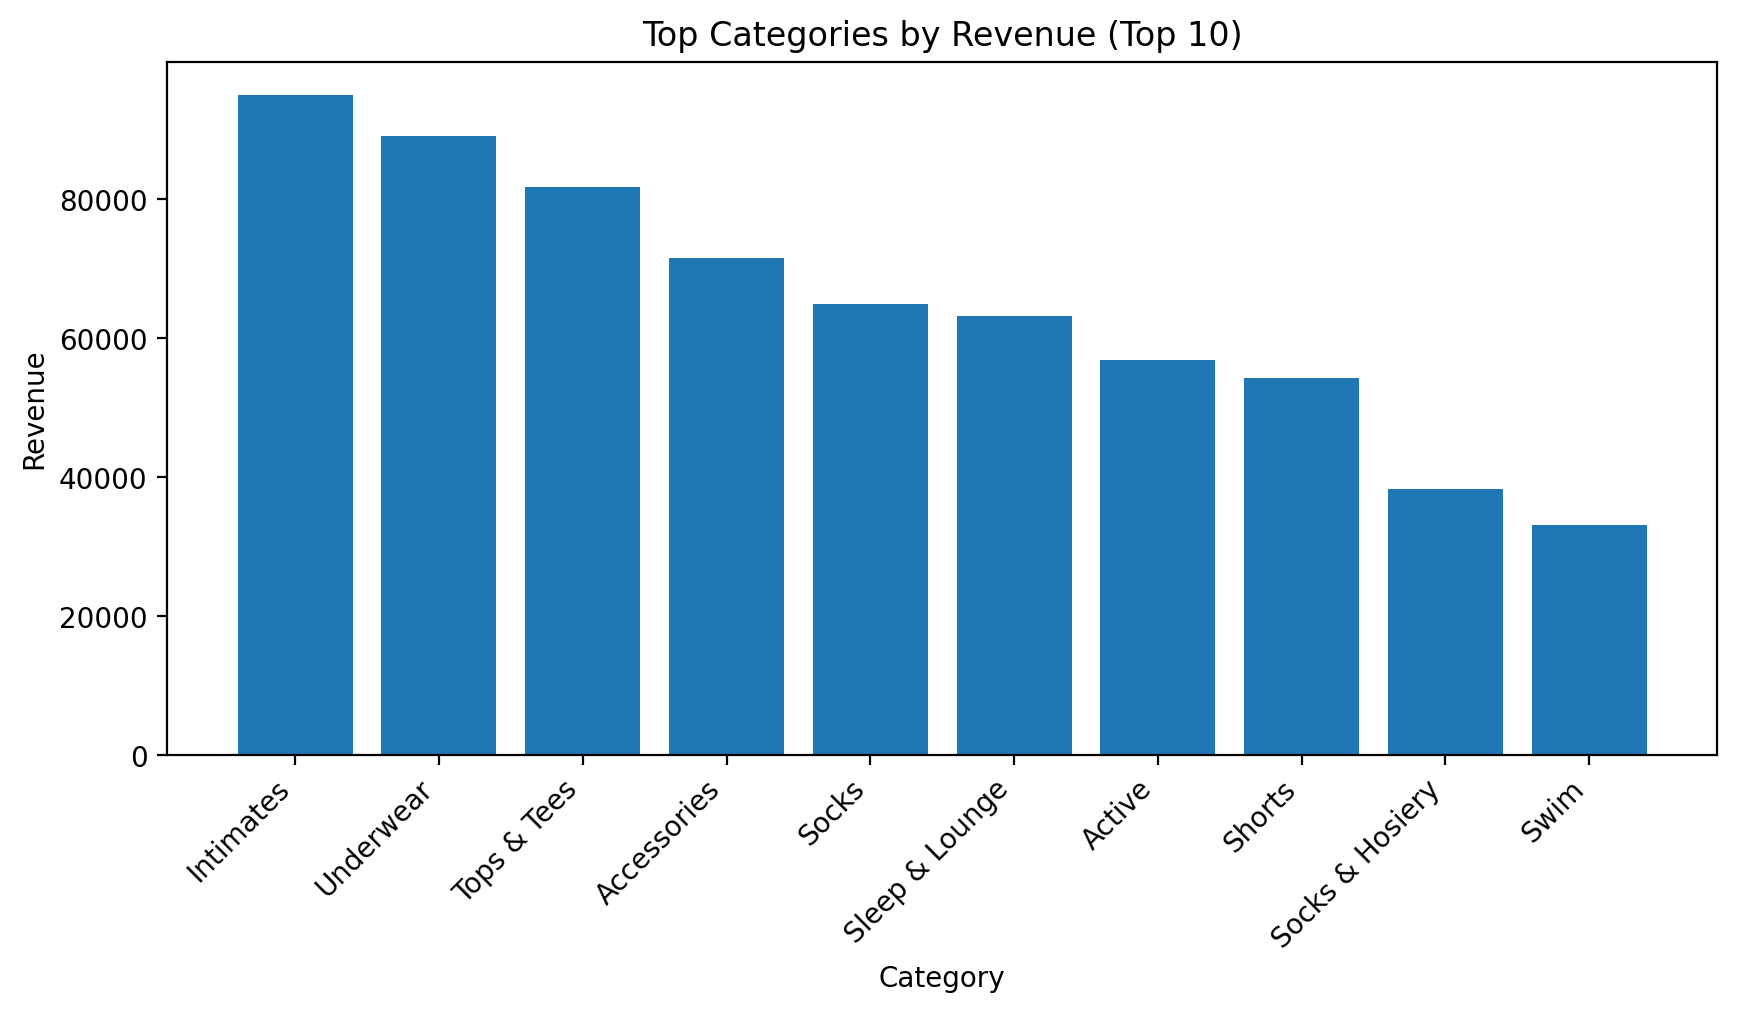

✔ Category CSVs/plot saved under: ./out


In [90]:
# Fallback for finish_fig if you don't already have it
if 'finish_fig' not in globals():
    def finish_fig(fig, filename=None):
        if 'OUT_DIR' in globals() and filename:
            os.makedirs(OUT_DIR, exist_ok=True)
            fig.savefig(os.path.join(OUT_DIR, filename), bbox_inches="tight", dpi=150)
        plt.show(); plt.close(fig)

def _first(df, *names):
    """Return the first col name that exists in df, else None."""
    for n in names:
        if n in df.columns: return n
    return None

# ---- Work from raw order_items
oi = order_items.copy()

# 1) Quantity: use a quantity-like column if present; else treat each row as 1 unit
qty_col = None
for nm in ["num_of_item","num_of_items","quantity","qty","count","units","item_count"]:
    if nm in oi.columns:
        qty_col = nm; break
if qty_col is None:
    oi["__qty"] = 1.0
    qty_col = "__qty"
else:
    oi[qty_col] = pd.to_numeric(oi[qty_col], errors="coerce").fillna(1.0)

# 2) Price → line_revenue (assume sale_price is unit price; multiply by qty)
price_col = _first(oi, "sale_price", "unit_price", "price", "amount", "line_total", "subtotal")
if price_col:
    oi["line_revenue"] = pd.to_numeric(oi[price_col], errors="coerce").fillna(0.0) * oi[qty_col]
else:
    oi["line_revenue"] = 0.0

# 3) Filter returns/cancels when detectable
bad = pd.Series(False, index=oi.index)
if "status" in oi.columns:
    bad |= oi["status"].astype(str).str.lower().str.contains(r"return|cancel|refund|chargeback")
if "returned_at" in oi.columns:
    bad |= pd.to_datetime(oi["returned_at"], errors="coerce").notna()
oi_good = oi.loc[~bad].copy()

# 4) Product FK & category column
oi_pid = _first(oi_good, "product_id", "sku", "asin")
assert oi_pid is not None, "No product id/sku column found in order_items."

prod_id = product_id if ('product_id' in globals() and product_id in products.columns) else _first(products, "id", "product_id")
assert prod_id is not None, "No product id column found in products."

cat_col = _first(products, "category", "cat", "department", "segment")
assert cat_col is not None, "No category-like column found in products."

# 5) Join to products to bring category, then aggregate
cat_items = oi_good.merge(products[[prod_id, cat_col]], left_on=oi_pid, right_on=prod_id, how="left")

cat_rev = (cat_items.groupby(cat_col, dropna=False)["line_revenue"]
           .sum(min_count=1).reset_index(name="revenue")
           .sort_values("revenue", ascending=False))

cat_qty = (cat_items.groupby(cat_col, dropna=False)[qty_col]
           .sum(min_count=1).reset_index(name="quantity")
           .sort_values("quantity", ascending=False))

display(cat_rev.head(20)); display(cat_qty.head(20))

# 6) Save CSVs
if 'OUT_DIR' in globals():
    cat_rev.to_csv(os.path.join(OUT_DIR, "categories_by_revenue.csv"), index=False)
    cat_qty.to_csv(os.path.join(OUT_DIR, "categories_by_quantity.csv"), index=False)

# 7) Plot Top 10 categories by revenue
if not cat_rev.empty:
    head = cat_rev.head(10)
    fig = plt.figure(figsize=(10, 4.5))
    plt.bar(head[cat_col].astype(str), head["revenue"])
    plt.xticks(rotation=45, ha="right")
    plt.title("Top Categories by Revenue (Top 10)")
    plt.xlabel("Category"); plt.ylabel("Revenue")
    finish_fig(fig, "top_categories_revenue.png")

print("✔ Category CSVs/plot saved under:", globals().get("OUT_DIR", "./"))

In [105]:
# best customers
# ==== Top customer by AOV (Average Order Value) and their top product ====
import numpy as np
import pandas as pd

# --- Config ---
MIN_ORDERS = 1   # set to 2+ if you want to ignore one-order outliers

# --- Tolerant helpers ---
def _first(df, *names):
    """Return the first column name that exists in df (or None)."""
    for n in names:
        if n in df.columns:
            return n
    return None

def _numericize(df, cols):
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

# --- Keys (based on your schema) ---
u_id  = _first(users, "id", "user_id", "customer_id", "buyer_id", "account_id")
p_id  = _first(products, "id", "product_id", "sku", "asin")
o_id  = _first(orders, "order_id", "id")
ou_fk = _first(orders, "user_id", "customer_id", "buyer_id", "account_id")
assert u_id and p_id and o_id and ou_fk, "Missing required key columns in users/products/orders."

# --- Build per-order revenue from order_items (filter returns/cancels) ---
oi = order_items.copy()

qty_col   = _first(oi, "num_of_item","num_of_items","quantity","qty","item_count","items_count","count","units")
price_col = _first(oi, "sale_price","unit_price","price","amount","line_total","subtotal")
if qty_col is None:
    oi["__qty"] = 1.0; qty_col = "__qty"
else:
    _numericize(oi, [qty_col]); oi[qty_col] = oi[qty_col].fillna(1.0)

if price_col:
    _numericize(oi, [price_col])
    oi["line_revenue"] = oi[price_col].fillna(0.0) * oi[qty_col]
else:
    oi["line_revenue"] = 0.0

# remove returns/cancels when detectable
bad = pd.Series(False, index=oi.index)
if "status" in oi.columns:
    bad |= oi["status"].astype(str).str.lower().str.contains(r"return|cancel|refund|chargeback")
if "returned_at" in oi.columns:
    bad |= pd.to_datetime(oi["returned_at"], errors="coerce").notna()
oi_good = oi.loc[~bad].copy()

oi_order_id = _first(oi, "order_id")
assert oi_order_id, "order_items must include an order_id column."

rev_per_order = oi_good.groupby(oi_order_id)["line_revenue"].sum()

# --- Enrich orders with revenue ---
orders_enriched = orders.copy()
orders_enriched["order_revenue"] = orders_enriched[o_id].map(rev_per_order).fillna(0.0)

# --- Customer AOV: total revenue / #orders ---
cust = (orders_enriched.groupby(ou_fk, as_index=False)
        .agg(orders=(o_id, "nunique"),
             revenue=("order_revenue", "sum")))
cust["aov"] = cust["revenue"] / cust["orders"].replace(0, np.nan)

# choose top by AOV (with MIN_ORDERS filter)
cand = cust[cust["orders"] >= MIN_ORDERS].copy()
assert not cand.empty, "No customers meet the MIN_ORDERS filter."
top_row = cand.sort_values("aov", ascending=False).iloc[0]
top_customer_id = top_row[ou_fk]

# --- A readable customer label (email or name; fallback to id) ---
display_cols = [c for c in [u_id, "email", "first_name", "last_name"] if c in users.columns]
cust_label = str(top_customer_id)
if display_cols:
    urow = users.loc[users[u_id] == top_customer_id]
    if not urow.empty:
        fn = urow.get("first_name", pd.Series([""])).iloc[0] if "first_name" in urow.columns else ""
        ln = urow.get("last_name", pd.Series([""])).iloc[0] if "last_name" in urow.columns else ""
        em = urow.get("email", pd.Series([""])).iloc[0] if "email" in urow.columns else ""
        if fn or ln:
            cust_label = f"{fn} {ln}".strip()
        elif em:
            cust_label = em

# --- Their top product (by quantity and by revenue) ---
# Find this customer's order_ids
cust_order_ids = set(orders_enriched.loc[orders_enriched[ou_fk] == top_customer_id, o_id])

# Customer's items
oi_cust = oi_good[oi_good[oi_order_id].isin(cust_order_ids)].copy()
prod_fk = _first(oi_cust, "product_id", "sku", "asin")
assert prod_fk, "order_items must have a product id/sku column."

# Most ordered product (quantity)
top_prod_qty_id = (oi_cust.groupby(prod_fk)[qty_col]
                   .sum()
                   .sort_values(ascending=False)
                   .head(1)
                   .index[0])

# Highest revenue product
top_prod_rev_id = (oi_cust.groupby(prod_fk)["line_revenue"]
                   .sum()
                   .sort_values(ascending=False)
                   .head(1)
                   .index[0])

# Add readable product names
prod_label_col = _first(products, "name", "title", "product_name", "sku", "brand")
if prod_label_col and p_id in products.columns:
    pname_qty = products.loc[products[p_id] == top_prod_qty_id, prod_label_col]
    pname_rev = products.loc[products[p_id] == top_prod_rev_id, prod_label_col]
    top_prod_qty_name = pname_qty.iloc[0] if not pname_qty.empty else str(top_prod_qty_id)
    top_prod_rev_name = pname_rev.iloc[0] if not pname_rev.empty else str(top_prod_rev_id)
else:
    top_prod_qty_name = str(top_prod_qty_id)
    top_prod_rev_name = str(top_prod_rev_id)

# --- Results ---
summary = pd.DataFrame({
    "top_customer_id":   [top_customer_id],
    "top_customer_label":[cust_label],
    "orders":            [int(top_row["orders"])],
    "revenue":           [float(round(top_row["revenue"], 2))],
    "aov":               [float(round(top_row["aov"], 2))],
    "top_product_by_qty_id":   [top_prod_qty_id],
    "top_product_by_qty_name": [top_prod_qty_name],
    "top_product_by_rev_id":   [top_prod_rev_id],
    "top_product_by_rev_name": [top_prod_rev_name]
})

print("Top customer by AOV (min orders =", MIN_ORDERS, ")")
display(summary)


Top customer by AOV (min orders = 1 )


,top_customer_id,top_customer_label,orders,revenue,aov,top_product_by_qty_id,top_product_by_qty_name,top_product_by_rev_id,top_product_by_rev_name
0,406.0,Karen Mason,1,113.88,113.88,1051,2B Buckle V-neck Sweater,1051,2B Buckle V-neck Sweater


# How can we boost customer loyalty and accelerate sales?

### Customer segmentation: idenify distinct customer segments based on purchasing behavior, demographics, or engagment? What are the characteristics of your most valuable or most at-risk customers?

RFM + AOV + Tenure (per customer)

Recency (recency_days)
Days since the customer’s most recent order.
Formula: recency_days = (as_of_date - last_order_date).days
Smaller is better (more recent activity).

Frequency (frequency)
Number of distinct orders in the window (not items).
Formula: frequency = count_distinct(order_id)
(Optional) normalize to time: orders_per_month = frequency / max(tenure_months, 1/30).

Monetary (monetary)
Total customer spend in the window. Use net revenue (after discounts/refunds), usually exclude tax & shipping.
Formula: monetary = sum(order_revenue).

Average Order Value (aov)
Average dollars per order.
Formula: aov = monetary / frequency (define as NA or 0 if frequency = 0).

Tenure (tenure_days)
Customer “age” with you: days since their first order up to the snapshot.
Formula: tenure_days = (as_of_date - first_order_date).days
(Alternate metric some teams use: engagement span = last_order_date − first_order_date.)

In [91]:
# ---- keys/columns ----
user_id     = pick_first(detect_columns(users,   ["user_id","id"]))
product_id  = pick_first(detect_columns(products,["product_id","id"]))
order_id    = pick_first(detect_columns(orders,  ["order_id","id"]))
order_user_fk = pick_first(detect_columns(orders, ["user_id","customer_id","buyer_id","account_id"]))

# Order date (tz-safe)
order_date_col = first_match(orders, ["order_date","created_at","created","placed","ordered","timestamp","time"])
orders[order_date_col] = pd.to_datetime(orders[order_date_col], errors="coerce", utc=True)

# Ensure we have order_revenue on orders; if not, build from order_items
if "order_revenue" not in orders.columns or orders["order_revenue"].isna().all():
    oi_order_id   = pick_first(detect_columns(order_items, ["order_id"]))
    oi_qty        = pick_first(detect_columns(order_items, ["num_of_item","num_of_items","quantity","qty","item_count","items_count","count","units"]))
    oi_price      = pick_first(detect_columns(order_items, ["unit_price","price","amount","list_price"]))
    oi_subtotal   = pick_first(detect_columns(order_items, ["subtotal","line_total","extended_price","total","amount"]))
    if oi_qty is None:
        order_items["__qty"] = 1.0; oi_qty = "__qty"
    else:
        order_items[oi_qty] = pd.to_numeric(order_items[oi_qty], errors="coerce").fillna(1.0)
    if oi_price and oi_price in order_items.columns:
        order_items["__line_revenue"] = pd.to_numeric(order_items[oi_price], errors="coerce").fillna(0) * pd.to_numeric(order_items[oi_qty], errors="coerce").fillna(0)
    elif oi_subtotal and oi_subtotal in order_items.columns:
        order_items["__line_revenue"] = pd.to_numeric(order_items[oi_subtotal], errors="coerce").fillna(0)
    else:
        order_items["__line_revenue"] = 0.0
    if oi_order_id:
        order_agg = order_items.groupby(oi_order_id, as_index=False)["__line_revenue"].sum().rename(columns={"__line_revenue":"order_revenue"})
        orders = orders.merge(order_agg, left_on=order_id, right_on=oi_order_id, how="left")

# ---- Build orders_users with a readable display (email/name if present) ----
user_display = pick_first([c for c in users.columns if any(x in c for x in ["email","name","full_name","username"])], default=user_id)
orders_users = orders.copy()
if order_user_fk and user_id and user_id in users.columns:
    orders_users = orders_users.merge(users[[user_id, user_display]], left_on=order_user_fk, right_on=user_id, how="left")


In [92]:
How we define customer segments (RFM + AOV + Tenure)

Snapshot: compute everything as-of S (we set S = last_order + 1 day).

Recency (recency_days): days since last order → S − last_order_date (smaller = better).

Frequency (frequency): distinct orders up to S → count_distinct(order_id).

Monetary (monetary): net revenue up to S (excludes returns/cancels) → sum(order_revenue).

Average Order Value (aov): monetary / frequency (0/NA if frequency=0).

Tenure (tenure_days): S − first_order_date.

Turning R/F/M into scores (1..5)

Compute quintiles (20/40/60/80th percentiles) across all customers.

Recency: lower is better → invert to score (most recent → 5).

Frequency & Monetary: higher is better → more orders/spend → 5.

Missing values default to a neutral 3.

Segment rules (apply in this order; first match wins)

VIP: r ≥ 4 AND f ≥ 4 AND m ≥ 4

Loyal: r ≥ 4 AND (f ≥ 4 OR m ≥ 4)

Potential Loyalist: r ≥ 3 AND f ≥ 3

At Risk: r ≤ 2 AND (f ≥ 3 OR m ≥ 3) (good history, poor recency)

Dormant: r ≤ 2 AND f ≤ 2 AND m ≤ 2

Regulars: everyone else


Text(0.5, 0, 'Segment')

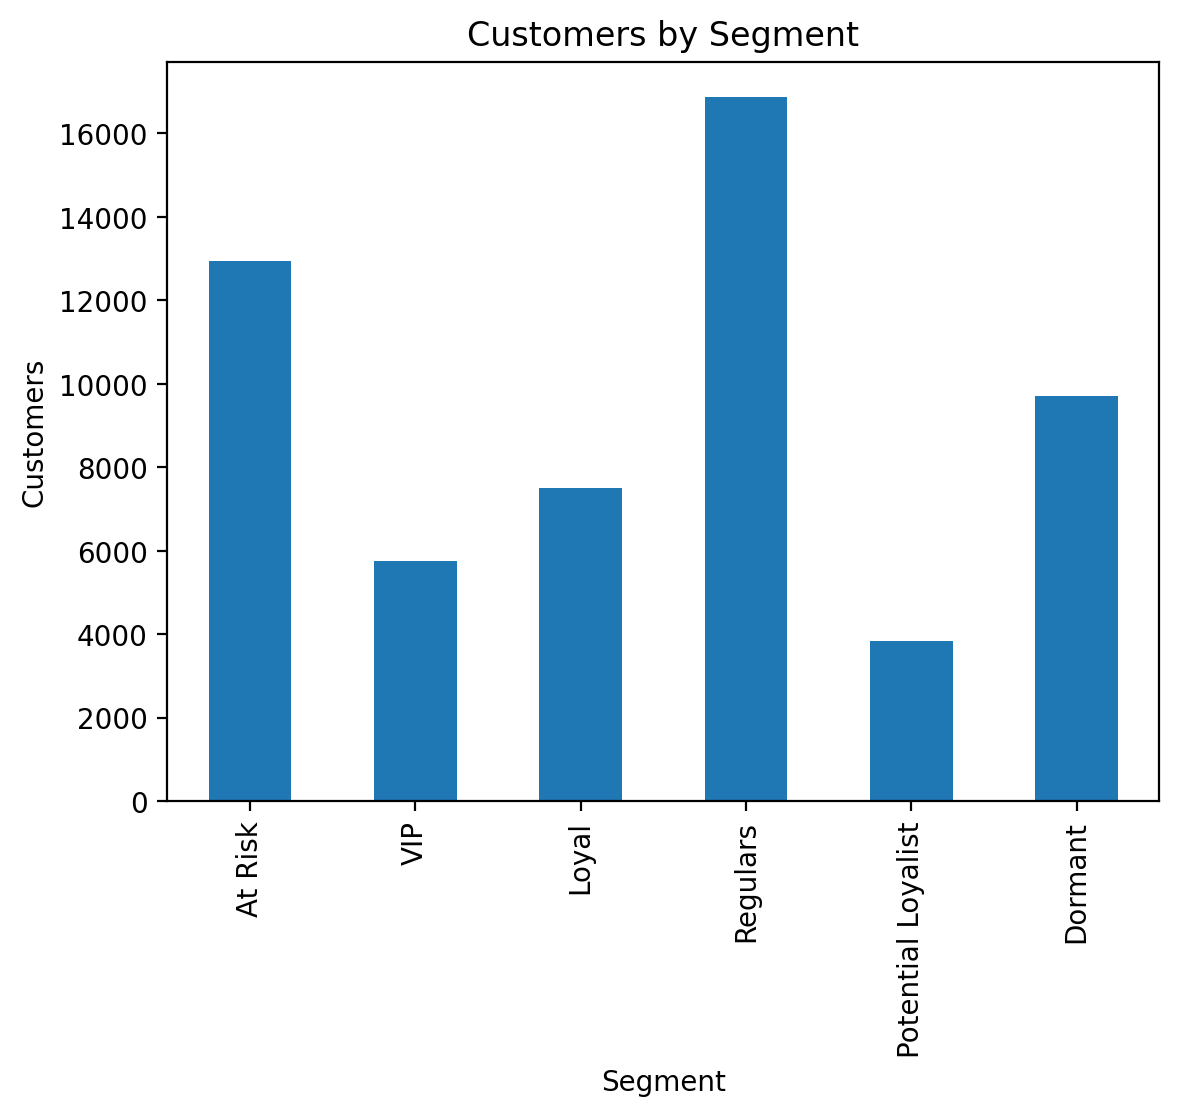

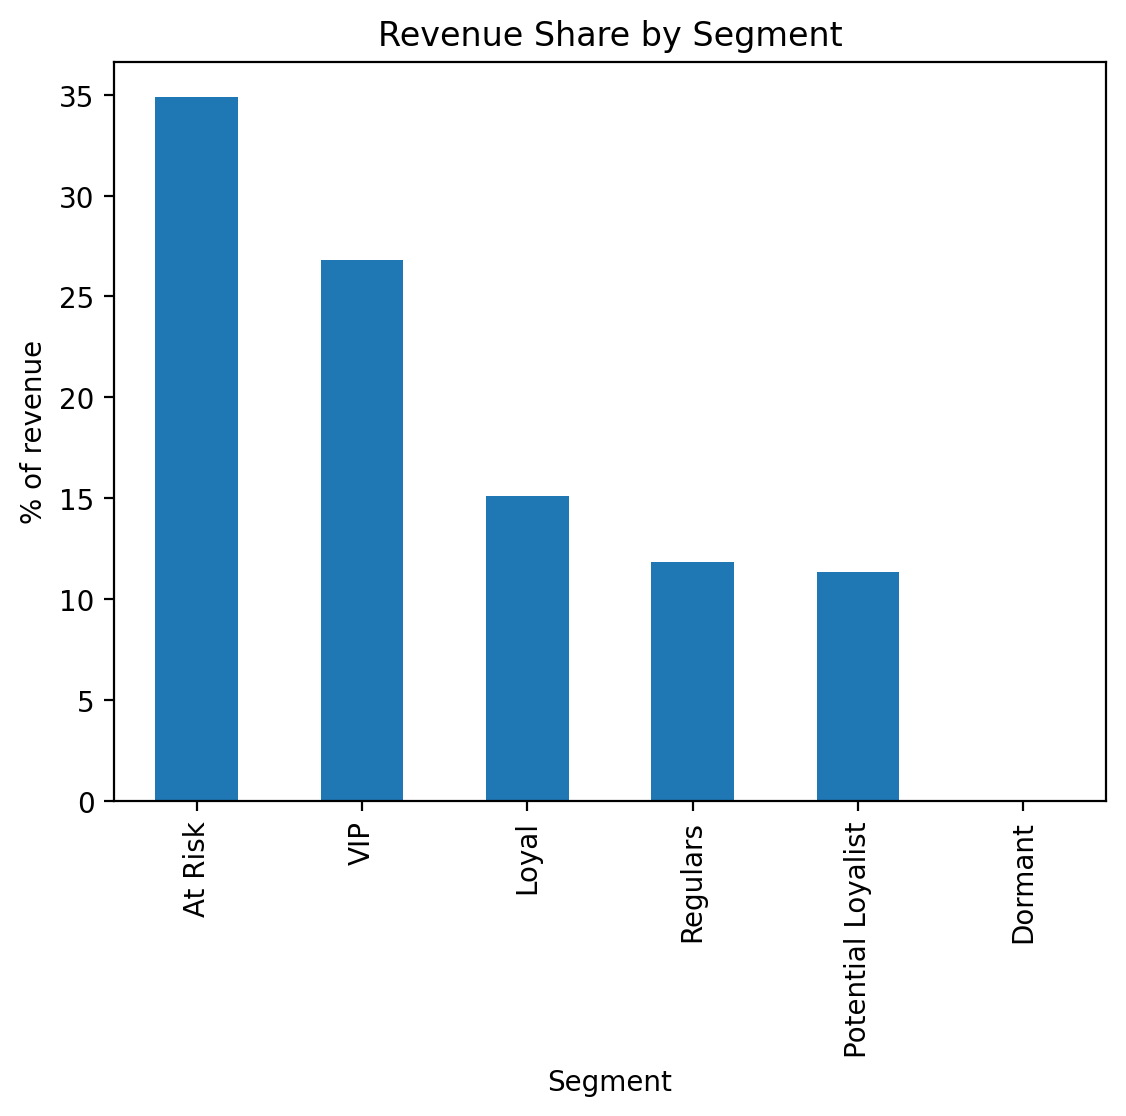

In [93]:
# 1) Segment size & revenue share
seg_orders = orders_users.merge(rfm[[order_user_fk, "segment"]], on=order_user_fk, how="left")
seg_rev = seg_orders.groupby("segment")["order_revenue"].sum().sort_values(ascending=False)
seg_cnt = rfm["segment"].value_counts().reindex(seg_rev.index)

plt.figure()
seg_cnt.plot(kind="bar")
plt.title("Customers by Segment"); plt.ylabel("Customers"); plt.xlabel("Segment")

plt.figure()
(seg_rev / seg_rev.sum() * 100).plot(kind="bar")
plt.title("Revenue Share by Segment"); plt.ylabel("% of revenue"); plt.xlabel("Segment")

Text(0.5, 1.0, 'Avg Monetary by Frequency & Recency bins')

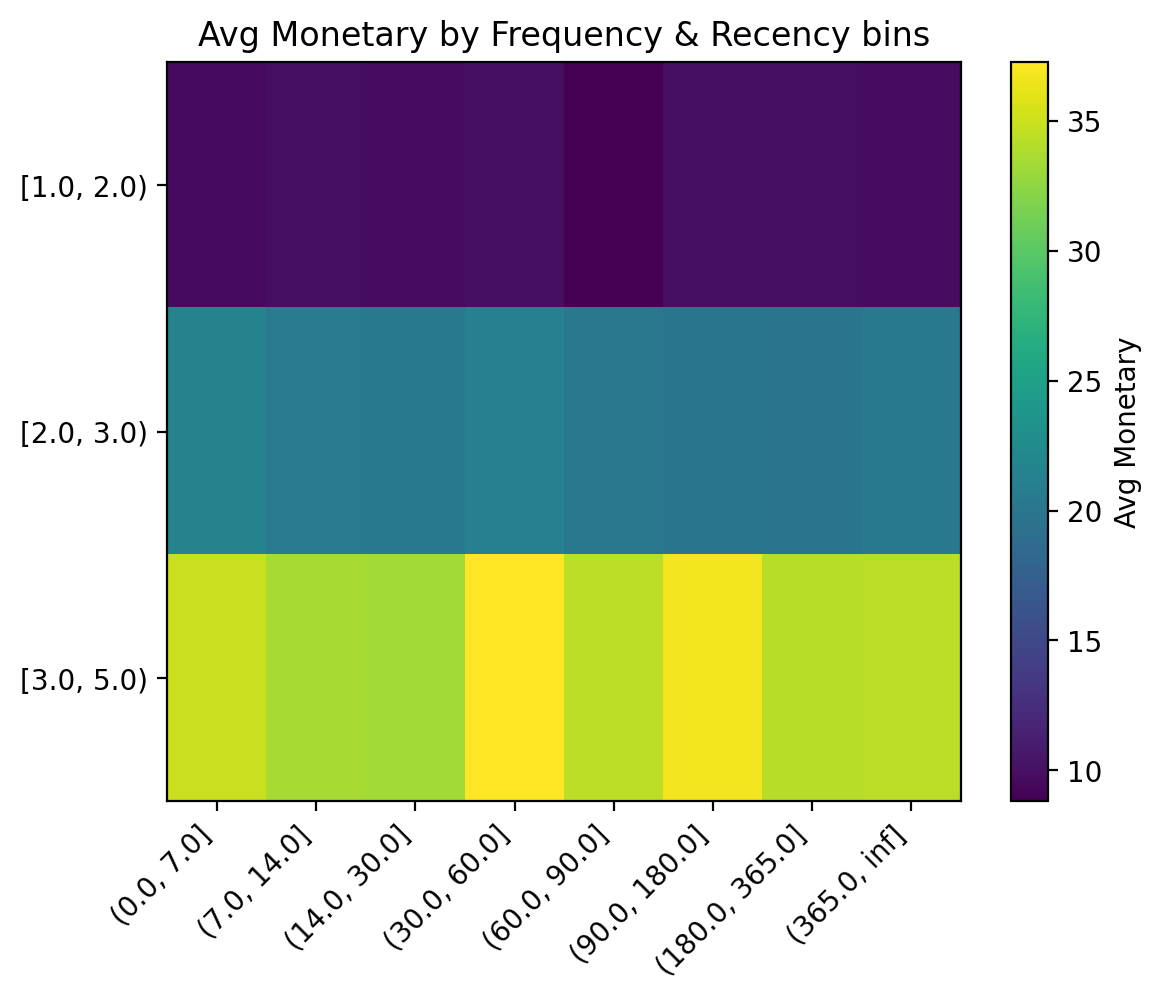

In [94]:
#3) R×F heatmap of Avg Monetary
r_bins = [0,7,14,30,60,90,180,365, np.inf]
f_bins = [1,2,3,5,8,13,21, np.inf]
tmp = rfm.copy()
tmp["r_bin"] = pd.cut(tmp["recency_days"], r_bins, right=True)
tmp["f_bin"] = pd.cut(tmp["frequency"], f_bins, right=False)
heat = tmp.pivot_table(index="f_bin", columns="r_bin", values="monetary", aggfunc="mean")

plt.figure()
plt.imshow(heat, aspect="auto")
plt.xticks(range(len(heat.columns)), [str(c) for c in heat.columns], rotation=45, ha="right")
plt.yticks(range(len(heat.index)), [str(i) for i in heat.index])
plt.colorbar(label="Avg Monetary")
plt.title("Avg Monetary by Frequency & Recency bins")

Text(0, 0.5, 'Total Monetary')

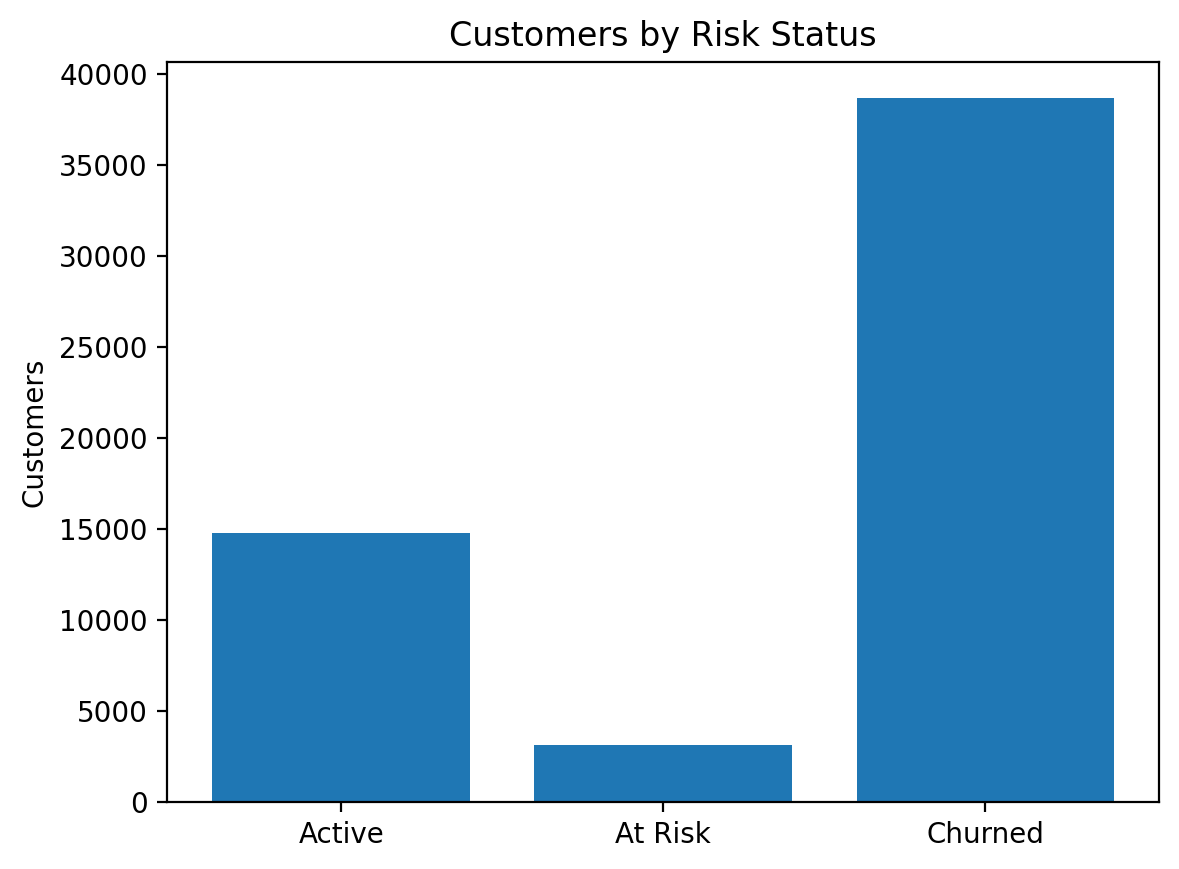

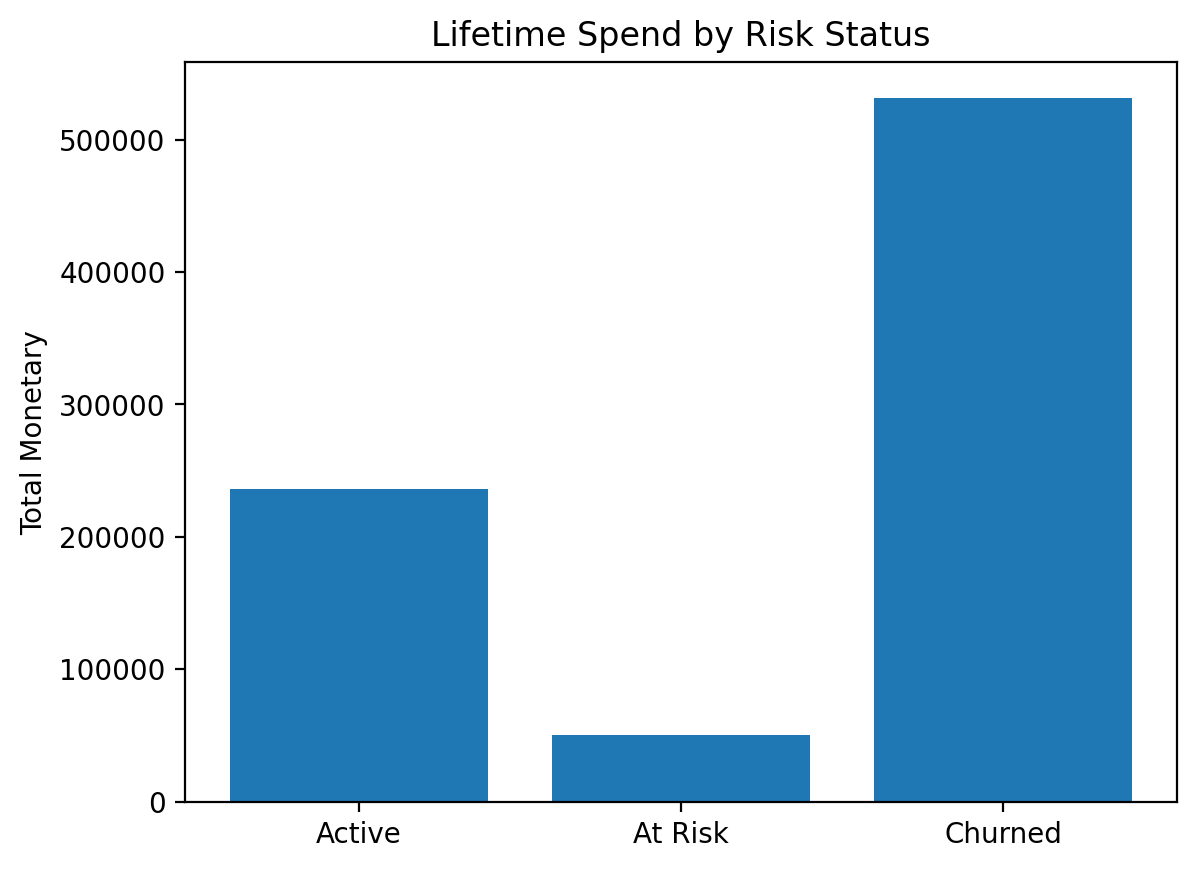

In [95]:
# 4) Risk funnel (Active / At Risk / Churned)
status = np.select([rfm["is_churned"], rfm["is_at_risk"]], ["Churned","At Risk"], default="Active")
risk = (rfm.assign(status=status)
          .groupby("status")
          .agg(customers=(order_user_fk, "count"), value=("monetary","sum"))
          .reindex(["Active","At Risk","Churned"]))

plt.figure()
plt.bar(risk.index, risk["customers"])
plt.title("Customers by Risk Status"); plt.ylabel("Customers")

plt.figure()
plt.bar(risk.index, risk["value"])
plt.title("Lifetime Spend by Risk Status"); plt.ylabel("Total Monetary")

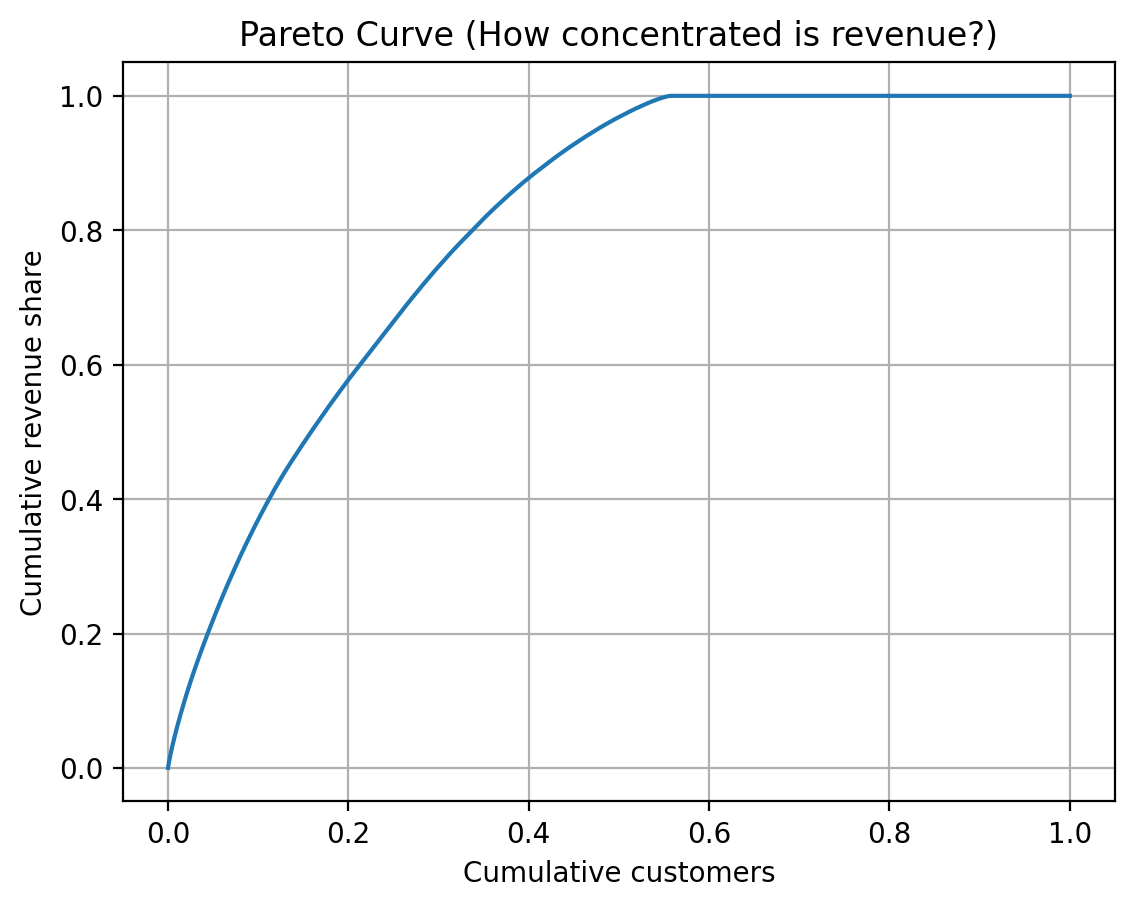

In [54]:
# 5) Pareto curve (cumulative customers vs cumulative revenue share)
pareto = rfm[["monetary"]].sort_values("monetary", ascending=False).reset_index(drop=True)
pareto["cum_rev"] = pareto["monetary"].cumsum() / pareto["monetary"].sum()
pareto["cum_cust"] = (np.arange(len(pareto)) + 1) / len(pareto)

plt.figure()
plt.plot(pareto["cum_cust"], pareto["cum_rev"])
plt.xlabel("Cumulative customers"); plt.ylabel("Cumulative revenue share")
plt.title("Pareto Curve (How concentrated is revenue?)"); plt.grid(True)

In [96]:
# =========================
# 2) Engagement features
# =========================
eng = ou.copy()
eng["hour"] = pd.to_datetime(eng[order_date_col], utc=True).dt.hour
eng["dow"]  = pd.to_datetime(eng[order_date_col], utc=True).dt.dayofweek
eng["is_weekend"] = eng["dow"] >= 5
eng["is_evening"] = eng["hour"].between(17, 22, inclusive="left")
eng["is_morning"] = eng["hour"].between(6, 12, inclusive="left")

# returns/cancels if status or timestamps exist
status_col = first_match(orders, ["status","state","order_status"])
ev = {
    "returned_at": first_match(orders, ["returned_at","returned","return_date","rma_date"]),
    "canceled_at": first_match(orders, ["canceled_at","cancelled","cancel_date"]),
}
ou_status = orders[[order_id, status_col] + [c for c in ev.values() if c]].copy() if status_col or any(ev.values()) else pd.DataFrame()
if not ou_status.empty:
    if status_col:
        s = ou_status[status_col].astype(str).str.lower()
        ou_status["is_cancel"] = s.str.contains("cancel")
        ou_status["is_return"] = s.str.contains("return")
    for k, c in ev.items():
        if c: ou_status[f"has_{k}"] = orders[c].notna()
    eng = eng.merge(ou_status[[order_id] + [c for c in ou_status.columns if c.startswith("is_") or c.startswith("has_")]],
                    on=order_id, how="left")

agg = (eng.groupby(order_user_fk, as_index=False)
         .agg(orders=("order_revenue","size"),
              weekend_share=("is_weekend","mean"),
              evening_share=("is_evening","mean"),
              morning_share=("is_morning","mean"),
              avg_order_hour=("hour","mean"),
              cancel_share=("is_cancel","mean") if "is_cancel" in eng.columns else ("order_revenue","size"),
              return_share=("is_return","mean") if "is_return" in eng.columns else ("order_revenue","size")))
if "cancel_share" in agg.columns and agg["cancel_share"].dtype != "float64":
    agg["cancel_share"] = np.nan
if "return_share" in agg.columns and agg["return_share"].dtype != "float64":
    agg["return_share"] = np.nan


In [97]:
# =========================
# 3) Demographics (gender, age, country)
# =========================
def build_age_years(df):
    df = df.copy()
    dob = pick_first(detect_columns(df, ["dob","birth","birthday","date_of_birth"]))
    if dob:
        df[dob] = pd.to_datetime(df[dob], errors="coerce")
        df["age_years"] = ((pd.Timestamp.today() - df[dob]).dt.days/365.25)
    if "age_years" not in df.columns or df["age_years"].isna().all():
        age_col = pick_first(detect_columns(df, ["age_years","age"]))
        if age_col:
            df["age_years"] = pd.to_numeric(df[age_col], errors="coerce")
    if "age_years" not in df.columns or df["age_years"].isna().all():
        y = pick_first(detect_columns(df, ["birth_year","yob","year_of_birth"]))
        if y:
            yr = pd.to_numeric(df[y], errors="coerce")
            dob_est = pd.to_datetime(dict(year=yr, month=6, day=15), errors="coerce")
            df["age_years"] = ((pd.Timestamp.today() - dob_est).dt.days/365.25)
    return df

users_demo = build_age_years(users)
if "email" in users_demo.columns:
    users_demo["email_domain"] = users_demo["email"].str.lower().str.extract(r'@(.+)$')

gender_col  = pick_first(detect_columns(users_demo, ["gender","sex"]))
country_col = pick_first(detect_columns(users_demo, ["country","country_code","nation","geo_country"]))
user_cols_keep = [c for c in [user_id, gender_col, country_col, "age_years", "email_domain"] if c]
demo = users_demo[user_cols_keep].drop_duplicates()

In [98]:
# =========================
# 4) Feature table + valuable / at-risk tags
# =========================
feat = (rfm.merge(agg, on=order_user_fk, how="left")
          .merge(demo, left_on=order_user_fk, right_on=user_id, how="left"))

feat["value_group"] = np.where(feat["segment"].isin(["VIP","Loyal"]), "valuable", "other")
feat["risk_group"]  = np.where(feat["segment"].eq("At Risk") | feat["is_at_risk"], "at_risk", "not_at_risk")

# Save features
feat.to_csv(os.path.join(OUT_DIR, "customer_features_segmented.csv"), index=False)


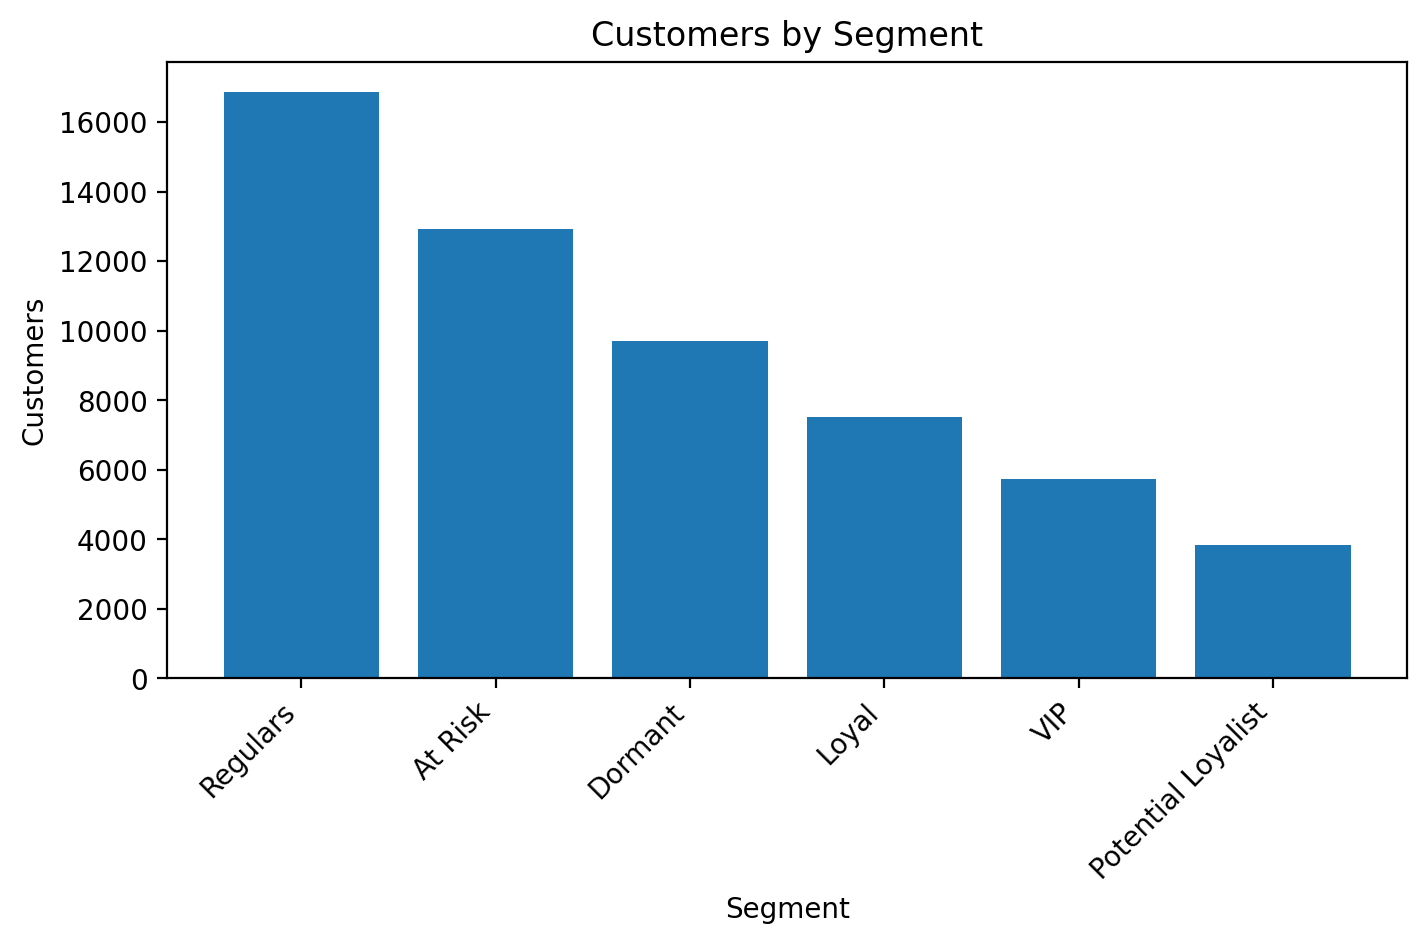

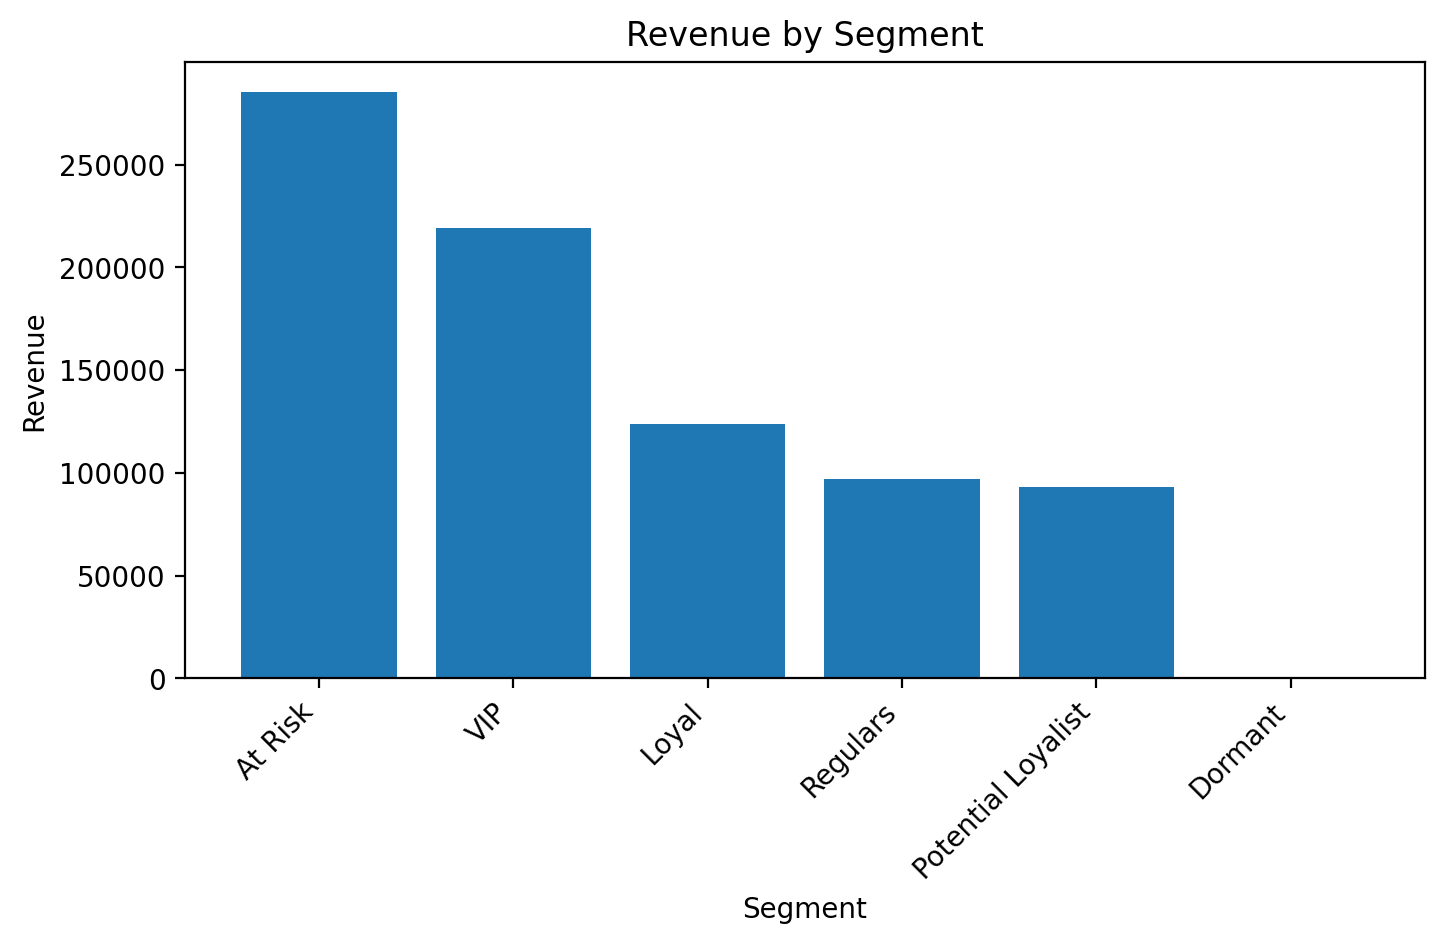

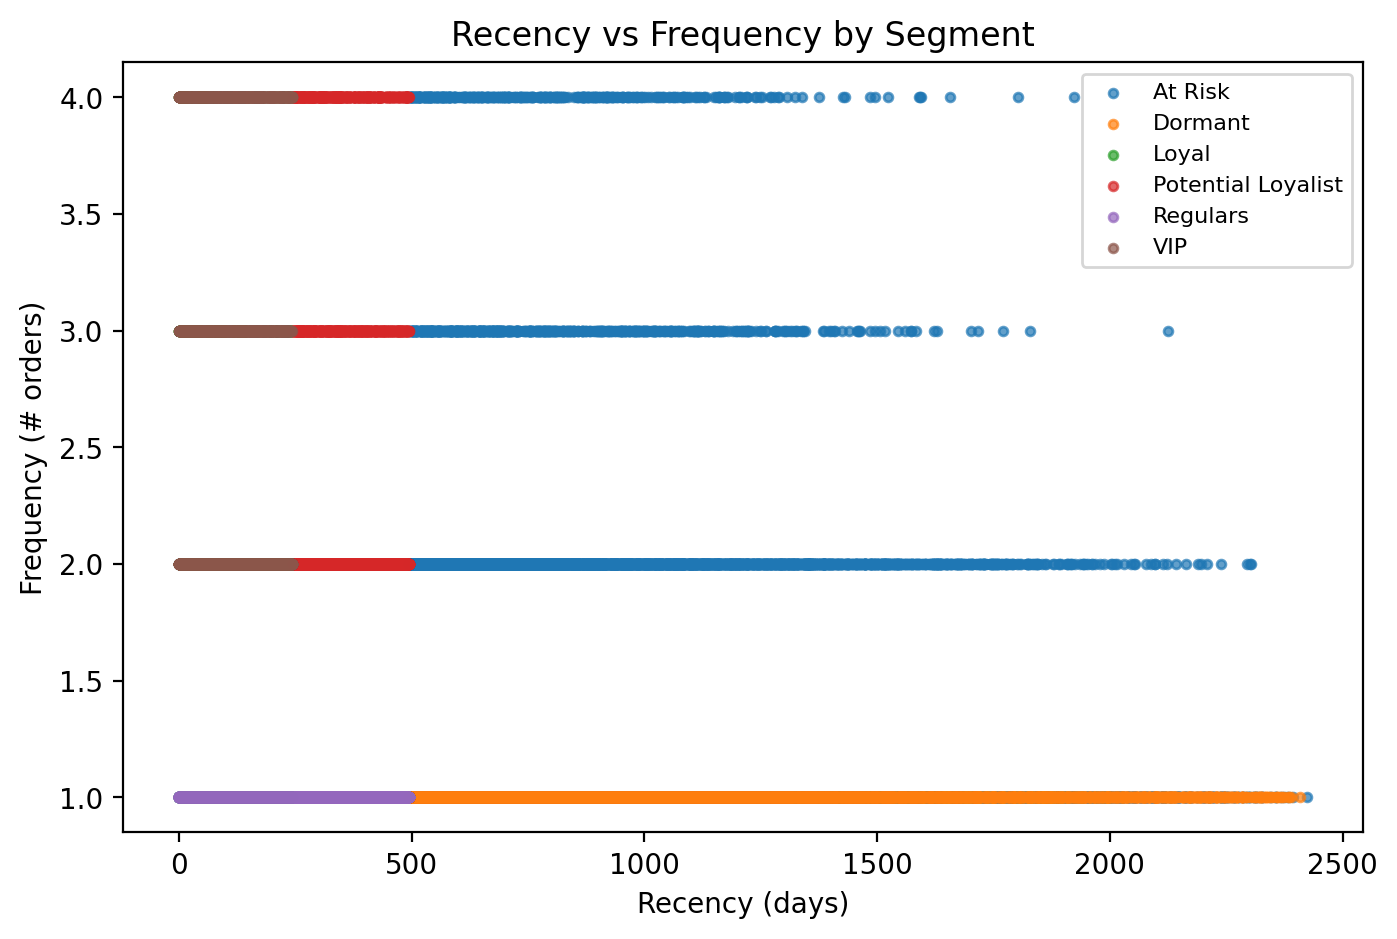

/var/folders/8s/kmd281414_3_sk09mpml3zvh0000gn/T/ipykernel_7707/284851780.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(box_data, labels=seg_order, showfliers=False)


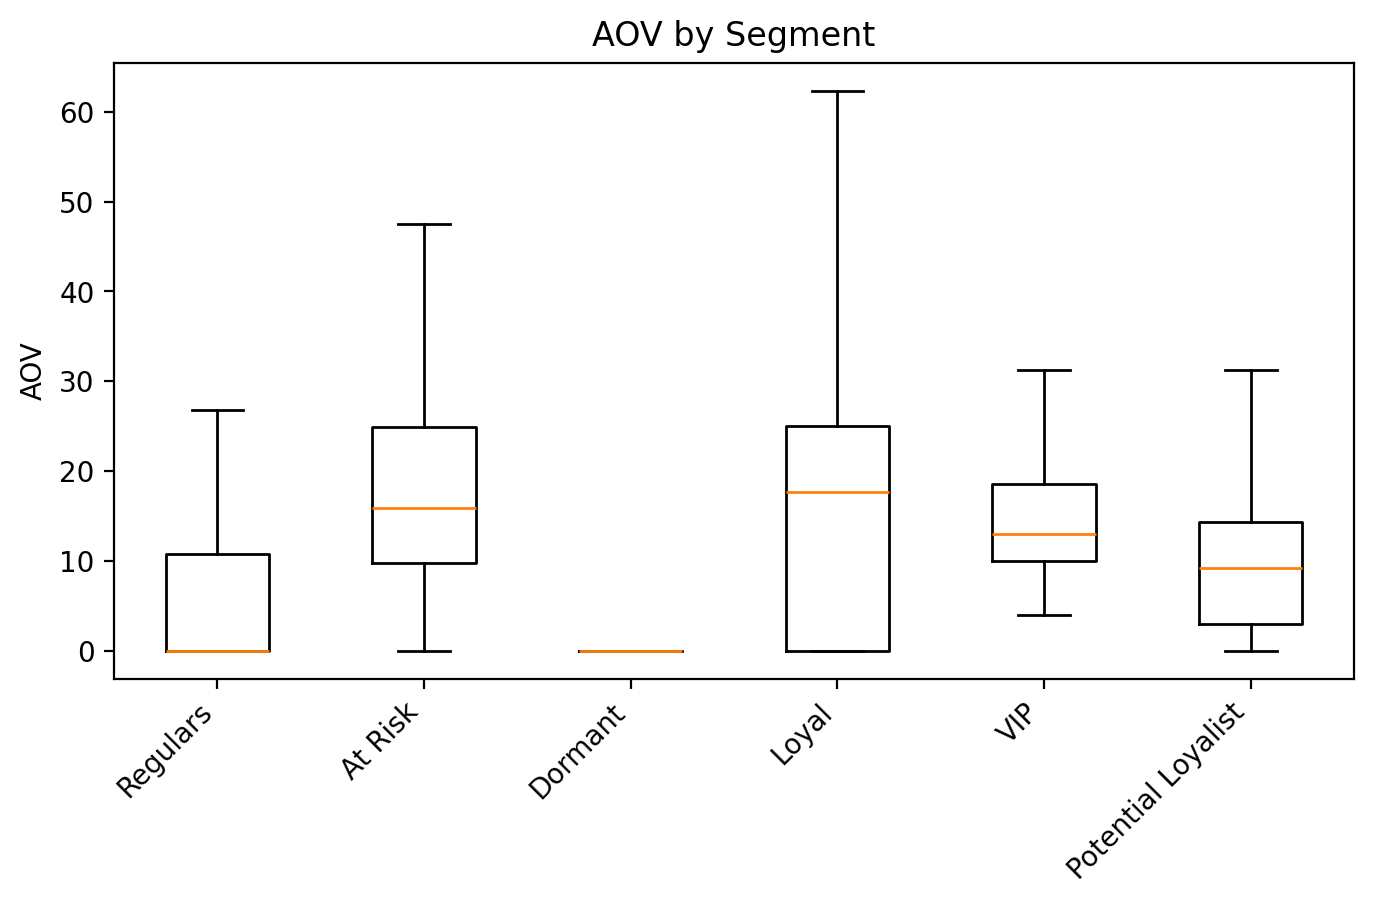

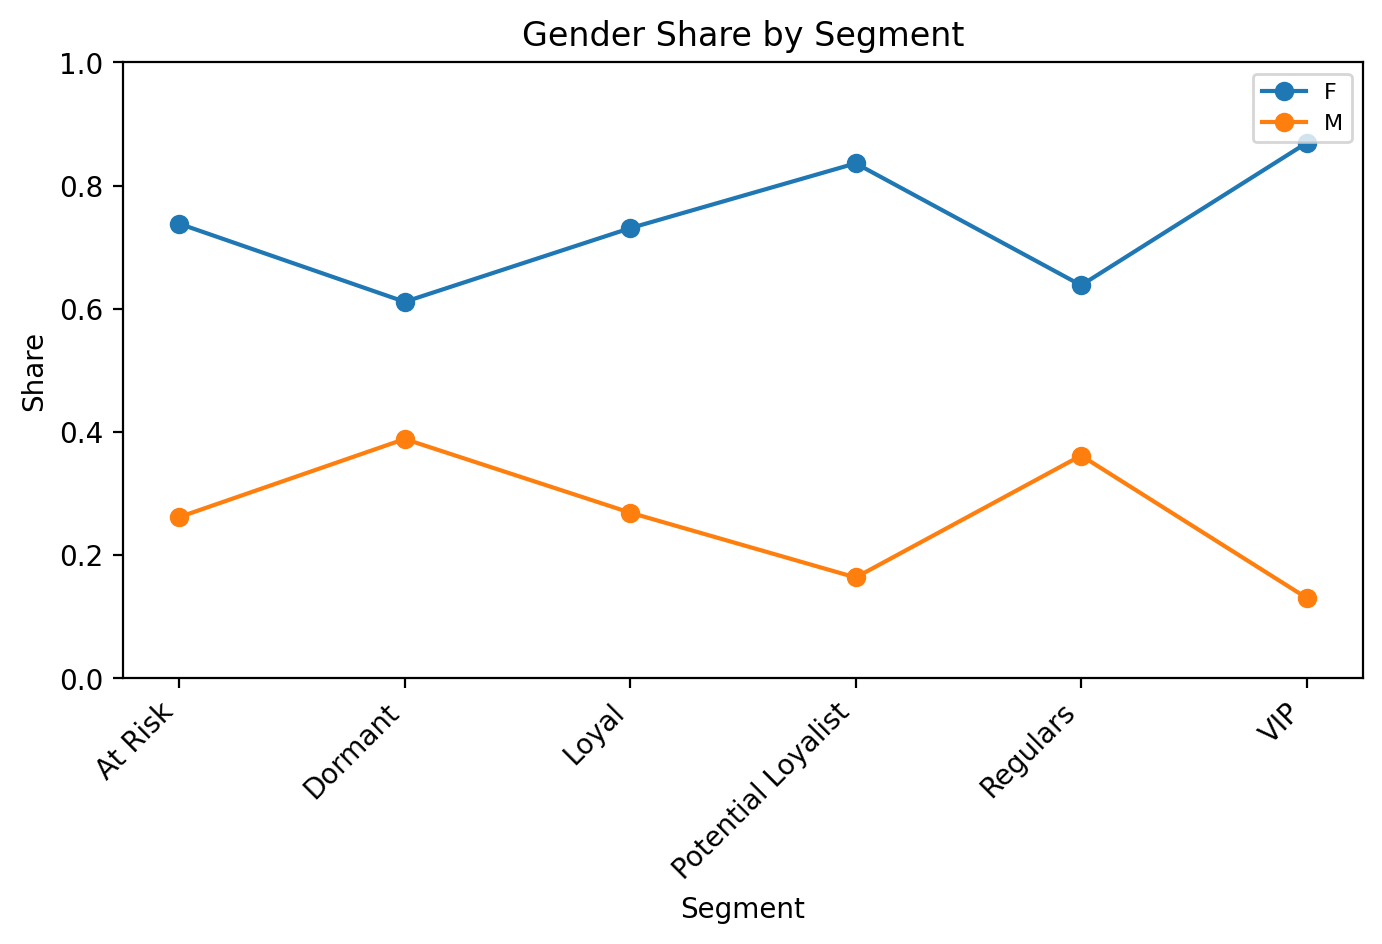

In [99]:
# =========================
# 5) Plots
# =========================
# Segment counts
seg_counts = feat["segment"].value_counts().rename_axis("segment").reset_index(name="customers")
fig = plt.figure(figsize=(8,4))
plt.bar(seg_counts["segment"].astype(str), seg_counts["customers"])
plt.xticks(rotation=45, ha="right"); plt.title("Customers by Segment"); plt.xlabel("Segment"); plt.ylabel("Customers")
finish_fig(fig, "seg_counts.png")

# Revenue by segment
seg_rev = feat.groupby("segment", as_index=False)["monetary"].sum().sort_values("monetary", ascending=False)
fig = plt.figure(figsize=(8,4))
plt.bar(seg_rev["segment"].astype(str), seg_rev["monetary"])
plt.xticks(rotation=45, ha="right"); plt.title("Revenue by Segment"); plt.xlabel("Segment"); plt.ylabel("Revenue")
finish_fig(fig, "seg_revenue.png")

# Recency vs Frequency scatter by segment (one legend)
fig = plt.figure(figsize=(8,5))
for seg, sub in feat.groupby("segment"):
    plt.scatter(sub["recency_days"], sub["frequency"], s=10, alpha=0.7, label=str(seg))
plt.xlabel("Recency (days)"); plt.ylabel("Frequency (# orders)"); plt.title("Recency vs Frequency by Segment")
plt.legend(loc="best", fontsize=8)
finish_fig(fig, "scatter_recency_frequency_by_segment.png")

# AOV by segment (boxplot)
seg_order = seg_counts["segment"].tolist()
box_data = [feat.loc[feat["segment"]==s, "aov"].dropna().values for s in seg_order]
fig = plt.figure(figsize=(8,4))
plt.boxplot(box_data, labels=seg_order, showfliers=False)
plt.xticks(rotation=45, ha="right")
plt.title("AOV by Segment"); plt.ylabel("AOV")
finish_fig(fig, "box_aov_by_segment.png")

# Gender by segment (share)
if gender_col and gender_col in feat.columns:
    gtab = (feat.groupby(["segment", gender_col]).size().rename("n").reset_index())
    pivot = gtab.pivot(index="segment", columns=gender_col, values="n").fillna(0)
    pivot = (pivot.T / pivot.sum(axis=1)).T  # share within segment
    fig = plt.figure(figsize=(8,4))
    for i, col in enumerate(pivot.columns):
        plt.plot(pivot.index.astype(str), pivot[col].values, marker="o", label=str(col))
    plt.xticks(rotation=45, ha="right"); plt.ylim(0,1)
    plt.title("Gender Share by Segment"); plt.xlabel("Segment"); plt.ylabel("Share")
    plt.legend(loc="best", fontsize=8)
    finish_fig(fig, "gender_share_by_segment.png")

,segment,customers,share_customers_%,revenue,share_revenue_%,recency_days_mean,frequency_mean,monetary_mean,aov_mean,tenure_days_mean,recency_days_median,frequency_median,monetary_median,aov_median,tenure_days_median,recency_days_p90,frequency_p90,monetary_p90,aov_p90,tenure_days_p90,recency_days_lift_vs_overall,frequency_lift_vs_overall,monetary_lift_vs_overall,aov_lift_vs_overall,tenure_days_lift_vs_overall
0,At Risk,12939,22.86,196193.069549,34.24,994.503,1.484,22.065,17.140,1169.996,892.689,1.0,20.000,15.900,1102.587,1606.653,2.0,42.000,28.990,1846.659,1.91,1.02,1.53,1.74,1.75
5,VIP,5742,10.14,160905.879596,28.08,90.234,2.671,38.189,14.951,543.712,75.541,2.0,32.965,13.000,377.300,199.421,4.0,63.838,24.524,1316.563,0.17,1.83,2.64,1.52,0.81
2,Loyal,7508,13.26,83609.519810,14.59,96.745,1.599,16.475,15.249,285.316,85.689,1.0,17.650,17.650,149.595,206.842,3.0,29.500,29.500,804.117,0.19,1.10,1.14,1.55,0.43
3,Potential Loyalist,3839,6.78,67508.839801,11.78,357.375,2.437,24.216,9.941,933.076,351.556,2.0,22.000,9.195,810.409,462.086,4.0,51.982,21.500,1653.803,0.69,1.67,1.68,1.01,1.39
4,Regulars,16874,29.81,64738.359754,11.30,214.775,1.000,5.741,5.741,214.775,207.499,1.0,0.000,0.000,207.499,428.222,1.0,20.000,20.000,428.222,0.41,0.69,0.40,0.58,0.32
1,Dormant,9703,17.14,0.000000,0.00,1061.834,1.000,0.000,0.000,1061.834,964.295,1.0,0.000,0.000,964.295,1716.133,1.0,0.000,0.000,1716.133,2.04,0.69,0.00,0.00,1.59


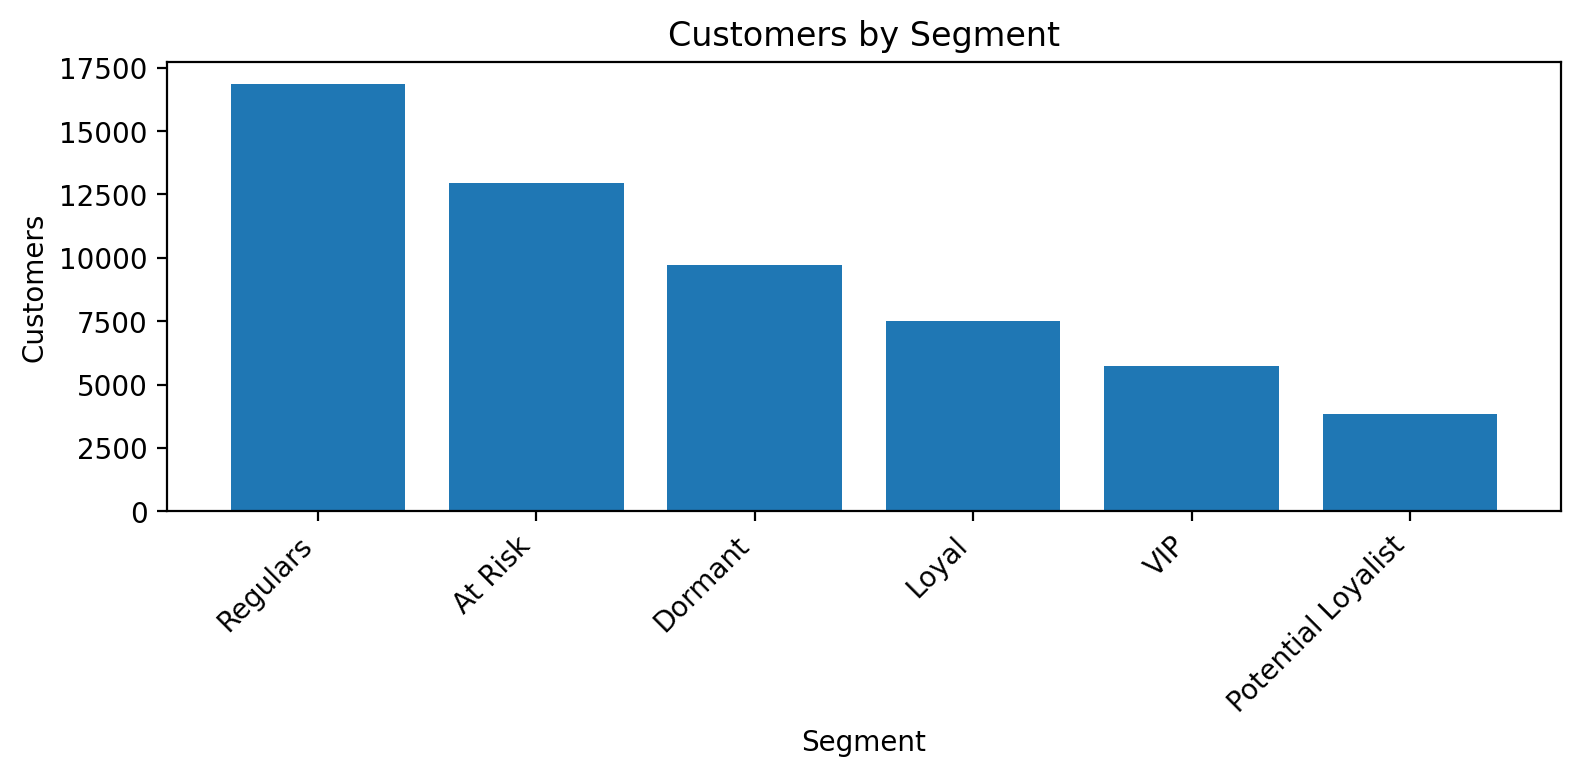

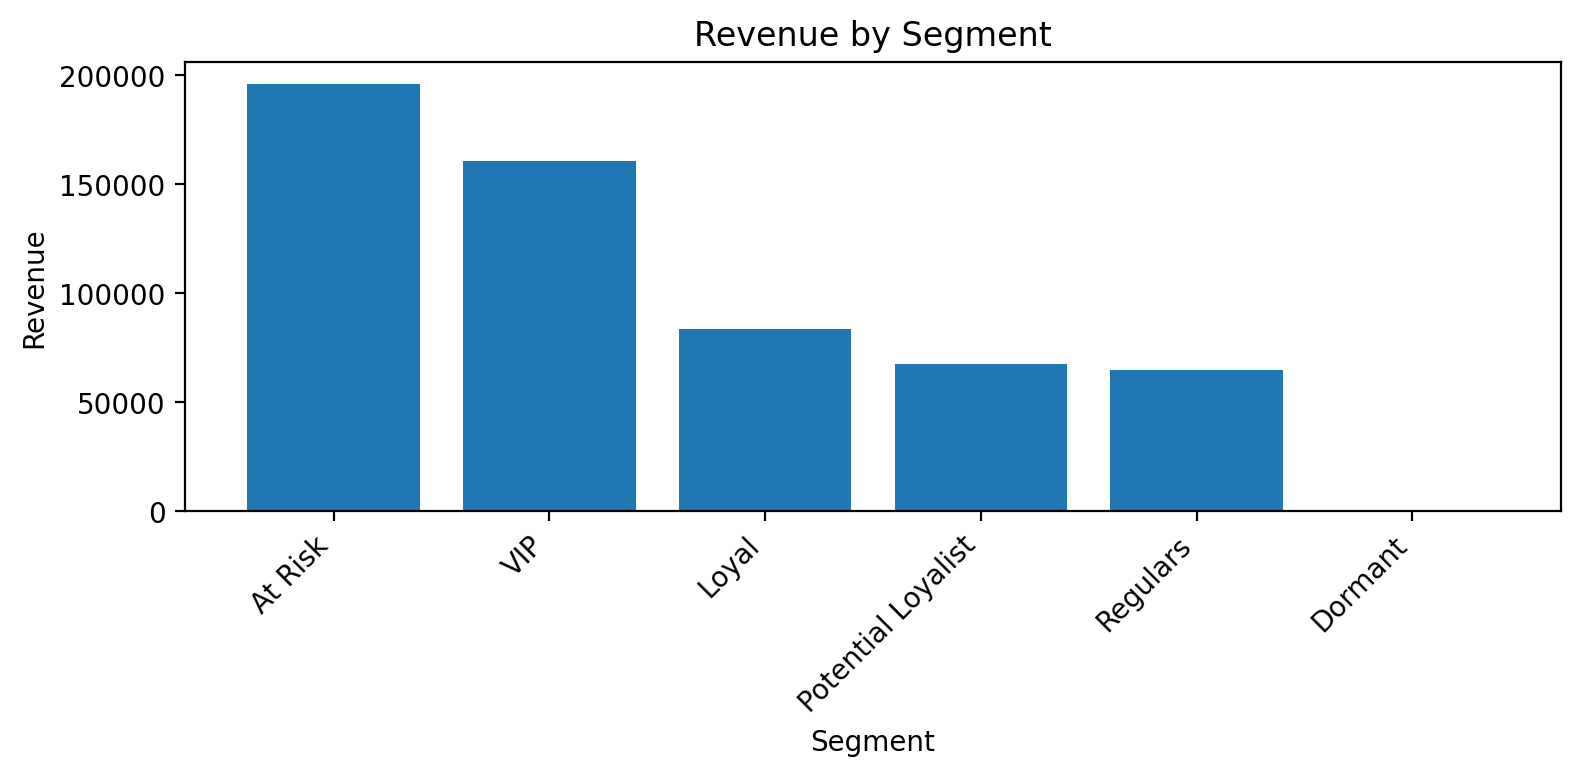

Saved: ./out/segment_summary.csv
Saved charts to: ./out

=== Quick Insights ===
- At Risk: 12939 customers | 34.24% of revenue | Recency×1.91 (lower is better), Freq×1.02, Monetary×1.53, AOV×1.74, Tenure×1.75
- VIP: 5742 customers | 28.08% of revenue | Recency×0.17 (lower is better), Freq×1.83, Monetary×2.64, AOV×1.52, Tenure×0.81
- Loyal: 7508 customers | 14.59% of revenue | Recency×0.19 (lower is better), Freq×1.10, Monetary×1.14, AOV×1.55, Tenure×0.43
- Potential Loyalist: 3839 customers | 11.78% of revenue | Recency×0.69 (lower is better), Freq×1.67, Monetary×1.68, AOV×1.01, Tenure×1.39
- Regulars: 16874 customers | 11.3% of revenue | Recency×0.41 (lower is better), Freq×0.69, Monetary×0.40, AOV×0.58, Tenure×0.32
- Dormant: 9703 customers | 0.0% of revenue | Recency×2.04 (lower is better), Freq×0.69, Monetary×0.00, AOV×0.00, Tenure×1.59


In [101]:
# ==== Segment comparison: size, revenue share, behavior stats, and lifts ====
import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt

OUT_DIR = "./out"; os.makedirs(OUT_DIR, exist_ok=True)

# ---------- tolerant helpers ----------
def _first(df, *names):
    for n in names:
        if n in df.columns: return n
    return None

def _numericize(df, cols):
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

def _ensure_dt(df, cols):
    df = df.copy()
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_datetime(df[c], errors="coerce", utc=True)
    return df

# ---------- keys ----------
u_id_users = _first(users, "user_id","id","customer_id","buyer_id","account_id")
o_id       = _first(orders, "order_id","id")
ou_fk      = _first(orders, "user_id","customer_id","buyer_id","account_id")
assert u_id_users and o_id and ou_fk, "Missing required keys in users/orders."

# find the rfm customer id column
rfm_id = _first(rfm, "user_id","id","customer_id","buyer_id","account_id")
if rfm_id is None:
    # heuristic: use the first column if it looks like an ID
    rfm_id = rfm.columns[0]

# ---------- build orders_enriched with order_revenue (filter returns when detectable) ----------
oi = order_items.copy()
qty_col   = _first(oi, "num_of_item","num_of_items","quantity","qty","item_count","items_count","count","units")
price_col = _first(oi, "sale_price","unit_price","price","amount","line_total","subtotal")
if qty_col is None:
    oi["__qty"] = 1.0; qty_col="__qty"
else:
    _numericize(oi, [qty_col]); oi[qty_col] = oi[qty_col].fillna(1.0)

if price_col:
    _numericize(oi, [price_col])
    oi["line_revenue"] = oi[price_col].fillna(0.0) * oi[qty_col]
else:
    oi["line_revenue"] = 0.0

# filter returns/cancels (best-effort)
bad = pd.Series(False, index=oi.index)
if "status" in oi.columns:
    bad |= oi["status"].astype(str).str.lower().str.contains(r"return|cancel|refund|chargeback")
if "returned_at" in oi.columns:
    bad |= pd.to_datetime(oi["returned_at"], errors="coerce").notna()
oi_good = oi.loc[~bad].copy()

# revenue per order
oi_order_id = _first(oi, "order_id")
rev_per_order = oi_good.groupby(oi_order_id)["line_revenue"].sum()

orders_dt = _ensure_dt(orders, ["created_at","shipped_at","delivered_at","returned_at"])
orders_enriched = orders_dt.copy()
orders_enriched["order_revenue"] = orders_enriched[o_id].map(rev_per_order).fillna(0.0)

# ---------- attach segment to each order ----------
seg_map = rfm[[rfm_id, "segment"]].drop_duplicates()
# ensure consistent name with orders' user key
if rfm_id != ou_fk:
    # try to align via users if columns differ
    # map orders' ou_fk -> users[u_id_users] -> rfm[rfm_id]
    # if names match across users<>rfm, direct merge; else fall back to merge on any common id name
    if rfm_id in users.columns and u_id_users in users.columns:
        tmp = users[[u_id_users, rfm_id]].drop_duplicates()
        orders_seg = (orders_enriched
                      .merge(tmp, left_on=ou_fk, right_on=u_id_users, how="left")
                      .merge(seg_map, on=rfm_id, how="left"))
    else:
        # last-resort: try direct left_on=ou_fk right_on=rfm_id
        orders_seg = orders_enriched.merge(seg_map, left_on=ou_fk, right_on=rfm_id, how="left")
else:
    orders_seg = orders_enriched.merge(seg_map, left_on=ou_fk, right_on=rfm_id, how="left")

# drop the join helper columns if they exist
orders_seg = orders_seg.drop(columns=[rfm_id, u_id_users], errors="ignore")

# ---------- core segment summaries ----------
seg_counts = rfm["segment"].value_counts(dropna=False).rename_axis("segment").reset_index(name="customers")
seg_counts["share_customers_%"] = (seg_counts["customers"] / seg_counts["customers"].sum() * 100).round(2)

seg_rev = (orders_seg.groupby("segment", dropna=False)["order_revenue"]
           .sum().reset_index(name="revenue").sort_values("revenue", ascending=False))
total_rev = seg_rev["revenue"].sum()
seg_rev["share_revenue_%"] = (seg_rev["revenue"] / total_rev * 100).round(2) if total_rev>0 else 0

# numeric behavior metrics
num_cols = [c for c in ["recency_days","frequency","monetary","aov","tenure_days"] if c in rfm.columns]
seg_stats = (rfm.groupby("segment")[num_cols]
             .agg(["mean","median","quantile"])
             .round(3))
# replace quantile default (requires q argument). We'll compute p90 separately:
seg_p90 = (rfm.groupby("segment")[num_cols].quantile(0.90)).add_suffix("_p90").round(3)
seg_mean = rfm.groupby("segment")[num_cols].mean().add_suffix("_mean").round(3)
seg_median = rfm.groupby("segment")[num_cols].median().add_suffix("_median").round(3)
seg_behavior = pd.concat([seg_mean, seg_median, seg_p90], axis=1).reset_index()

# lifts vs overall mean
overall_means = rfm[num_cols].mean().rename(lambda x: f"{x}_overall_mean")
lifts = (seg_mean.copy())
for c in num_cols:
    lifts[f"{c}_lift_vs_overall"] = (seg_mean[f"{c}_mean"] / overall_means[f"{c}_overall_mean"]).round(2)
lifts = lifts[[c for c in lifts.columns if c.endswith("_lift_vs_overall")]].reset_index()

# ---------- join all summaries ----------
seg_summary = (seg_counts
               .merge(seg_rev, on="segment", how="outer")
               .merge(seg_behavior, on="segment", how="outer")
               .merge(lifts, on="segment", how="outer"))

# ---------- display & save ----------
display(seg_summary.sort_values("share_revenue_%", ascending=False).fillna("—"))
seg_summary.to_csv(os.path.join(OUT_DIR, "segment_summary.csv"), index=False)

# quick charts
fig = plt.figure(figsize=(8,4))
plt.bar(seg_counts["segment"], seg_counts["customers"])
plt.title("Customers by Segment"); plt.xlabel("Segment"); plt.ylabel("Customers")
plt.xticks(rotation=45, ha="right")
plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR, "seg_customers.png"), dpi=150); plt.show()

fig = plt.figure(figsize=(8,4))
plt.bar(seg_rev["segment"], seg_rev["revenue"])
plt.title("Revenue by Segment"); plt.xlabel("Segment"); plt.ylabel("Revenue")
plt.xticks(rotation=45, ha="right")
plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR, "seg_revenue.png"), dpi=150); plt.show()

print("Saved:", os.path.join(OUT_DIR, "segment_summary.csv"))
print("Saved charts to:", OUT_DIR)

# ---------- optional: print a few automatic insights ----------
def _fmt(x): 
    try: return f"{x:.2f}"
    except: return str(x)

print("\n=== Quick Insights ===")
for _, row in seg_summary.sort_values("share_revenue_%", ascending=False).iterrows():
    seg = row["segment"]
    cu = int(row.get("customers", 0))
    sr = row.get("share_revenue_%", np.nan)
    rf = row.get("recency_days_lift_vs_overall", np.nan)
    ff = row.get("frequency_lift_vs_overall", np.nan)
    mf = row.get("monetary_lift_vs_overall", np.nan)
    af = row.get("aov_lift_vs_overall", np.nan)
    tf = row.get("tenure_days_lift_vs_overall", np.nan)
    print(f"- {seg}: {cu} customers | {sr}% of revenue | "
          f"Recency×{_fmt(rf)} (lower is better), Freq×{_fmt(ff)}, Monetary×{_fmt(mf)}, AOV×{_fmt(af)}, Tenure×{_fmt(tf)}")


# Churn Prediction

In [124]:
def build_rfm_segment(data, recency_col="recency_days", freq_col="frequency", mon_col="monetary"):
    df = data.copy()

    # 1) Compute quintiles on R/F/M
    qs = df[[recency_col, freq_col, mon_col]].quantile([0.2, 0.4, 0.6, 0.8])
    r_q20, r_q40, r_q60, r_q80 = qs[recency_col].values
    f_q20, f_q40, f_q60, f_q80 = qs[freq_col].values
    m_q20, m_q40, m_q60, m_q80 = qs[mon_col].values

    def r_score(x):
        if pd.isna(x): return 3
        if x <= r_q20: return 5
        if x <= r_q40: return 4
        if x <= r_q60: return 3
        if x <= r_q80: return 2
        return 1

    def fm_score(x, q20, q40, q60, q80):
        if pd.isna(x): return 3
        if x <= q20: return 1
        if x <= q40: return 2
        if x <= q60: return 3
        if x <= q80: return 4
        return 5

    df["r"] = df[recency_col].apply(r_score)
    df["f"] = df[freq_col].apply(lambda x: fm_score(x, f_q20, f_q40, f_q60, f_q80))
    df["m"] = df[mon_col].apply(lambda x: fm_score(x, m_q20, m_q40, m_q60, m_q80))

    # 2) Segment rules
    def assign_segment(row):
        r, f, m = row["r"], row["f"], row["m"]
        if (r >= 4) and (f >= 4) and (m >= 4):
            return "VIP"
        if (r >= 4) and ((f >= 4) or (m >= 4)):
            return "Loyal"
        if (r >= 3) and (f >= 3):
            return "Potential Loyalist"
        if (r <= 2) and ((f >= 3) or (m >= 3)):
            return "At Risk"
        if (r <= 2) and (f <= 2) and (m <= 2):
            return "Dormant"
        return "Regulars"

    df["segment"] = df.apply(assign_segment, axis=1)
    return df

# If you don't already have segment:
if "segment" not in data.columns:
    data = build_rfm_segment(data)


In [112]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import TweedieRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import inspect

cid = "user_id"   # customer id column name

# --- 1) Keep only non-cancelled line items ---
order_items_clean = order_items[order_items["status"] != "Cancelled"].copy()

print("Users table customers:", users["id"].nunique())
print("Orders table customers:", orders["user_id"].nunique())
print("Order_items customers (non-cancelled):", order_items_clean["user_id"].nunique())

# --- 2) Merge order_items with orders to get order-level info ---
oi = order_items_clean.merge(
    orders[["order_id", "user_id", "status", "created_at"]],
    on=["order_id", "user_id"],
    how="inner",
    suffixes=("_item", "_order")
)

# Use order-level created_at as the order date
oi["order_date"] = pd.to_datetime(oi["created_at_order"])
oi["revenue"] = oi["sale_price"].astype(float)

# Keep only positive revenue just in case
oi = oi[oi["revenue"] > 0].copy()

print("Non-cancelled, positive-revenue line items:", len(oi))
print("Customers with ≥1 non-cancelled line:", oi[cid].nunique())


Users table customers: 100000
Orders table customers: 56605
Order_items customers (non-cancelled): 38885
Non-cancelled, positive-revenue line items: 35187
Customers with ≥1 non-cancelled line: 25185


In [113]:
H_DAYS = 90

min_date = oi["order_date"].min()
max_date = oi["order_date"].max()
cutoff = max_date - pd.Timedelta(days=H_DAYS)

print("Order date range:", min_date, "→", max_date)
print("Snapshot (cutoff) for features:", cutoff)

hist = oi[oi["order_date"] <= cutoff].copy()
future = oi[oi["order_date"] > cutoff].copy()

print("Customers with history (≤ cutoff):", hist[cid].nunique())
print("Customers with future orders (> cutoff):", future[cid].nunique())


Order date range: 2019-01-10 00:24:00+00:00 → 2025-08-27 19:24:57.272875+00:00
Snapshot (cutoff) for features: 2025-05-29 19:24:57.272875+00:00
Customers with history (≤ cutoff): 21136
Customers with future orders (> cutoff): 4810


In [114]:
snap_date = cutoff

cust_hist = (
    hist.groupby(cid)
        .agg(
            first_order_date=("order_date", "min"),
            last_order_date=("order_date", "max"),
            frequency=("order_id", "nunique"),
            monetary=("revenue", "sum"),
            avg_order_value=("revenue", "mean")
        )
        .reset_index()
)

cust_hist["tenure_days"] = (snap_date - cust_hist["first_order_date"]).dt.days
cust_hist["recency_days"] = (snap_date - cust_hist["last_order_date"]).dt.days

print("Customers in cust_hist (with ≥1 order before cutoff):", cust_hist[cid].nunique())


Customers in cust_hist (with ≥1 order before cutoff): 21136


In [115]:
user_cols = ["id", "age", "gender", "state", "country", "city"]
users_sub = users[user_cols].rename(columns={"id": cid})

data = cust_hist.merge(users_sub, on=cid, how="left")

print("After joining users (left join):", data[cid].nunique(), "customers")


After joining users (left join): 21136 customers


In [116]:
clv_future = (
    future.groupby(cid)["revenue"]
        .sum()
        .rename("actual_clv_90d")
        .reset_index()
)

data = data.merge(clv_future, on=cid, how="left")
data["actual_clv_90d"] = data["actual_clv_90d"].fillna(0.0)

print("Final modeling rows:", len(data))
print("Customers (final data):", data[cid].nunique())
print("% customers with CLV_90d > 0:", (data["actual_clv_90d"] > 0).mean())
print("Median CLV (non-zero):",
      np.median(data.loc[data["actual_clv_90d"] > 0, "actual_clv_90d"]))


Final modeling rows: 21136
Customers (final data): 21136
% customers with CLV_90d > 0: 0.03600492051476154
Median CLV (non-zero): 21.0


In [117]:
num_feats = [
    "recency_days",
    "tenure_days",
    "frequency",
    "monetary",
    "avg_order_value",
    "age",
]

cat_feats = [
    "gender",
    "state",
    "country",
    "city",
]

# Keep only columns that actually exist
num_feats = [c for c in num_feats if c in data.columns]
cat_feats = [c for c in cat_feats if c in data.columns]

print("Numeric features:", num_feats)
print("Categorical features:", cat_feats)


Numeric features: ['recency_days', 'tenure_days', 'frequency', 'monetary', 'avg_order_value', 'age']
Categorical features: ['gender', 'state', 'country', 'city']


In [118]:
X_all = data[num_feats + cat_feats].copy()
y_all = data["actual_clv_90d"].values

cust_ids = data[cid].unique()
tr_ids, te_ids = train_test_split(cust_ids, test_size=0.2, random_state=42)

def subset(ids):
    df_sub = data[data[cid].isin(ids)].copy()
    return df_sub[num_feats + cat_feats], df_sub["actual_clv_90d"].values

Xtr, ytr = subset(tr_ids)
Xte, yte = subset(te_ids)

print("Train customers:", len(tr_ids), "Test customers:", len(te_ids))


Train customers: 16908 Test customers: 4228


In [120]:
# OneHotEncoder compatibility for different sklearn versions
ohe = (
    OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    if "sparse_output" in inspect.signature(OneHotEncoder).parameters
    else OneHotEncoder(handle_unknown="ignore", sparse=False)
)

pre = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imp", SimpleImputer(strategy="median")),
            ("sc", StandardScaler())
        ]), num_feats),
        ("cat", Pipeline([
            ("imp", SimpleImputer(strategy="constant", fill_value="Unknown")),
            ("ohe", ohe)
        ]), cat_feats),
    ],
    remainder="drop",
)

reg = Pipeline([
    ("pre", pre),
    ("tw", TweedieRegressor(
        power=1.5,     # between Poisson(1) and Gamma(2)
        alpha=1e-3,
        max_iter=3000,
        link="log"
    )),
])

reg.fit(Xtr, ytr)
y_pred = np.clip(reg.predict(Xte), 0, None)

from sklearn.metrics import mean_squared_error

def rmse(y_true, y_pred):
    """
    Version-safe RMSE: uses squared=False if available,
    otherwise falls back to sqrt(MSE).
    """
    try:
        # Newer sklearn
        return mean_squared_error(y_true, y_pred, squared=False)
    except TypeError:
        # Older sklearn (no 'squared' parameter)
        return mean_squared_error(y_true, y_pred) ** 0.5

mae = mean_absolute_error(yte, y_pred)
rmse_val = rmse(yte, y_pred)
mape_med = np.nanmedian(
    np.abs(y_pred - yte) / np.where(yte == 0, np.nan, yte)
)

print(f"Tweedie CLV_90d — MAE: {mae:.3f} | RMSE: {rmse_val:.3f} | Median APE (non-zero): {mape_med:.3f}")


Tweedie CLV_90d — MAE: 1.340 | RMSE: 4.669 | Median APE (non-zero): 0.968


In [122]:
def decile_table(df, score_col, k=10):
    d = df[[score_col, "actual_clv_90d"]].copy()
    ranks = d[score_col].rank(method="first", ascending=False)
    d["decile"] = pd.qcut(ranks, q=k, labels=False) + 1
    out = (
        d.groupby("decile")
         .agg(
             customers=("actual_clv_90d", "size"),
             pred_sum=(score_col, "sum"),
             actual_sum=("actual_clv_90d", "sum"),
         )
         .reset_index()
         .sort_values("decile")
    )
    out["pred_per_cust"] = out["pred_sum"] / out["customers"]
    out["actual_per_cust"] = out["actual_sum"] / out["customers"]
    return out

test_df = data[data[cid].isin(te_ids)].copy()
test_df["pred_clv_90d"] = y_pred

cal = decile_table(test_df, "pred_clv_90d")
top_actual = cal.iloc[0]["actual_per_cust"]   # decile 1
bot_actual = cal.iloc[-1]["actual_per_cust"]  # decile 10
print("Top decile actual $/cust:", top_actual)
print("Bottom decile actual $/cust:", bot_actual)

Top decile actual $/cust: 1.9195508201635194
Bottom decile actual $/cust: 0.1927423161535962


In [130]:
cid = "user_id"  # or whatever you’re using

eval_df = data[data[cid].isin(te_ids)].copy()
eval_df["pred_clv_90d"] = y_pred

# Only if segment is missing
if "segment" not in eval_df.columns:
    eval_df = build_rfm_segment(eval_df)  # the function I gave you earlier



In [131]:
segment_order = [
    "VIP", "Loyal", "Potential Loyalist",
    "Regulars", "At Risk", "Dormant"
]

seg_summary = (
    eval_df.groupby("segment")
        .agg(
            customers=(cid, "nunique"),
            hist_monetary=("monetary", "mean"),
            actual_clv_90d=("actual_clv_90d", "mean"),
            pred_clv_90d=("pred_clv_90d", "mean"),
            total_actual_clv_90d=("actual_clv_90d", "sum"),
        )
        .reset_index()
)

# Add shares
total_customers = seg_summary["customers"].sum()
total_revenue = seg_summary["total_actual_clv_90d"].sum()

seg_summary["cust_share"] = seg_summary["customers"] / total_customers
seg_summary["rev_share"] = seg_summary["total_actual_clv_90d"] / total_revenue

# Order segments for nicer plots
seg_summary["segment"] = pd.Categorical(
    seg_summary["segment"],
    categories=segment_order,
    ordered=True
)
seg_summary = seg_summary.sort_values("segment")

seg_summary


,segment,customers,hist_monetary,actual_clv_90d,pred_clv_90d,total_actual_clv_90d,cust_share,rev_share
5,VIP,291,48.622062,1.533505,0.868674,446.250001,0.068827,0.130505
2,Loyal,381,33.537900,1.421234,0.865305,541.489999,0.090114,0.158358
3,Potential Loyalist,144,47.499444,0.920694,0.534109,132.580000,0.034059,0.038773
4,Regulars,1709,18.589590,1.024324,0.771472,1750.569998,0.404210,0.511951
0,At Risk,987,31.347062,0.361368,0.312025,356.670001,0.233444,0.104307
1,Dormant,716,12.407570,0.267947,0.313025,191.849999,0.169347,0.056106


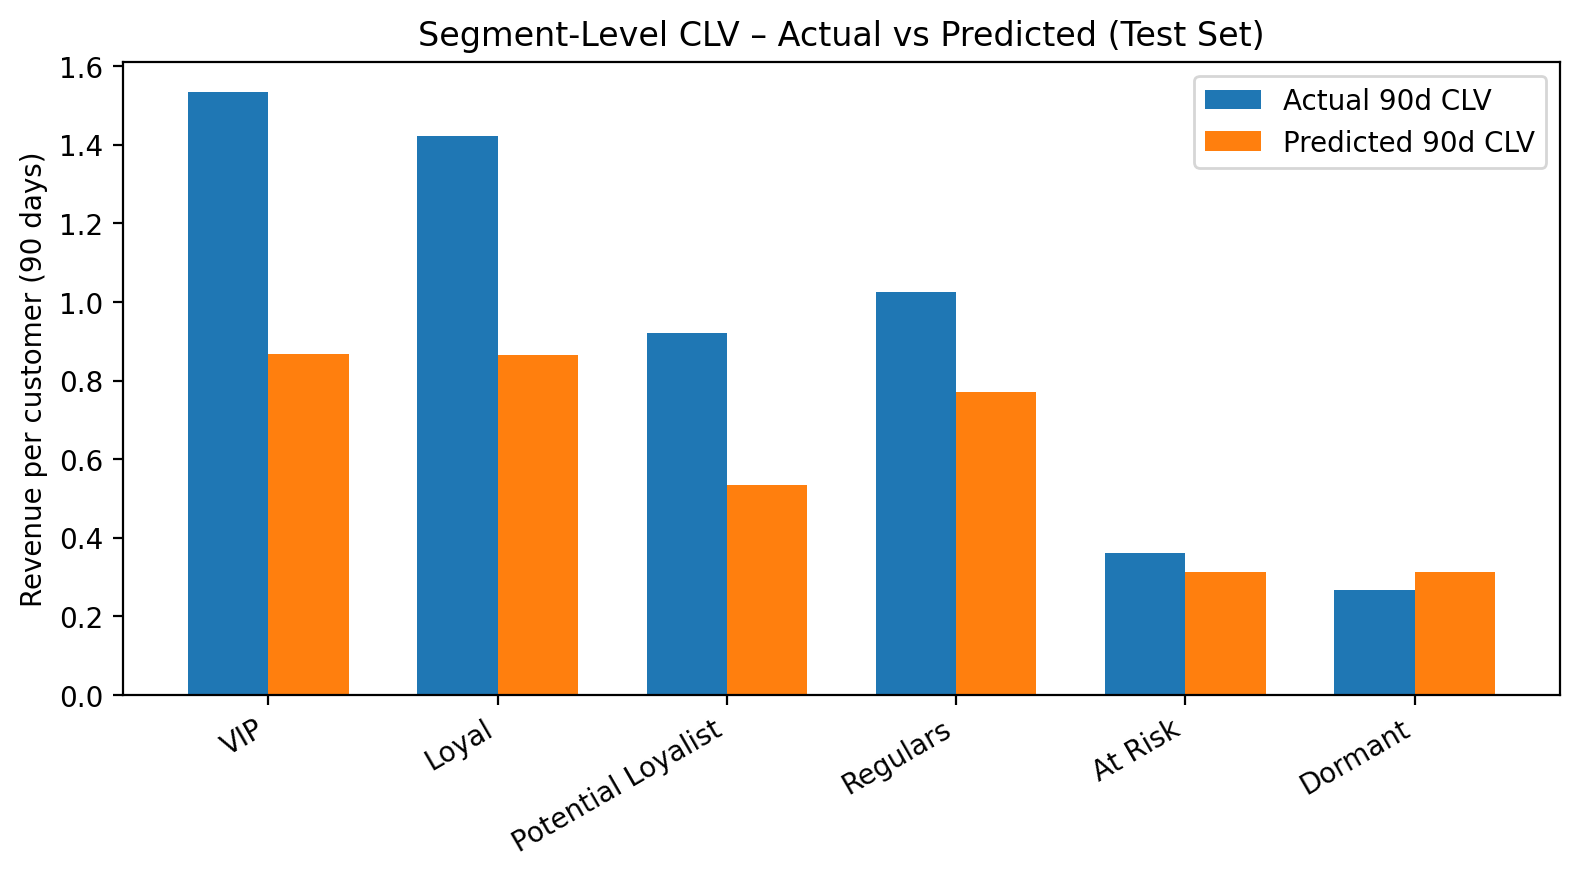

In [132]:
import matplotlib.pyplot as plt
import numpy as np

# Actual vs predicted CLV per segment
fig, ax = plt.subplots(figsize=(8, 4.5))

x = np.arange(len(seg_summary))
w = 0.35

ax.bar(x - w/2, seg_summary["actual_clv_90d"], width=w, label="Actual 90d CLV")
ax.bar(x + w/2, seg_summary["pred_clv_90d"],   width=w, label="Predicted 90d CLV")

ax.set_xticks(x)
ax.set_xticklabels(seg_summary["segment"], rotation=30, ha="right")
ax.set_ylabel("Revenue per customer (90 days)")
ax.set_title("Segment-Level CLV – Actual vs Predicted (Test Set)")
ax.legend()
plt.tight_layout()
plt.savefig("out/segment_clv_actual_vs_pred.png", dpi=150)
plt.show()


/var/folders/8s/kmd281414_3_sk09mpml3zvh0000gn/T/ipykernel_7707/701565146.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(seg_summary["segment"], rotation=30, ha="right")


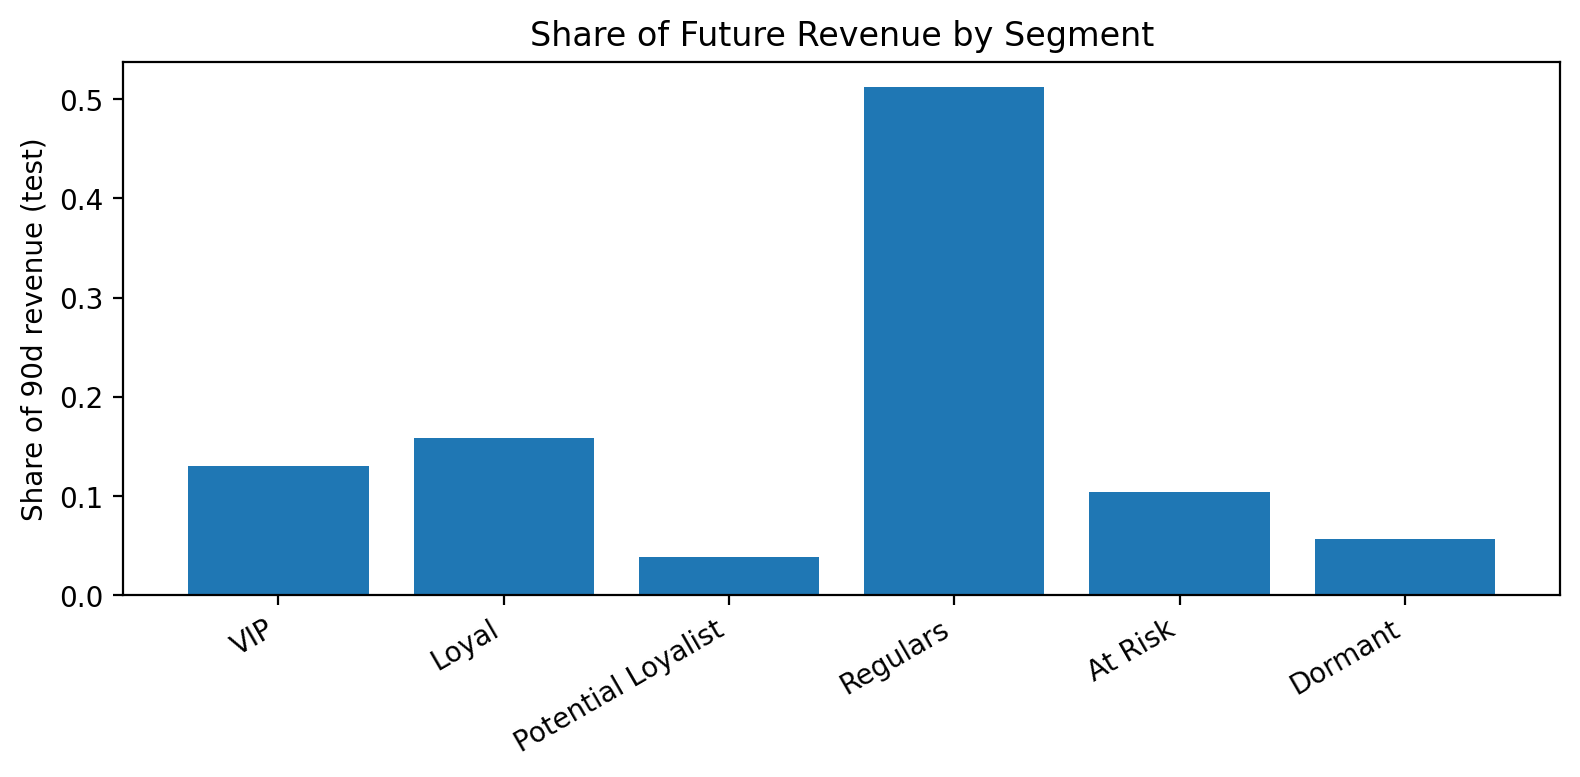

In [133]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.bar(seg_summary["segment"], seg_summary["rev_share"])
ax.set_ylabel("Share of 90d revenue (test)")
ax.set_title("Share of Future Revenue by Segment")
ax.set_xticklabels(seg_summary["segment"], rotation=30, ha="right")

plt.tight_layout()
plt.savefig("out/segment_revenue_share.png", dpi=150)
plt.show()


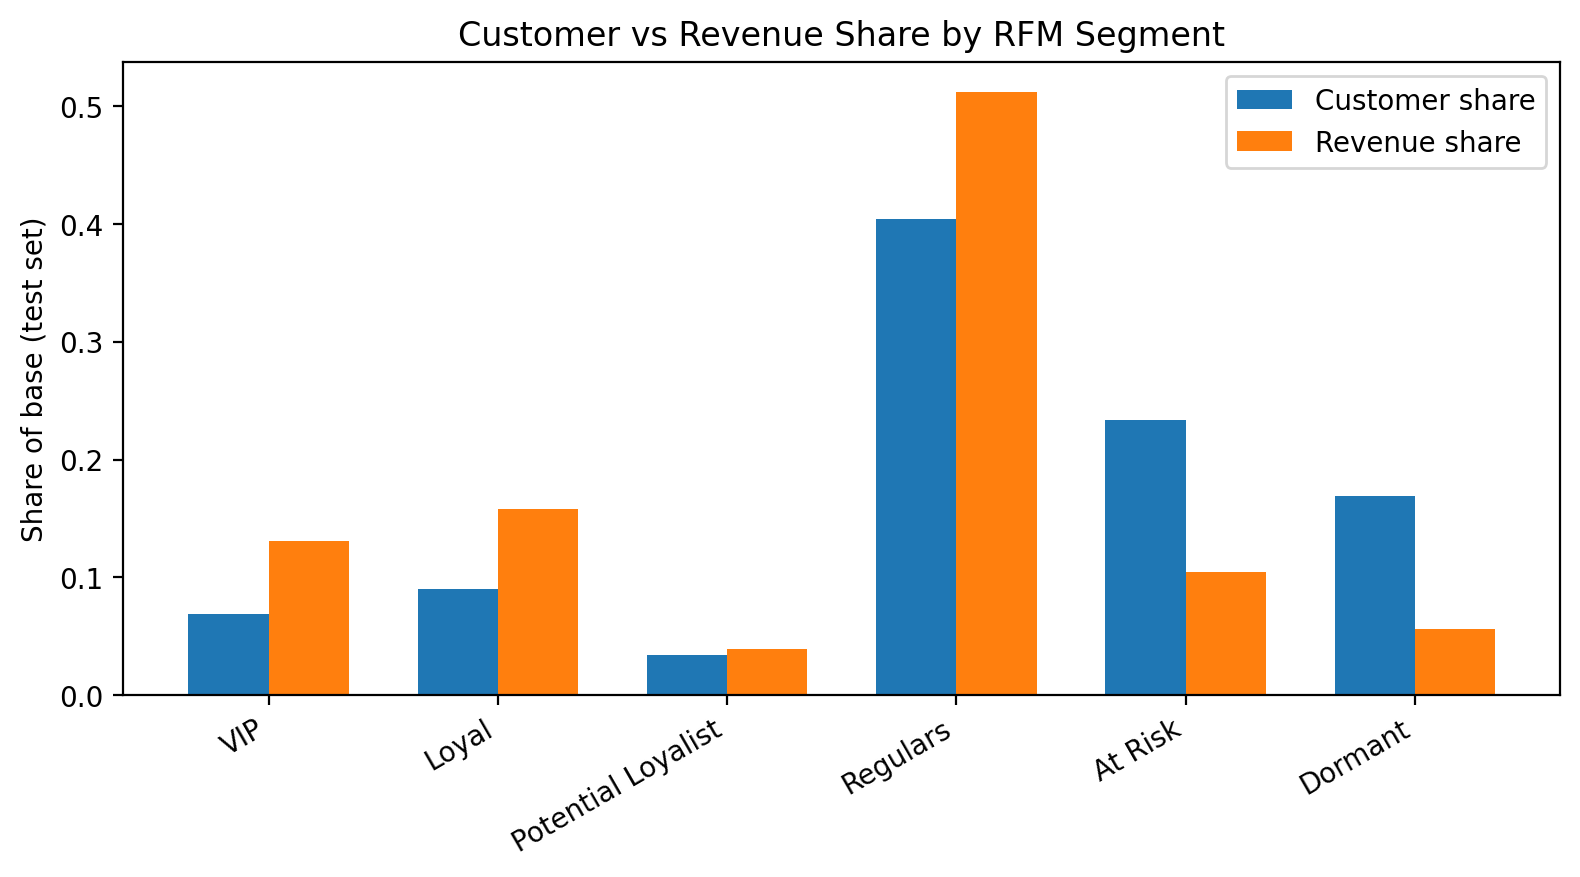

In [135]:
fig, ax = plt.subplots(figsize=(8, 4.5))

x = np.arange(len(seg_summary))
w = 0.35

ax.bar(x - w/2, seg_summary["cust_share"], width=w, label="Customer share")
ax.bar(x + w/2, seg_summary["rev_share"], width=w, label="Revenue share")

ax.set_xticks(x)
ax.set_xticklabels(seg_summary["segment"], rotation=30, ha="right")
ax.set_ylabel("Share of base (test set)")
ax.set_title("Customer vs Revenue Share by RFM Segment")
ax.legend()
plt.tight_layout()
plt.savefig("out/segment_customer_vs_revenue_share_side_by_side.png", dpi=150)
plt.show()


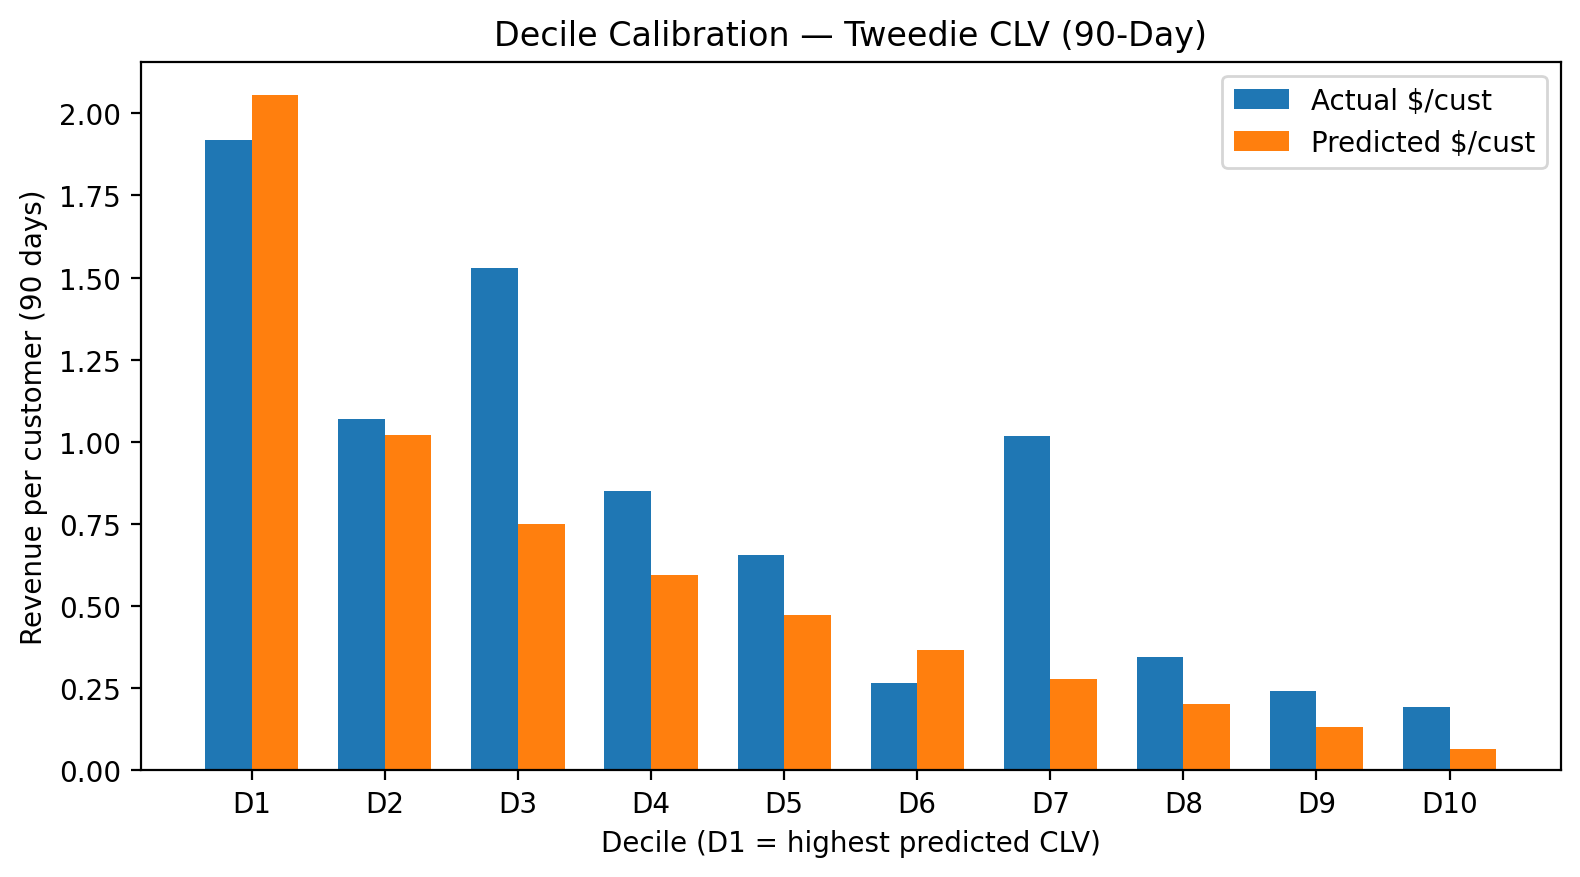

In [136]:
fig, ax = plt.subplots(figsize=(8, 4.5))
x = np.arange(len(cal))  # cal = decile table
w = 0.35

ax.bar(x - w/2, cal["actual_per_cust"], width=w, label="Actual $/cust")
ax.bar(x + w/2, cal["pred_per_cust"],   width=w, label="Predicted $/cust")

ax.set_xticks(x)
ax.set_xticklabels([f"D{int(d)}" for d in cal["decile"]])
ax.set_xlabel("Decile (D1 = highest predicted CLV)")
ax.set_ylabel("Revenue per customer (90 days)")
ax.set_title("Decile Calibration — Tweedie CLV (90-Day)")
ax.legend()
plt.tight_layout()
plt.savefig("out/clv_decile_calibration_tweedie.png", dpi=150)
plt.show()


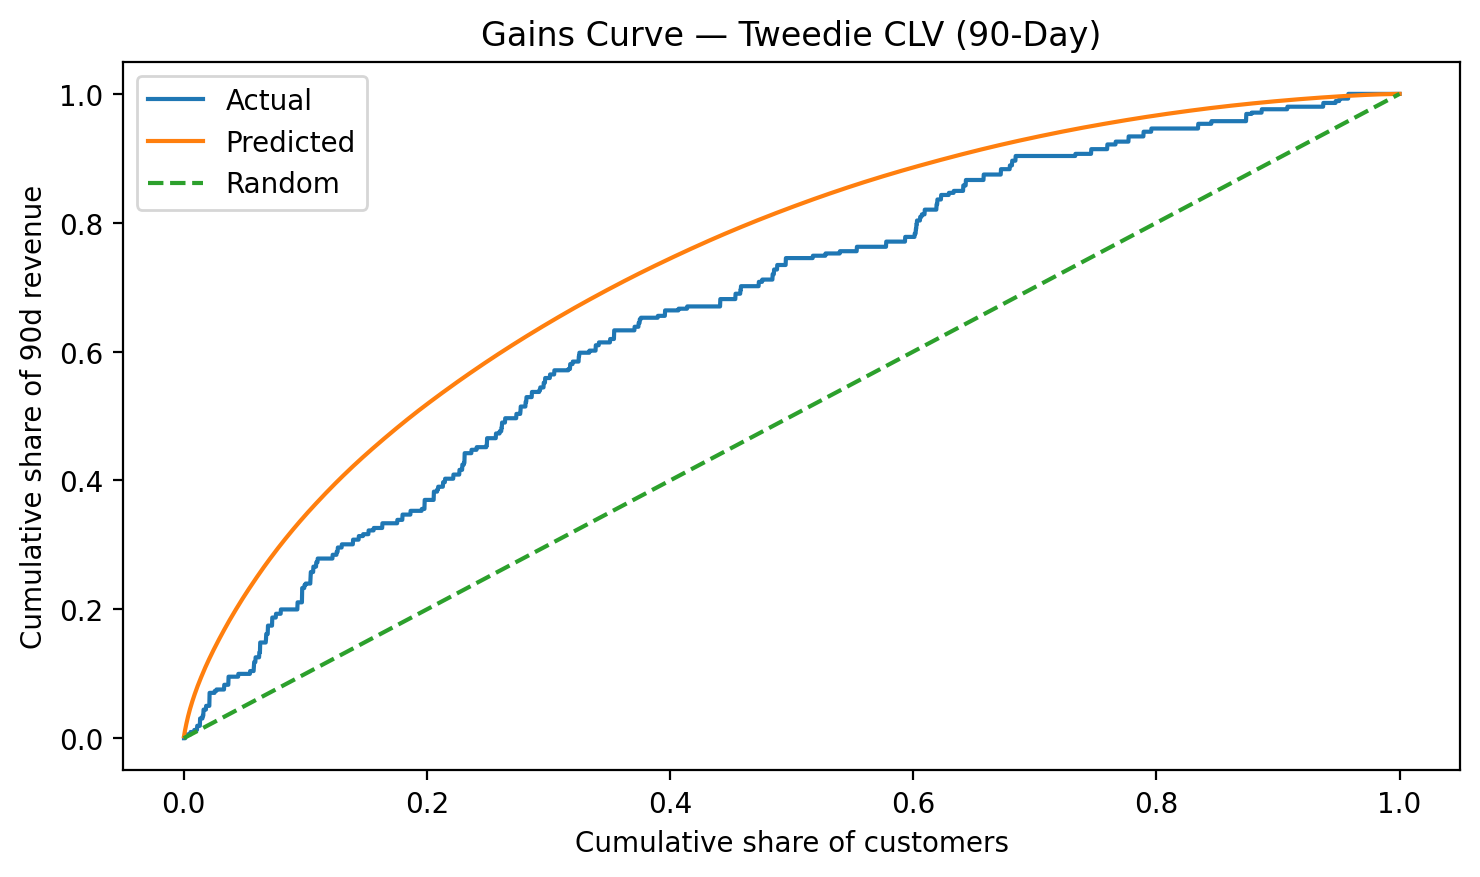

In [137]:
d = test_df.sort_values("pred_clv_90d", ascending=False).reset_index(drop=True)
d["cum_customers"] = (np.arange(len(d)) + 1) / len(d)
total_actual = d["actual_clv_90d"].sum()
total_pred   = d["pred_clv_90d"].sum()

d["cum_actual"] = d["actual_clv_90d"].cumsum() / total_actual
d["cum_pred"]   = d["pred_clv_90d"].cumsum()   / total_pred

fig, ax = plt.subplots(figsize=(7.5, 4.5))
ax.plot(d["cum_customers"], d["cum_actual"], label="Actual")
ax.plot(d["cum_customers"], d["cum_pred"],   label="Predicted")
ax.plot([0, 1], [0, 1], "--", label="Random")
ax.set_xlabel("Cumulative share of customers")
ax.set_ylabel("Cumulative share of 90d revenue")
ax.set_title("Gains Curve — Tweedie CLV (90-Day)")
ax.legend()
plt.tight_layout()
plt.savefig("out/clv_gains_curve_tweedie.png", dpi=150)
plt.show()


In [138]:
seg_summary

,segment,customers,hist_monetary,actual_clv_90d,pred_clv_90d,total_actual_clv_90d,cust_share,rev_share
5,VIP,291,48.622062,1.533505,0.868674,446.250001,0.068827,0.130505
2,Loyal,381,33.537900,1.421234,0.865305,541.489999,0.090114,0.158358
3,Potential Loyalist,144,47.499444,0.920694,0.534109,132.580000,0.034059,0.038773
4,Regulars,1709,18.589590,1.024324,0.771472,1750.569998,0.404210,0.511951
0,At Risk,987,31.347062,0.361368,0.312025,356.670001,0.233444,0.104307
1,Dormant,716,12.407570,0.267947,0.313025,191.849999,0.169347,0.056106


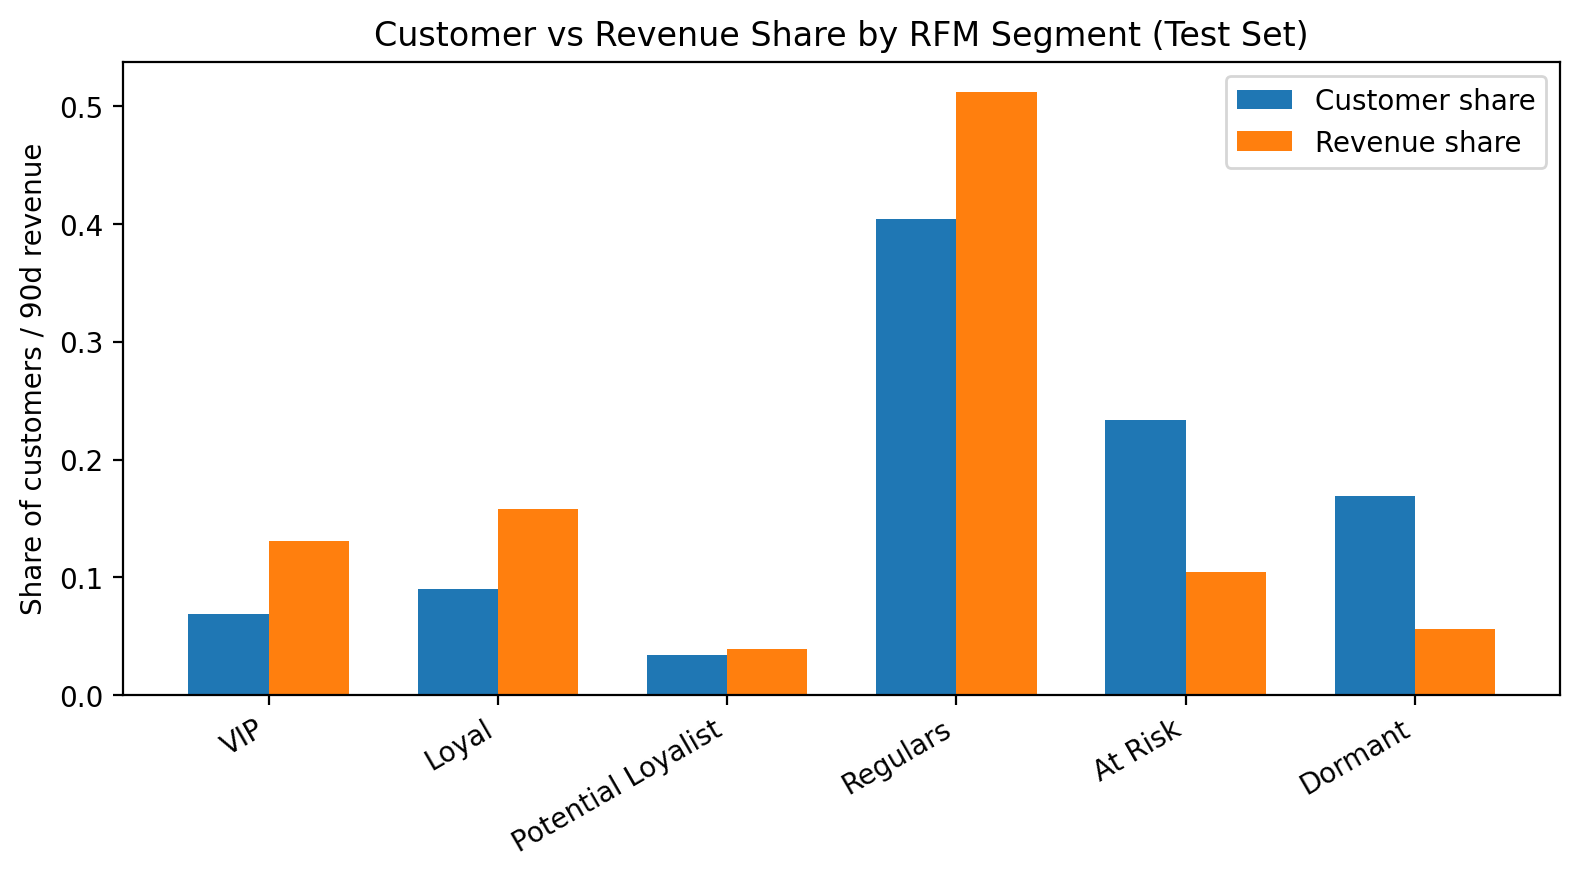

In [146]:
import matplotlib.pyplot as plt
import numpy as np

segment_order = ["VIP", "Loyal", "Potential Loyalist", "Regulars", "At Risk", "Dormant"]

seg_plot = seg_summary.set_index("segment").loc[segment_order].reset_index()

fig, ax = plt.subplots(figsize=(8, 4.5))

x = np.arange(len(seg_plot))
w = 0.35

ax.bar(x - w/2, seg_plot["cust_share"], width=w, label="Customer share")
ax.bar(x + w/2, seg_plot["rev_share"],  width=w, label="Revenue share")

ax.set_xticks(x)
ax.set_xticklabels(seg_plot["segment"], rotation=30, ha="right")
ax.set_ylabel("Share of customers / 90d revenue")
ax.set_title("Customer vs Revenue Share by RFM Segment (Test Set)")
ax.legend()

plt.tight_layout()
plt.savefig("out/segment_customer_vs_revenue_share_final.png", dpi=150)
plt.show()


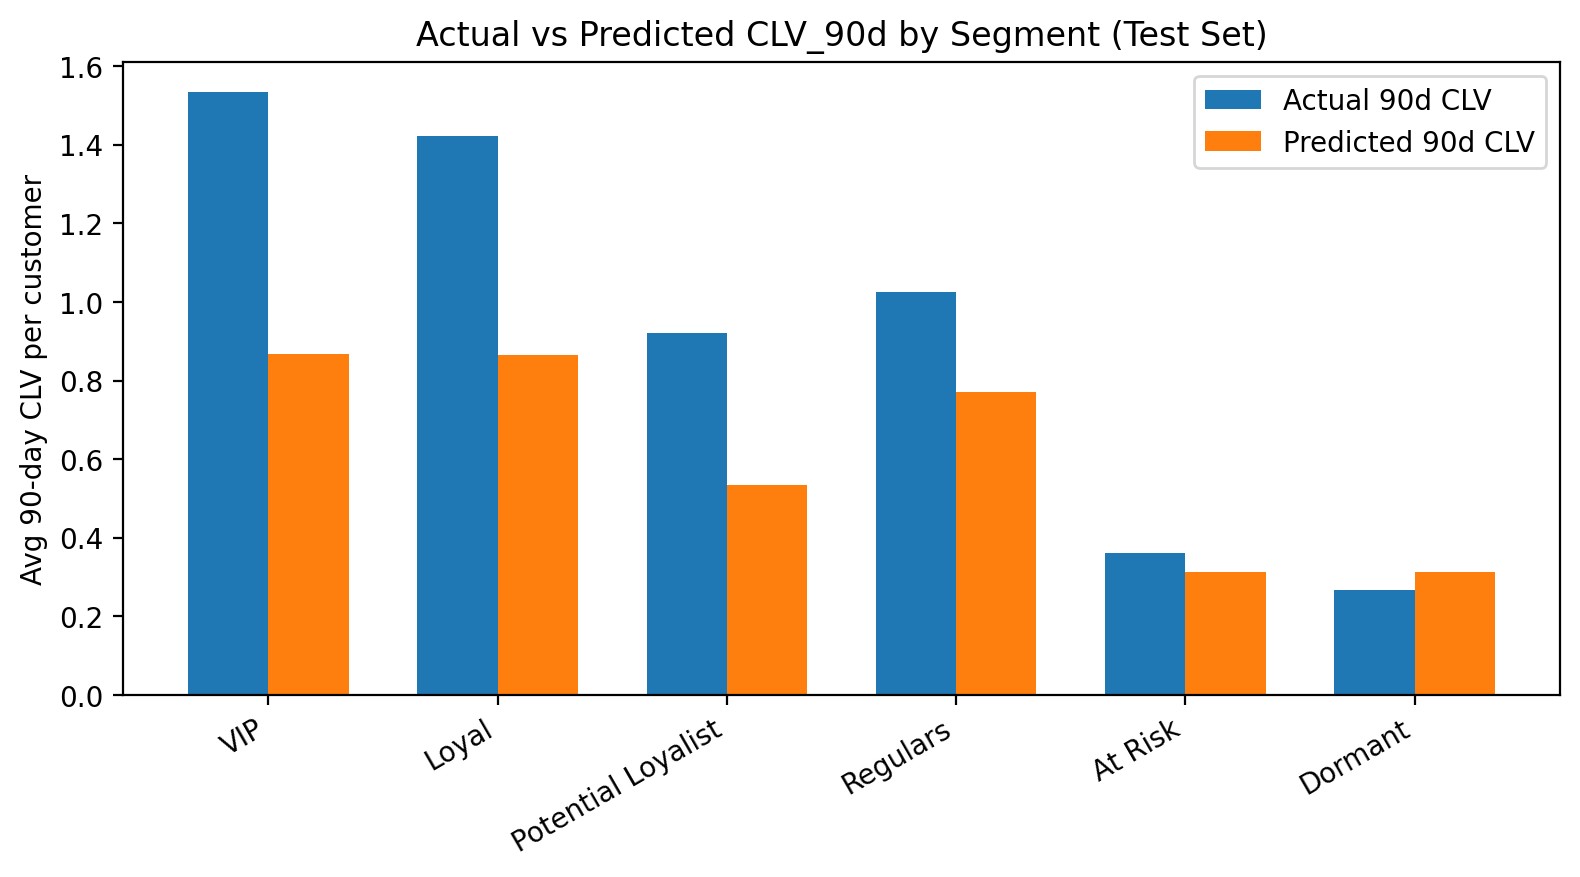

In [147]:
fig, ax = plt.subplots(figsize=(8, 4.5))

x = np.arange(len(seg_plot))
w = 0.35

ax.bar(x - w/2, seg_plot["actual_clv_90d"], width=w, label="Actual 90d CLV")
ax.bar(x + w/2, seg_plot["pred_clv_90d"],   width=w, label="Predicted 90d CLV")

ax.set_xticks(x)
ax.set_xticklabels(seg_plot["segment"], rotation=30, ha="right")
ax.set_ylabel("Avg 90-day CLV per customer")
ax.set_title("Actual vs Predicted CLV_90d by Segment (Test Set)")
ax.legend()

plt.tight_layout()
plt.savefig("out/segment_actual_vs_predicted_clv_final.png", dpi=150)
plt.show()

In [141]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Build evaluation dataframe (test customers + predictions)
cid = "user_id"  # should already be defined like this

eval_df = data[data[cid].isin(te_ids)].copy()
eval_df["pred_clv_90d"] = y_pred

# 2) Ensure we have RFM segments on eval_df
if "segment" not in eval_df.columns:
    eval_df = build_rfm_segment(eval_df)  # uses your earlier function

# 3) Segment summary table
segment_order = [
    "VIP", "Loyal", "Potential Loyalist",
    "Regulars", "At Risk", "Dormant"
]

seg_summary = (
    eval_df.groupby("segment")
        .agg(
            customers=(cid, "nunique"),
            hist_monetary=("monetary", "mean"),
            actual_clv_90d=("actual_clv_90d", "mean"),
            pred_clv_90d=("pred_clv_90d", "mean"),
            total_actual_clv_90d=("actual_clv_90d", "sum"),
        )
        .reset_index()
)

# shares
total_customers = seg_summary["customers"].sum()
total_revenue = seg_summary["total_actual_clv_90d"].sum()

seg_summary["cust_share"] = seg_summary["customers"] / total_customers
seg_summary["rev_share"] = seg_summary["total_actual_clv_90d"] / total_revenue

# order segments nicely for plots
seg_summary["segment"] = pd.Categorical(
    seg_summary["segment"],
    categories=segment_order,
    ordered=True
)
seg_summary = seg_summary.sort_values("segment")

seg_summary


,segment,customers,hist_monetary,actual_clv_90d,pred_clv_90d,total_actual_clv_90d,cust_share,rev_share
5,VIP,291,48.622062,1.533505,0.868674,446.250001,0.068827,0.130505
2,Loyal,381,33.537900,1.421234,0.865305,541.489999,0.090114,0.158358
3,Potential Loyalist,144,47.499444,0.920694,0.534109,132.580000,0.034059,0.038773
4,Regulars,1709,18.589590,1.024324,0.771472,1750.569998,0.404210,0.511951
0,At Risk,987,31.347062,0.361368,0.312025,356.670001,0.233444,0.104307
1,Dormant,716,12.407570,0.267947,0.313025,191.849999,0.169347,0.056106


In [145]:
import numpy as np

# Make sure seg_summary is in the right order
segment_order = ["VIP", "Loyal", "Potential Loyalist", "Regulars", "At Risk", "Dormant"]
seg = seg_summary.set_index("segment").loc[segment_order].reset_index()

# Overall averages
total_customers = seg["customers"].sum()
total_revenue = seg["total_actual_clv_90d"].sum()
overall_clv = total_revenue / total_customers

print(f"Total customers: {total_customers}")
print(f"Total 90d revenue: {total_revenue:.2f}")
print(f"Avg CLV_90d per customer: {overall_clv:.3f}")

# Combined groups
vip_loyal = seg[seg["segment"].isin(["VIP", "Loyal"])]
vip_loyal_cust_share = vip_loyal["cust_share"].sum()
vip_loyal_rev_share = vip_loyal["rev_share"].sum()

regulars = seg[seg["segment"] == "Regulars"].iloc[0]
at_risk = seg[seg["segment"] == "At Risk"].iloc[0]
dormant = seg[seg["segment"] == "Dormant"].iloc[0]

print(f"\nVIP + Loyal: {vip_loyal_cust_share*100:.1f}% of customers, "
      f"{vip_loyal_rev_share*100:.1f}% of 90d revenue")

print(f"Regulars: {regulars.cust_share*100:.1f}% of customers, "
      f"{regulars.rev_share*100:.1f}% of 90d revenue")

print(f"At Risk: {at_risk.cust_share*100:.1f}% of customers, "
      f"{at_risk.rev_share*100:.1f}% of 90d revenue")

print(f"Dormant: {dormant.cust_share*100:.1f}% of customers, "
      f"{dormant.rev_share*100:.1f}% of 90d revenue")


Total customers: 4228
Total 90d revenue: 3419.41
Avg CLV_90d per customer: 0.809

VIP + Loyal: 15.9% of customers, 28.9% of 90d revenue
Regulars: 40.4% of customers, 51.2% of 90d revenue
At Risk: 23.3% of customers, 10.4% of 90d revenue
Dormant: 16.9% of customers, 5.6% of 90d revenue


In [149]:
df = orders.copy()

df["has_shipped"] = df["shipped_at"].notna()
df["has_delivered"] = df["delivered_at"].notna()

# 1) Overall proportions (what you're seeing now)
print("Share of all orders with shipped_at:", df["has_shipped"].mean())
print("Share of all orders with delivered_at:", df["has_delivered"].mean())

# 2) How shipped/delivered intersect
print("\nCombination of shipped/delivered (as % of all orders):")
print(pd.crosstab(df["has_shipped"], df["has_delivered"], normalize="all"))

# 3) By status (this usually explains 90% of the weirdness)
print("\nBy status (row-normalized):")
print(pd.crosstab(df["status"], [df["has_shipped"], df["has_delivered"]],
                  normalize="index"))


Share of all orders with shipped_at: 0.6175678952473327
Share of all orders with delivered_at: 0.3931377303588749

Combination of shipped/delivered (as % of all orders):
has_delivered     False     True 
has_shipped                      
False          0.382432  0.000000
True           0.224430  0.393138

By status (row-normalized):
has_shipped   False True       
has_delivered False False True 
status                         
Cancelled       1.0   0.0   0.0
Complete        0.0   0.0   1.0
Processing      1.0   0.0   0.0
Returned        0.0   0.0   1.0
Shipped         0.0   1.0   0.0
